### Magnetic Resonance Images (MRI) Classification with Convolutional Neural Network (CNN)

In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time
import tensorflow as tf
from tensorflow import keras 
from keras import applications
 
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from keras.preprocessing.image import load_img,img_to_array
from image_enhancement import image_enhancement as ie
from skimage import exposure
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import watershed, disk, binary_dilation, remove_small_objects
from PIL import Image
from sklearn import metrics
import os


def tss(y):
    '''returns total sum of sequares'''
    return np.sum((y - np.mean(y))**2)

def sse(y, y_pred):
    '''returns sum of squared errors of model predictions vs actual'''
    return np.sum((y - y_pred) ** 2)  

def RMSE(y_pred, y_test):
    """This functions returns the root Mean Squared Error from y-predictions and y-values 
    also given the number of observation in the test set"""
    return np.sqrt(np.sum((y_pred - y_test)**2)/len(y_test))

def r_squared(y_test, y_pred):
    '''returns r-squared'''
    return 1 - (sse(y_test, y_pred)/tss(y_test))

def adj_r_squared(y, y_pred, x_test):
    return 1 - (1-r_squared(y, y_pred))*(len(y)-1)/ (len(y)-x_test.shape[1]-1)


def plot_confusion_matrix(y_test, y_preds, 
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Reds):
    classes =  ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
    cm = confusion_matrix(y_test, y_preds)
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(14,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

Looking up our image dataset

In [2]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
# train_data_dir = 'data/train'  
# validation_data_dir = 'data/validation'  
# test_data_dir = 'data/test'
   
train_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/train"
validation_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/test"
test_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/test"
# number of epochs to train top model  
epochs = 10

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [27]:
datagen = ImageDataGenerator(rescale=1. / 223)  #needed to create the bottleneck .npy files

Creation of weights/features with VGG16

In [28]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(train_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=True)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 5121 images belonging to 4 classes.


/home/behr/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:11:21.495626


In [29]:
#run this only once
start = datetime.datetime.now()


generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=True)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end = datetime.datetime.now()
elapsed = end-start
print ('Time: ', elapsed)

Found 1279 images belonging to 4 classes.
Time:  0:03:00.202794


In [30]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size = (img_width, img_height),  
     batch_size = batch_size,  
     class_mode = None,  
     shuffle = True)  

nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1279 images belonging to 4 classes.
Time:  0:02:59.310270


Loading training, validation and testing data

In [31]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  

nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 5121 images belonging to 4 classes.


In [32]:
#validation data

generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=True)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1279 images belonging to 4 classes.


In [33]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=True)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1279 images belonging to 4 classes.


This was an initial trial. This is NOT the Final Model

In [34]:
#start = datetime.datetime.now()

from keras.models import load_model
#model.save('first_try.h5')  # creates a HDF5 file 'my_model.h5'
#model.load_weights('second_try.h5')

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
# model.add(tf.keras.Input(shape=(*IMAGE_SIZE, 3)))
# model.add(tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
# model.add(tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'))

# model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2) ))
# model.add(tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'))
model.add(Dense(600, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(300, activation=keras.layers.LeakyReLU(alpha=0.3)))  #100
model.add(Dropout(0.01))  
model.add(Dense(150, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.01)) #0.3
model.add(Dense(num_classes, activation='softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr= 0.001, beta_1=0.9, beta_2=0.9999),
              metrics= [ keras.metrics.BinaryAccuracy(name='accuracy'),
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])  

history = model.fit(train_data, train_labels,  
      epochs=  25,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels),  
                     callbacks=[checkpoint, early_stopping, lr_scheduler],
         shuffle=True)  

model.save_weights(top_model_weights_path)  
#eval_loss, eval_accuracy
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_data, test_labels, 
                                            batch_size=batch_size, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))
# end= datetime.datetime.now()
# elapsed= end-start
# print ('Time: ', elapsed)

Epoch 1/25
103/103 [==============================] - 9s 78ms/step - loss: 184.0027 - accuracy: 0.6873 - precision: 0.3650 - recall: 0.3494 - auc: 0.5782 - val_loss: 3.5643 - val_accuracy: 0.6751 - val_precision: 0.3503 - val_recall: 0.3503 - val_auc: 0.7055
Epoch 2/25
103/103 [==============================] - 9s 83ms/step - loss: 2.2657 - accuracy: 0.7172 - precision: 0.4245 - recall: 0.3595 - auc: 0.7153 - val_loss: 1.0678 - val_accuracy: 0.7506 - val_precision: 0.5012 - val_recall: 0.5012 - val_auc: 0.7763
Epoch 3/25
103/103 [==============================] - 8s 76ms/step - loss: 1.1522 - accuracy: 0.7349 - precision: 0.4583 - recall: 0.3215 - auc: 0.7616 - val_loss: 1.1293 - val_accuracy: 0.7469 - val_precision: 0.4905 - val_recall: 0.3245 - val_auc: 0.7719
Epoch 4/25
103/103 [==============================] - 8s 76ms/step - loss: 1.1507 - accuracy: 0.7371 - precision: 0.4506 - recall: 0.2643 - auc: 0.7518 - val_loss: 1.0680 - val_accuracy: 0.7451 - val_precision: 0.4269 - val_rec

  accuracy: 72.69%
  Loss: 1.30
Recal 37.14%, Area under the Curve (AUC) 73.13%
Confusion matrix, without normalization


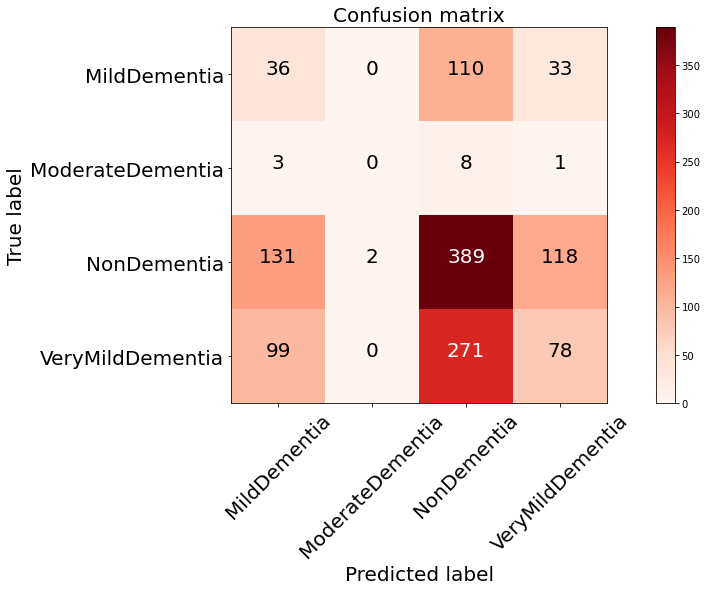

In [36]:
# import pickle
# # to save:
# with open('history.pikl', 'wb') as f:
#     pickle.dump(history.history, f)
# f.close()

#to retrieve:    
# with open('histor.pikl', 'rb') as f:
#     history = pickle.load(f)
# f.close()
 
print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_data),0) 
_test_labels = pd.DataFrame(test_labels).idxmax(axis=1) ## Does this idsmax need to be here?
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

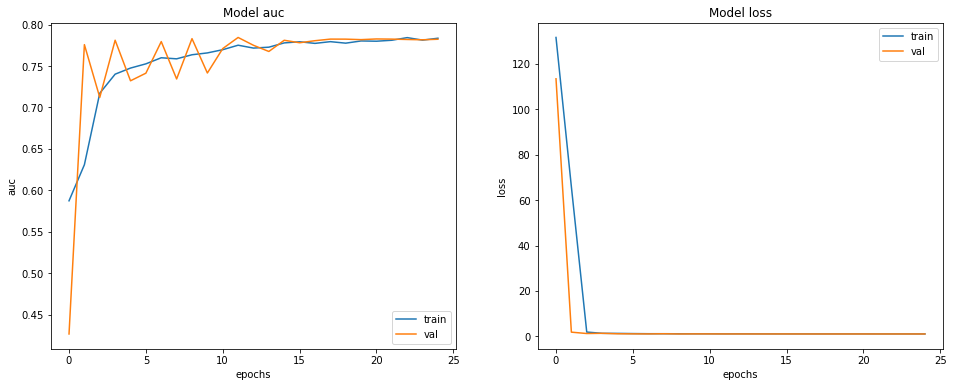

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    

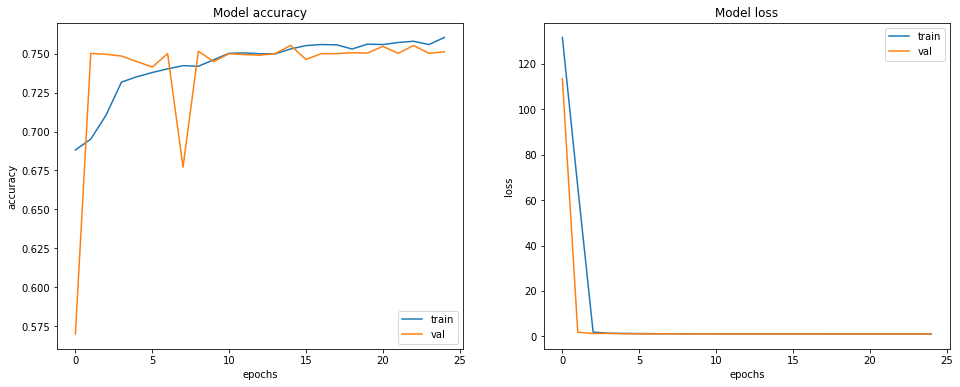

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

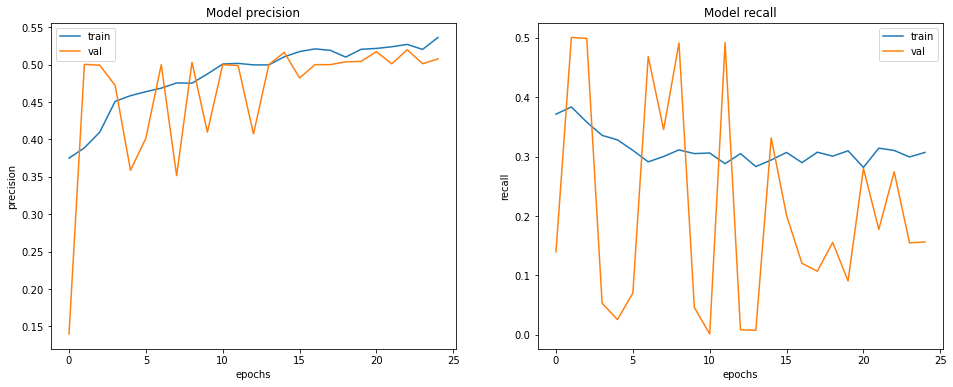

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

train (5121, 208, 176, 3) (5121,)
test (1279, 208, 176, 3) (1279,)


/home/behr/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


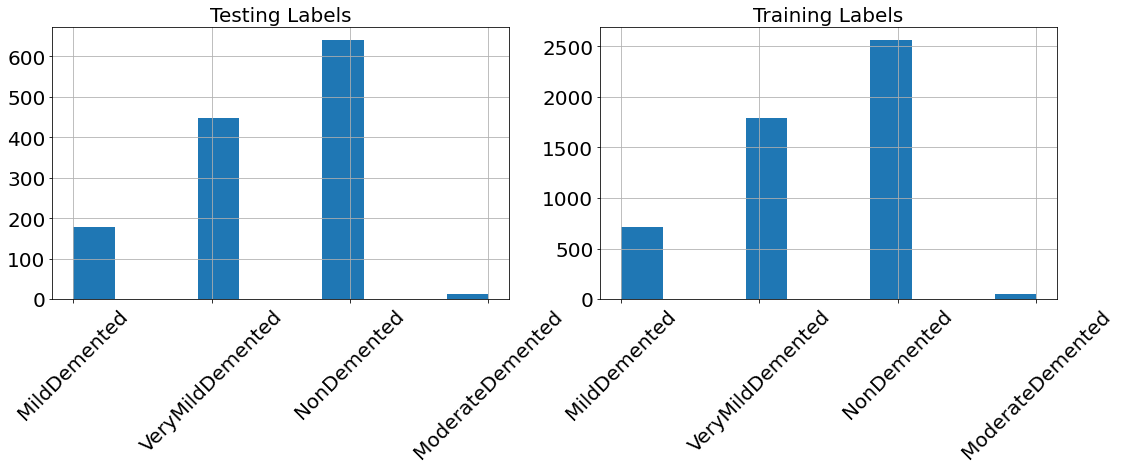

In [3]:
import glob
import os
import cv2
from sklearn.model_selection import train_test_split

train_images = []
train_labels = []

test_images = []
test_labels = []

labels = np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

folder_name =  "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/train"    # 
for name in glob.glob(folder_name + os.path.sep + r'*'): 
    for image_path in glob.glob(name + os.path.sep + r'*'): 
        im = cv2.imread(image_path)#, cv2.IMREAD_GRAYSCALE)
        train_images.append(im)
        train_labels.append(np.where(labels == name.split(os.path.sep)[-1])[0][0])

folder_name = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/test"  # 
for name in glob.glob(folder_name + os.path.sep + r'*'): 
    for image_path in glob.glob(name + os.path.sep + r'*'): 
        im = cv2.imread(image_path)#, cv2.IMREAD_GRAYSCALE)
        test_images.append(im)
#         print(np.where(labels == name.split(os.path.sep)[-1])[0])
        test_labels.append(np.where(labels == name.split(os.path.sep)[-1])[0][0])
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print('train',train_images.shape, train_labels.shape)


test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('test',test_images.shape, test_labels.shape)

x_train = train_images#.reshape(5121, 208* 176*3)
x_test = test_images#.reshape(1279 , 208* 176*3)
y_train = train_labels
y_test = test_labels

import pandas as pd
plt.figure(figsize=(18,5))
df = pd.concat([pd.Series(train_labels), pd.Series(test_labels)], axis=1)
df = df.rename(columns={0: 'train_labels', 1: 'test_labels'})

dic = {0 :'MildDemented', 1:'ModerateDemented', 2:'NonDemented', 3:'VeryMildDemented'}
df = df.replace(dic)
plt.subplot(121),df.test_labels.hist( ), plt.xticks(fontsize =20 , rotation =45),plt.yticks(fontsize =20)
plt.title('Testing Labels', fontsize = 20);#, plt.xticks(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']); 

plt.subplot(122),df.train_labels.hist( ),plt.xticks(fontsize =20 , rotation =45), plt.title('Training Labels', fontsize = 20),plt.yticks(fontsize =20);

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight = dict(list(enumerate(class_weights)))
#datagen = ImageDataGenerator(rescale=1. / 223)  
# datagen = ImageDataGenerator(
#         rescale = 1./ 224,
#         rotation_range=5,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=False,
#         fill_mode='nearest')

#datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:

In [4]:
datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        fill_mode='nearest')

# class BalancedDataGenerator(Sequence):
#     """ImageDataGenerator + RandomOversampling"""
#     def __init__(self, x, y, datagen, batch_size=32):
#         self.datagen = datagen
#         self.batch_size = min(batch_size, x.shape[0])
#         datagen.fit(x)
#         self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
#         self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
#     def __len__(self):
#         return self.steps_per_epoch

#     def __getitem__(self, idx):
#         x_batch, y_batch = self.gen.__next__()
#         x_batch = x_batch.reshape(-1, *self._shape[1:])
#         return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# bgen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = bgen.steps_per_epoch

In [13]:

img = train_images[0] #load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = train_images[0] #img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


# Contrast enhancement

https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_rank_filters.html

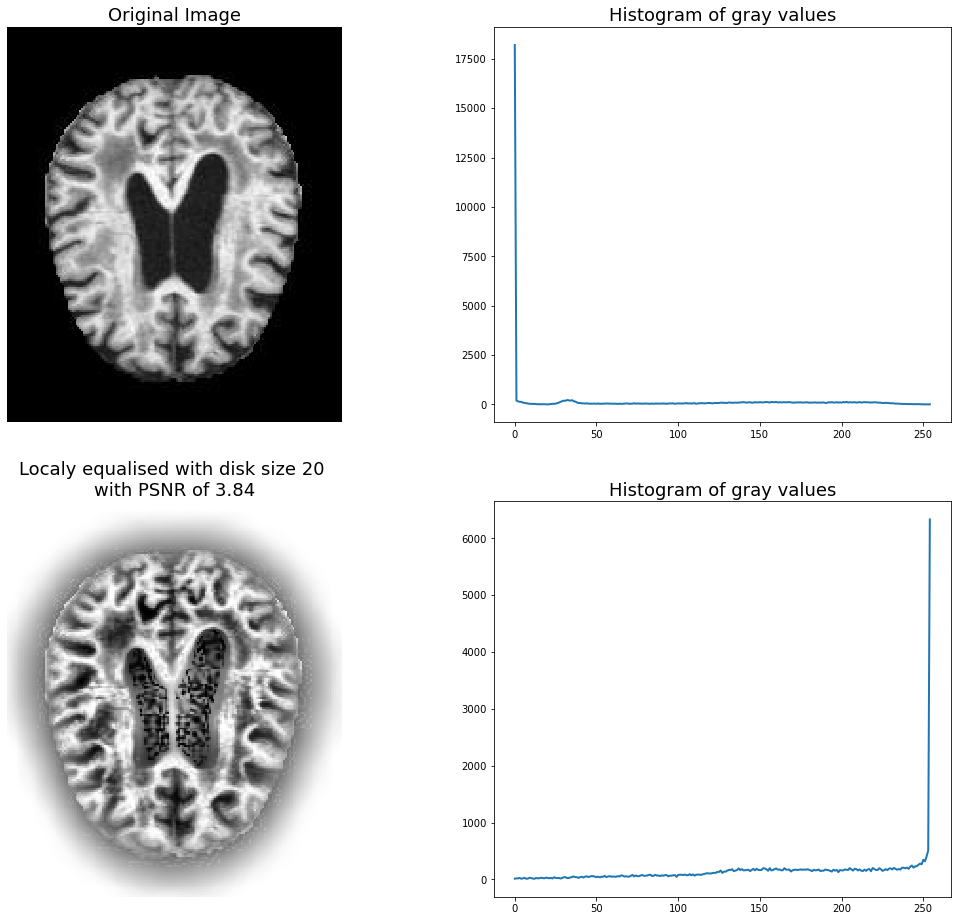

In [5]:
def compute_psnr(img1, img2):
    img1 = img1.astype(np.float64) / 255.
    img2 = img2.astype(np.float64) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * np.log10(1. / mse)

from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.filters import rank
from skimage.morphology import watershed, disk

noisy_image = img_as_ubyte(test_images[20,:,:,0] )

# equalize globally and locally
glob = exposure.equalize_hist(noisy_image) * 255

disk_size = 20

loc = rank.equalize(noisy_image, disk(disk_size))
#print(loc.shape)
# extract histogram for each image
hist = np.histogram(noisy_image, bins=np.arange(0, 256))

glob_hist = np.histogram(glob, bins=np.arange(0, 256))

loc_hist = np.histogram(loc, bins=np.arange(0, 256))

fig, ax = plt.subplots(2, 2, figsize=(18, 16))
ax1, ax2, ax3, ax4 = ax.ravel()  #, ax5, ax6

ax1.imshow(noisy_image, interpolation='nearest', cmap=plt.cm.gray)
ax1.set_title('Original Image', fontsize = 18)
ax1.axis('off')

ax2.plot(hist[1][:-1], hist[0], lw=2)
ax2.set_title('Histogram of gray values', fontsize = 18)

# ax3.imshow(glob, interpolation='nearest', cmap=plt.cm.gray)
# ax3.axis('off')

# ax4.plot(glob_hist[1][:-1], glob_hist[0], lw=2)
# ax4.set_title('Histogram of gray values')

ax3.imshow(loc, interpolation='nearest', cmap=plt.cm.gray)
ax3.set_title(f'Localy equalised with disk size {disk_size} \nwith PSNR of {compute_psnr(loc, noisy_image):.2f}', fontsize = 18)
ax3.axis('off')

ax4.plot(loc_hist[1][:-1], loc_hist[0], lw=2)
ax4.set_title('Histogram of gray values', fontsize = 18);

# Histogram Equalisation and Normalisation

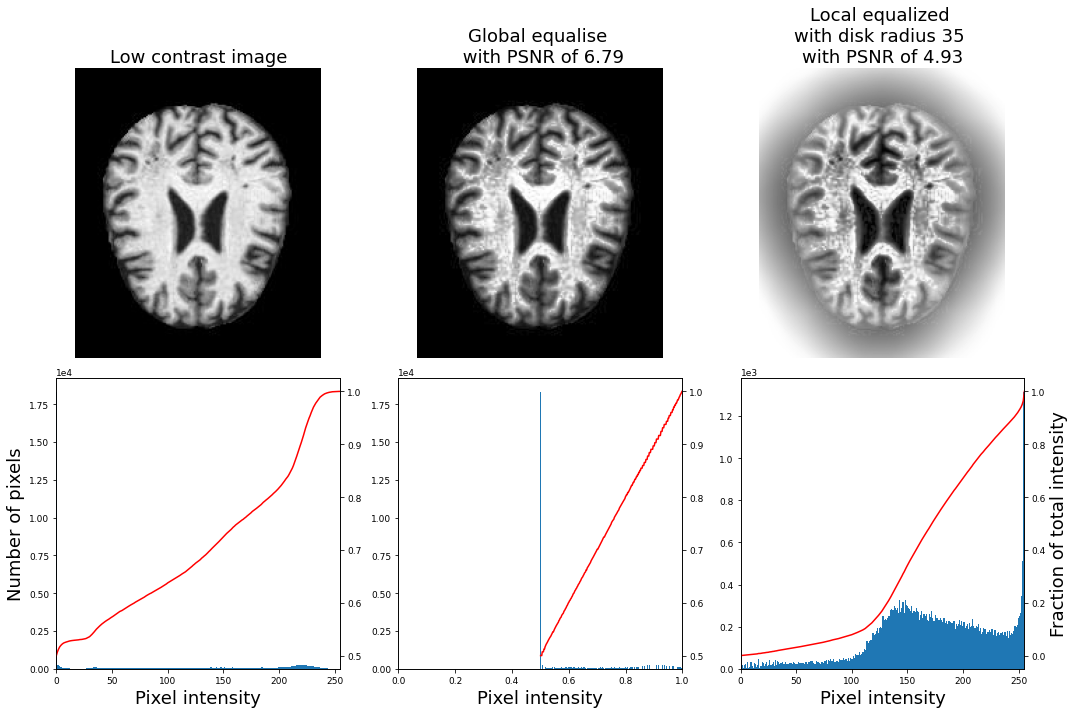

In [6]:
import matplotlib
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank
from skimage.color import rgb2gray
matplotlib.rcParams['font.size'] = 9

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram. """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity', fontsize=18)

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(0, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf

img = img_as_ubyte(test_images[220,:,:,0])
# Global equalize
img_rescale = exposure.equalize_hist(img)
# Equalization
disk_size = 35
 
img_eq = rank.equalize(img , disk(disk_size))
 
fig = plt.figure(figsize=(15, 10))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image', fontsize=18)
ax_hist.set_ylabel('Number of pixels', fontsize=18)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title(f'Global equalise \n with PSNR of {compute_psnr(img, img_rescale):.2f}', fontsize=18)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title(f'Local equalized \nwith disk radius {disk_size} \nwith PSNR of {compute_psnr(img, img_eq):.2f}', fontsize=18)
ax_cdf.set_ylabel('Fraction of total intensity', fontsize=18)

# prevent overlap of y-axis labels
fig.tight_layout()

In [6]:
df.test_labels.describe()

tt_counts = df.test_labels.value_counts().sort_index() 
print('Test \n',tt_counts)

tn_counts = df.train_labels.value_counts().sort_index() 
print('Train \n',tn_counts)
 

Test 
 MildDemented        179
ModerateDemented     12
NonDemented         640
VeryMildDemented    448
Name: test_labels, dtype: int64
Train 
 MildDemented         717
ModerateDemented      52
NonDemented         2560
VeryMildDemented    1792
Name: train_labels, dtype: int64


In [6]:
# finding cumulative sums for indices for the right folder to put images into
df.test_labels.describe()

test_counts = df.test_labels.value_counts().sort_index().cumsum()
print('test \n',test_counts)

train_counts = df.train_labels.value_counts().sort_index().cumsum()
print('train \n',train_counts)
test_counts[0]

test 
 MildDemented         179
ModerateDemented     191
NonDemented          831
VeryMildDemented    1279
Name: test_labels, dtype: int64
train 
 MildDemented         717
ModerateDemented     769
NonDemented         3329
VeryMildDemented    5121
Name: train_labels, dtype: int64


179

<ipython-input-26-93373555dd00>:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  plt.subplot(1,3 ,i),     plt.imshow(im_noisy),     plt.title(f"Noisy ({noise_type}), PSNR= {round(compare_psnr(im, im_noisy),3) }" ),    plt.axis('off')
<ipython-input-26-93373555dd00>:23: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  plt.subplot(1,3, i+1), plt.imshow(im_denoised_mean), plt.title(f"Denoised ({mean}), PSNR= {round(compare_psnr(im, im_denoised_mean),3) }" ), plt.axis('off')
<ipython-input-26-93373555dd00>:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  plt.subplot(1,3, i+2), plt.imshow(im_denoised_median), plt.title(f

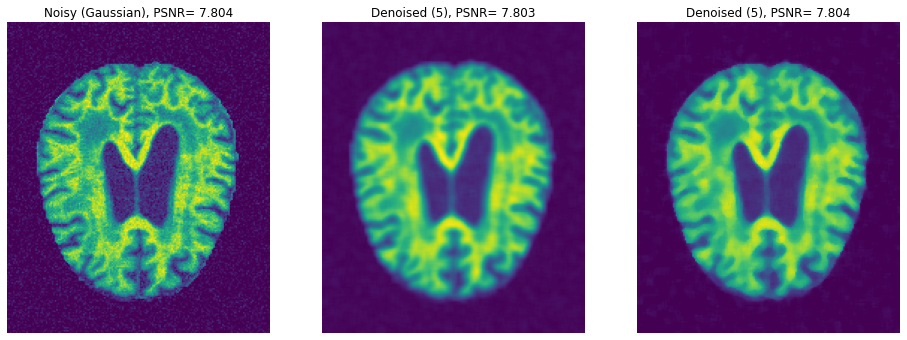

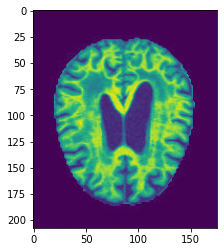

In [26]:
from scipy.ndimage import uniform_filter, median_filter
from skimage.util import random_noise
import matplotlib.pylab as plt
from skimage.color import rgb2gray
from skimage.measure import compare_psnr   # This will compute the Peak Signal to Noise ratio
from skimage.io import imread

def apply_gaussian_noise(X,sigma=0.1):
    """     adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.     """
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)### YOUR CODE HERE ###
    return X + noise
#apply_gaussian_noise = lambda X, sigma: X + np.random.normal(loc=0, scale=sigma, size=X.shape)


def plot_images(im, im_noisy,  noise_type, i):
    mean , median=5, 5
    im_denoised_mean = uniform_filter(im_noisy,mean)
    im_denoised_median = median_filter(im_noisy,median)
    plt.figure(figsize=(16,16))
    plt.subplot(1,3 ,i),     plt.imshow(im_noisy),     plt.title(f"Noisy ({noise_type}), PSNR= {round(compare_psnr(im, im_noisy),3) }" ),    plt.axis('off')
    plt.subplot(1,3, i+1), plt.imshow(im_denoised_mean), plt.title(f"Denoised ({mean}), PSNR= {round(compare_psnr(im, im_denoised_mean),3) }" ), plt.axis('off')
    plt.subplot(1,3, i+2), plt.imshow(im_denoised_median), plt.title(f"Denoised ({median}), PSNR= {round(compare_psnr(im, im_denoised_median),3) }" ), plt.axis('off')
    noise = im_noisy - im
    plt.show()

im =  test_images[0,:,:,0] 
im1 = random_noise(im, 'gaussian', var = 0.05**2)
img = apply_gaussian_noise(im ,sigma=0.3)
plot_images(im, im1,  'Gaussian', 1)
plt.imshow(img);

# Image Enhancement with Histogram Equalisation
Enhancing image  contrasts and puting them into new directories for a new model

In [19]:
files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

#print(os.getcwd())
# path = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train'
# os.mkdir(path)
# path = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test'
# os.mkdir(path)
# for i in range(len(files)):
#     path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test/{files[i]}"
#     path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train/{files[i]}"
#     try:
#         os.mkdir(path)
#         os.mkdir(path2)
#         #os.rmdir(path)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
#     else:
#         print ("Successfully created the directory %s" % path)
start = datetime.datetime.now()
train_img = np.empty((5121, 208, 176))
test_img = np.empty((1279, 208, 176))
train , test = [] , []
for i in range(len(test_images)):
    noisy_image = img_as_ubyte(test_images[i,:,:,0] )
    #test_img[i,:,:] = rank.equalize(noisy_image, disk(60))
    img_rescale = exposure.equalize_hist(noisy_image)
     
    im = Image.fromarray( img_rescale ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
    noisy_image = img_as_ubyte(train_images[i,:,:,0] )
#     train_img[i,:,:] = rank.equalize(noisy_image, disk(60))
    img_rescale = exposure.equalize_hist(noisy_image)
    im = Image.fromarray( img_rescale ).convert('RGB')
    if i < train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i < train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed/train/{files[3]}/train_{i}.jpg" , 'JPEG')

end = datetime.datetime.now()
elapsed = end - start
print(f'Global HE done in {elapsed}')

Global HE done in 0:00:15.520377


To combine the effects of the above with other HE run the very next cell otherwise avoid it.

# Drawing from Noisy images

In [45]:
folder_name =  "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/changed/train"    # 
for name in glob.glob(folder_name + os.path.sep + r'*'): 
    for image_path in glob.glob(name + os.path.sep + r'*'): 
        im = cv2.imread(image_path)#, cv2.IMREAD_GRAYSCALE)
        train_images.append(im)
        train_labels.append(np.where(labels == name.split(os.path.sep)[-1])[0][0])

folder_name = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/changed/test"  # 
for name in glob.glob(folder_name + os.path.sep + r'*'): 
    for image_path in glob.glob(name + os.path.sep + r'*'): 
        im = cv2.imread(image_path)#, cv2.IMREAD_GRAYSCALE)
        test_images.append(im)
#         print(np.where(labels == name.split(os.path.sep)[-1])[0])
        test_labels.append(np.where(labels == name.split(os.path.sep)[-1])[0][0])
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print('train',train_images.shape, train_labels.shape)


test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('test',test_images.shape, test_labels.shape)


train (5121, 208, 176, 3) (5121,)
test (1279, 208, 176, 3) (1279,)


# Image Enhancement with Contrast Stretching

In [21]:
from skimage import exposure

files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# print(os.getcwd())
# path = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2'
# path1 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train'
# path2 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test'
# folders = [path, path1, path2]
# for i in folders:
#     try:
#         os.mkdir(i)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)

# for i in range(len(files)):
#     path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test/{files[i]}"
#     path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train/{files[i]}"
#     try:
#         os.mkdir(path)
#         os.mkdir(path2)
#         #os.rmdir(path)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
#     else:
#         print ("Successfully created the directory %s" % path)
start = datetime.datetime.now()
for i in range(len(test_images)):
    p1, p99 = np.percentile(test_images[i,:,:,0], (1, 99))
    img_rescale = exposure.rescale_intensity(test_images[i,:,:,0], in_range=(p1, p99))
    im = Image.fromarray( img_rescale ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
    p1, p99 = np.percentile(train_images[i,:,:,0], (1, 99))
    img_rescale = exposure.rescale_intensity(train_images[i,:,:,0]*2, in_range=(p1, p99))
    im = Image.fromarray( img_rescale ).convert('RGB')
    if i <train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i< train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed2/train/{files[3]}/train_{i}.jpg" , 'JPEG')

end= datetime.datetime.now()
elapsed= end - start
print ('Time: ', elapsed)

Time:  0:00:12.850719


In [51]:
files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# path = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3'
# path1 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train'
# path2 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test'
# folders = [path, path1, path2]
# for i in folders:
#     try:
#         os.mkdir(i)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
        
# for i in range(len(files)):
#     path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test/{files[i]}"
#     path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train/{files[i]}"
#     try:
#         os.mkdir(path)
#         os.mkdir(path2)
#         #os.rmdir(path)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
#     else:
#         print ("Successfully created the directory %s" % path)
from scipy.fftpack import dct, idct
 

start = datetime.datetime.now()
for i in range(len(test_images)):
    CLAHE = clahe(test_images[i,:,:,0],8,0,0)
#     im = dct(test_images[i,:,:,0], n= 170, type=3, norm ='ortho', axis=-1)
#     im = idct(im)
    #im  = exposure.equalize_adapthist(test_images[i,:,:,0]*2, clip_limit=0.99)
    #im  = exposure.adjust_log(test_images[i,:,:,0], 2)
#     gray = cv2.cvtColor(test_images[i,:,:,:], cv2.COLOR_BGR2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized = clahe.apply(gray)
    im = Image.fromarray( CLAHE ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
    CLAHE = clahe(train_images[i,:,:,0],8,0,0)
#     gray = cv2.cvtColor(train_images[i,:,:,:], cv2.COLOR_BGR2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized = clahe.apply(gray)
#     im = dct(train_images[i,:,:,0], n= 170, type=3, norm ='ortho', axis=-1)
#     im = idct(im)
    #im  = exposure.equalize_adapthist(train_images[i,:,:,0]*2, clip_limit=0.99)
    #im  = exposure.adjust_log(train_images[i,:,:,0], 2)
    im = Image.fromarray( CLAHE ).convert('RGB')
    if i <train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i< train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed3/train/{files[3]}/train_{i}.jpg" , 'JPEG')
    
end= datetime.datetime.now()
elapsed= end - start
print ('CLAHE log adjusted done in: ', elapsed)

CLAHE log adjusted done in:  0:29:12.658111


In [13]:
from skimage import exposure
files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
try:
    path0 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4'
    path1 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train'
    path15 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test'
    os.mkdir(path15)
    os.mkdir(path0)
    os.mkdir(path1)
except OSError as err:
    print ("Creation of the directory  failed because %s"   %err)
else:
    print ("Successfully created the directory %s" % path)
    
for i in range(len(files)):
    path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/{files[i]}"
    path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train/{files[i]}"

    try:
        os.mkdir(path)
        os.mkdir(path2)
        #os.rmdir(path)
    except OSError as err:
        print ("Creation of the directory  failed because %s"   %err)
    else:
        print ("Successfully created the directory %s" % path)


for i in range(len(test_images)):
    logarithmic_corrected = exposure.adjust_log(test_images[i,:,:,0], 1)
    im = Image.fromarray( logarithmic_corrected ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
    logarithmic_corrected = exposure.adjust_log(train_images[i,:,:,0], 1)
    im = Image.fromarray( logarithmic_corrected ).convert('RGB')
    if i <train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i< train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/train/{files[3]}/train_{i}.jpg" , 'JPEG')
    
print('done')

Successfully created the directory /home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/MildDemented
Successfully created the directory /home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/ModerateDemented
Successfully created the directory /home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/NonDemented
Successfully created the directory /home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed4/test/VeryMildDemented
done


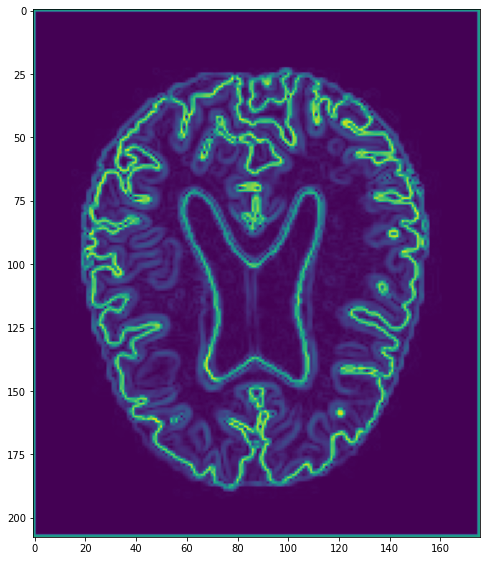

In [63]:
from skimage import exposure
import scipy.signal as sig
from scipy.fftpack import dct, idct
def HOG(img):
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    G_x = sig.convolve2d(img, kernel_x, mode='same') 
    G_y = sig.convolve2d(img, kernel_y, mode='same') 

    horizontal_gradient_square = np.power(G_x, 2)
    vertical_gradient_square = np.power(G_y, 2)
    return np.sqrt(horizontal_gradient_square + vertical_gradient_square)
plt.figure(figsize=(8,10))
img = HOG ((test_images[1053,:,:,0]*1)+150)
plt.imshow(img, cmap="viridis");

In [25]:


files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# try:
#     path0 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5'
#     path1 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train'
#     path15 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test'
    
#     os.mkdir(path0)
#     os.mkdir(path1)
#     os.mkdir(path15)
# except OSError as err:
#     print ("Creation of the directory  failed because %s"   %err)
# else:
#     print ("Successfully created the directory %s" % path)
    
# for i in range(len(files)):
#     path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test/{files[i]}"
#     path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train/{files[i]}"

#     try:
#         os.mkdir(path)
#         os.mkdir(path2)
#         #os.rmdir(path)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
#     else:
#         print ("Successfully created the directory %s" % path)

start =   datetime.datetime.now()

for i in range(len(test_images)):
    #img = ie.IE(test_images[i])
    
    #qbhe = img.QBHE( number_gray=35)
    #rsihe = img.RSIHE( recursive = 0.1 )
    #bhepl = img.BHEPL( )
    #bbhe = img.BBHE()
    #fhsabp = img.FHSABP()
    #wthe = img.WTHE(  root = 0.5, value = 2.99, lower =  0)
    #rlbhe = img.RLBHE()
    #bpheme = img.BPHEME()
    #rswhe = img.RSWHE( type = 'mean', recursive = 3)
    #agc = img.AGCCPF(alpha = 0.8)
    #dsihe = img.DSIHE()
    #im = img.FLH(enhancement=200)
    #im =  Image.fromarray( im ).convert('RGB')
    
    #img = HOG (test_images[i,:,:,0])
    #qbhe = img.QBHE(  number_gray=30)
    #dcrgc = img.DCRGC(contrast_intensity=2.9, gamma=1.5)
    #bhepl =img.BHEPL( )
    #bubohe = img.BUBOHE( underflow=0.01, overflow=1.99)
    #bhepl =img.BHEPL( )#
    #rswhe = img.RSWHE( type = 'mean', recursive = 3)
    # rmshe = img.RMSHE(  recursive = 3)
    

    #im = dct(test_images[i,:,:,0], n= 170, type=3 , axis=1)
#     im = idct(im)
    im = random_noise(test_images[i,:,:,0], 'gaussian', var = 0.05**2)
    #img = rank.equalize(test_images[i, :,:,0] , disk(35))
    #im =  Image.fromarray( im  ).convert('RGB')
    #     img_adapteq = exposure.equalize_adapthist(test_images[i,:,:,0], clip_limit=0.5 )
    im =  Image.fromarray( im  ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
#     img_adapteq = exposure.equalize_adapthist(train_images[i,:,:,0], clip_limit=0.5 )
    #img = ie.IE(train_images[i])
    
    #qbhe = img.QBHE( number_gray=35)
    #rsihe = img.RSIHE( recursive = 0.1 )
    #bhepl = img.BHEPL( )
    #bbhe = img.BBHE()
    #fhsabp = img.FHSABP()
    #wthe = img.WTHE(  root = 0.5, value = 2.99, lower =  0)
    #rlbhe = img.RLBHE()
    #bpheme = img.BPHEME()
    #rswhe = img.RSWHE( type = 'mean', recursive = 3)
    #agc = img.AGCCPF(alpha = 0.8)
    #dsihe = img.DSIHE()
    #im = img.FLH(enhancement=200)

    #qbhe = img.QBHE(  number_gray=30)
    #img = HOG (train_images[i,:,:,0])
#     
    #dcrgc = img.DCRGC(contrast_intensity=2.9, gamma=1.5)
    #bhepl =img.BHEPL( )
    #bubohe = img.BUBOHE( underflow=0.01, overflow=1.99)
    #bhepl =img.BHEPL( )
    #rswhe = img.RSWHE( type = 'mean', recursive = 3)
    #rmshe = img.RMSHE(  recursive = 3)

    
    im = random_noise(train_images[i,:,:,0], 'gaussian', var = 0.05**2)
    #im = dct(train_images[i,:,:,0], n= 170, type=3 , axis=1)
    #im = idct(im)
    #img = rank.equalize(train_images[i, :,:,0] , disk(35))
    im =  Image.fromarray( im  ).convert('RGB')
    if i <train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i< train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train/{files[3]}/train_{i}.jpg" , 'JPEG')

end = datetime.datetime.now()
elapsed = end - start
#print ('Time: ', elapsed)
print(f'Noisy images produced in {elapsed}')

Noisy images produced in 0:00:18.577223


In [7]:
from skimage import exposure
files = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# try:
#     path0 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6'
#     path1 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train'
#     path15 = '/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test'
    
#     os.mkdir(path0)
#     os.mkdir(path1)
#     os.mkdir(path15)
# except OSError as err:
#     print ("Creation of the directory  failed because %s"   %err)
# else:
#     print ("Successfully created the directory %s" % path)
    
# for i in range(len(files)):
#     path = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test/{files[i]}"
#     path2 = f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train/{files[i]}"

#     try:
#         os.mkdir(path)
#         os.mkdir(path2)
#         #os.rmdir(path)
#     except OSError as err:
#         print ("Creation of the directory  failed because %s"   %err)
#     else:
#         print ("Successfully created the directory %s" % path)
start = datetime.datetime.now()
for i in range(len(test_images)):
    gamma_corrected = exposure.adjust_gamma(test_images[i,:,:,0], 1)
    im =  Image.fromarray( gamma_corrected ).convert('RGB')
    if i <test_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test/{files[0]}/test_{i}.jpg" , 'JPEG') #
    elif i < test_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test/{files[1]}/test_{i}.jpg" , 'JPEG') 
    elif i< test_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test/{files[2]}/test_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/test/{files[3]}/test_{i}.jpg" , 'JPEG') 

for i in range(len(train_images)):
    gamma_corrected = exposure.adjust_gamma(train_images[i,:,:,0], 1)
    im = Image.fromarray( gamma_corrected ).convert('RGB')
    if i <train_counts[0]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train/{files[0]}/train_{i}.jpg" , 'JPEG')
    elif i < train_counts[1]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train/{files[1]}/train_{i}.jpg" , 'JPEG') 
    elif i< train_counts[2]:
        im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train/{files[2]}/train_{i}.jpg" , 'JPEG') 
    else: im.save(f"/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed6/train/{files[3]}/train_{i}.jpg" , 'JPEG')
    
end = datetime.datetime.now()
elapsed = end - start
print ('Adjust gamma done in: ', elapsed)

Adjust gamma done in:  0:00:08.149459


The following directory was name was edited each time a new Histogram Equalisation image enhancement was performed above. Upto 6 different folders were created. Due to lack of memory space required other enhancement methods were performed and their results over-wrote previous types of images that was in that folder. 

In [66]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE
 
BATCH_SIZE = 100 * strategy.num_replicas_in_sync
NUM_CLASSES = 4 
IMAGE_SIZE = [208, 176]

EPOCHS = 15

# train_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/train"
# validation_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/test"
# test_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/Alzheimer_s Dataset/test"

train_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/train"
validation_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test"
test_data_dir = "/home/behr/Documents/LectureNotes/Project/MRI /Alzeimers/changed5/test"
 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir ,
    validation_split=0.2,
    subset="validation",
    seed=1 ,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory( test_data_dir ,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Number of replicas: 1
Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [67]:
from tensorflow.keras import regularizers

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,3 , activation=keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    #   tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2 )    ]   )
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=keras.layers.LeakyReLU(alpha=0.3)
#                             ,  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)  #l2(0.01)
#                            , activity_regularizer= regularizers.l2(0.01)
                             ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)])
    return block

depth_pool = keras.layers.Lambda( lambda X : tf.nn.max_pool(X,ksize = (1,1,1,3), 
                                                            strides=(1,1,1,3), 
                                                            padding='valid' ))

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        conv_block(512),       
        tf.keras.layers.Flatten(),
        dense_block(512, 0.1),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    ])
    
    return model
  

with strategy.scope():
    model6 = build_model()
    METRICS = [ keras.metrics.BinaryAccuracy(name='accuracy'),
              keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    model6.compile(
                    optimizer= tf.keras.optimizers.Adam(lr= 0.001, beta_1=0.9, beta_2=0.999)   ,
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=METRICS     )

model6.summary()
#model.load_weights('third_try.h5')
#model.load_weights('12th_try.h5')

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

history = model6.fit(   train_ds,
                        validation_data=val_ds,
                     class_weight = class_weight,
    callbacks=[ early_stopping_cb, lr_scheduler],   #checkpoint_cb,
    epochs= EPOCHS , shuffle=True )
#model.save_weights('7th_try.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 104, 88, 3)        0         
_________________________________________________________________
sequential (Sequential)      (None, 52, 44, 512)       4123      
_________________________________________________________________
flatten (Flatten)            (None, 1171456)           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512)               599788032 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 599,794,207
Trainable params: 599,792,159
Non-trainable params: 2,048
_________________________________________________________________
Epoch 1/15
41/41 [==============================] - 218s 5s/step - loss: 4.2347 - accuracy: 0.6672 - p

13/13 [==============================] - 15s 1s/step - loss: 1.6483 - accuracy: 0.7625 - precision: 0.5256 - recall: 0.5129 - auc: 0.7825
HOG images  Accuracy: 76.25%
HOG images  (radius 35)   Loss: 1.65
HOG images  Recall 51.29%, Area under the Curve (AUC) 78.25%
Confusion matrix, without normalization


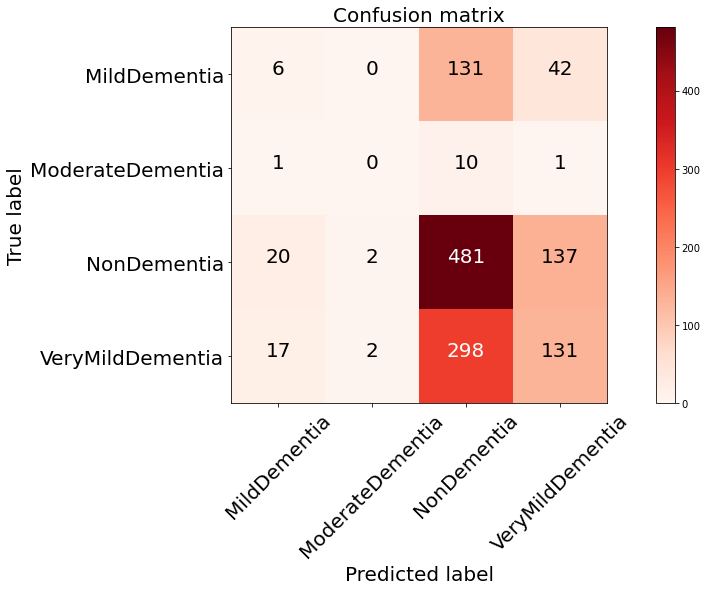

In [68]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("HOG images  Accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG images  (radius 35)   Loss: {:.2f}".format(loss))  
print("HOG images  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

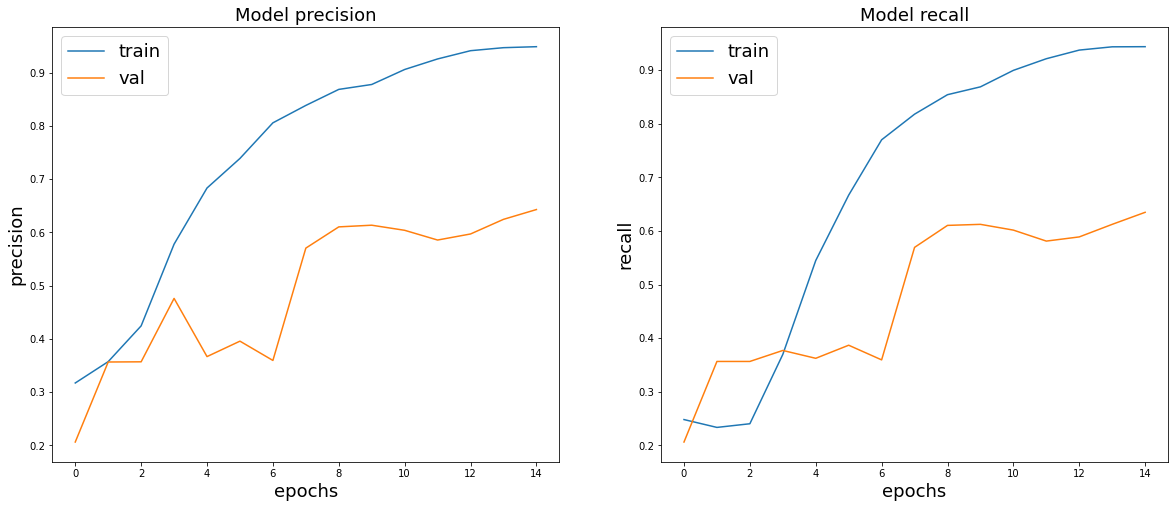

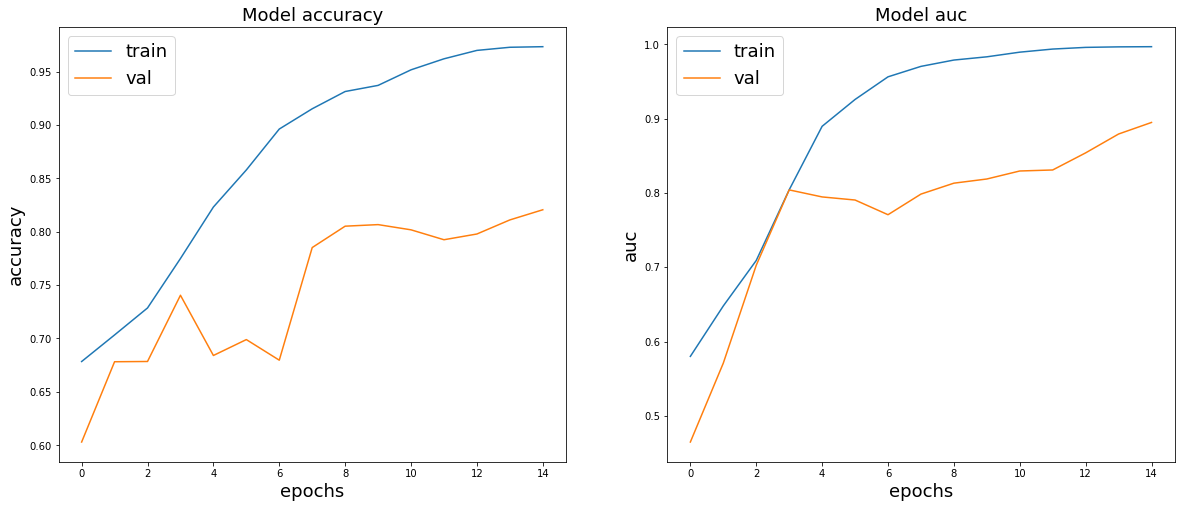

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 11s 801ms/step - loss: 1.2334 - accuracy: 0.8227 - precision: 0.6495 - recall: 0.6317 - auc: 0.8673
Baseline without noise images  Accuracy: 82.27%
Baseline without noise images  (radius 35)   Loss: 1.23
Baseline without noise images  Recall 63.17%, Area under the Curve (AUC) 86.73%
Confusion matrix, without normalization


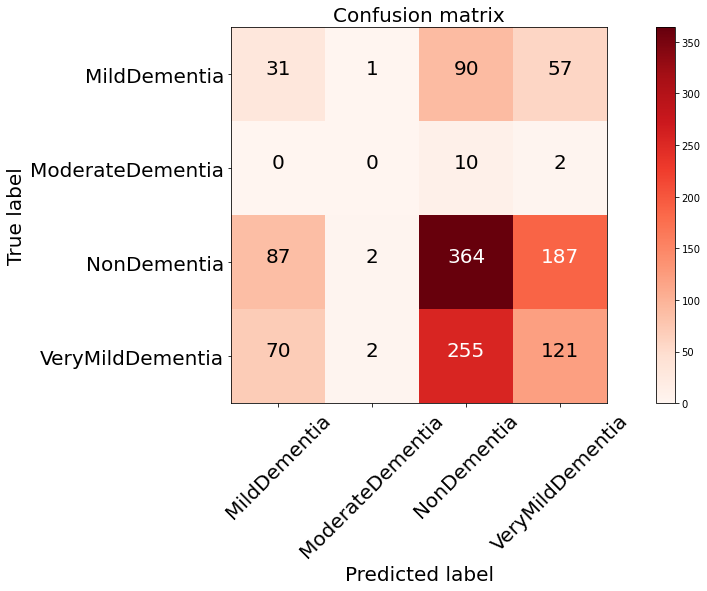

In [7]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Baseline without noise images  Accuracy: {:.2f}%".format(accuracy * 100))  
print("Baseline without noise images  (radius 35)   Loss: {:.2f}".format(loss))  
print("Baseline without noise images  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 16s 1s/step - loss: 1.9942 - accuracy: 0.7537 - precision: 0.5074 - recall: 0.5066 - auc: 0.7804
BUBOHE images  Accuracy: 75.37%
BUBOHE  images  (radius 35)   Loss: 1.99
BUBOHE  images  Recall 50.66%, Area under the Curve (AUC) 78.04%
Confusion matrix, without normalization


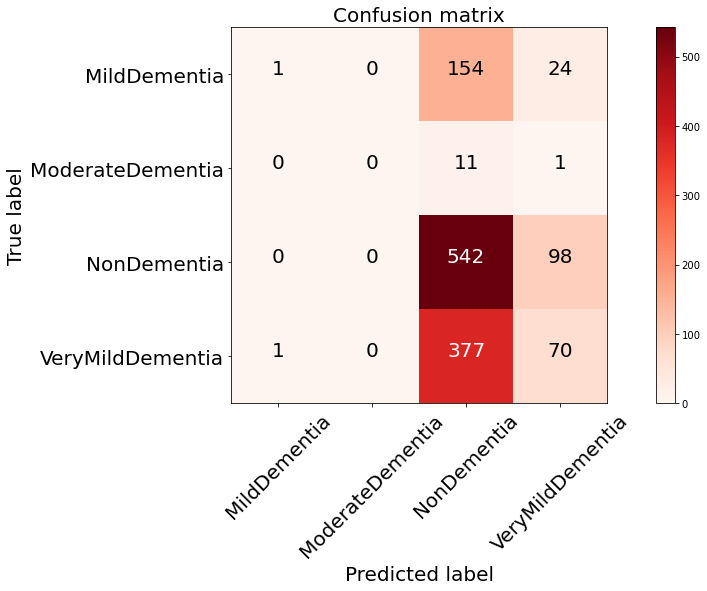

In [26]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("BUBOHE images  Accuracy: {:.2f}%".format(accuracy * 100))  
print("BUBOHE  images  (radius 35)   Loss: {:.2f}".format(loss))  
print("BUBOHE  images  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 18s 1s/step - loss: 1.5833 - accuracy: 0.7582 - precision: 0.5176 - recall: 0.4840 - auc: 0.7713
CLAHE images  Accuracy: 75.82%
CLAHE images  (radius 35)   Loss: 1.58
CLAHE images  Recall 48.40%, Area under the Curve (AUC) 77.13%
Confusion matrix, without normalization


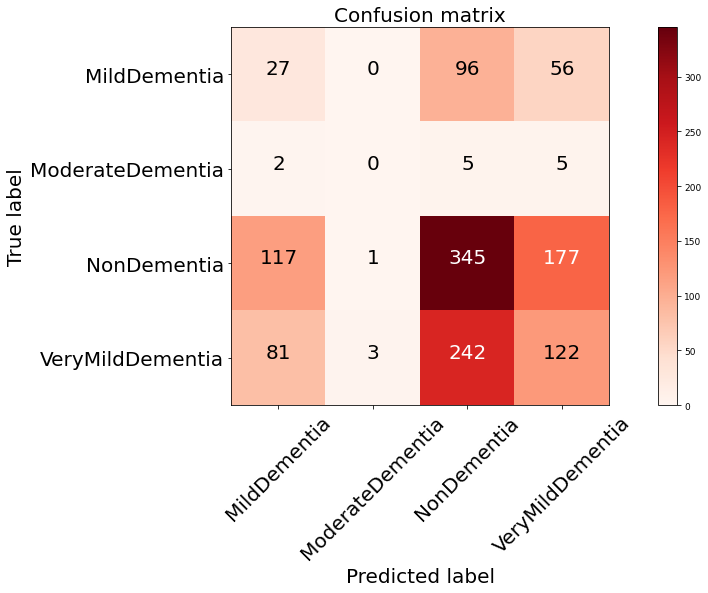

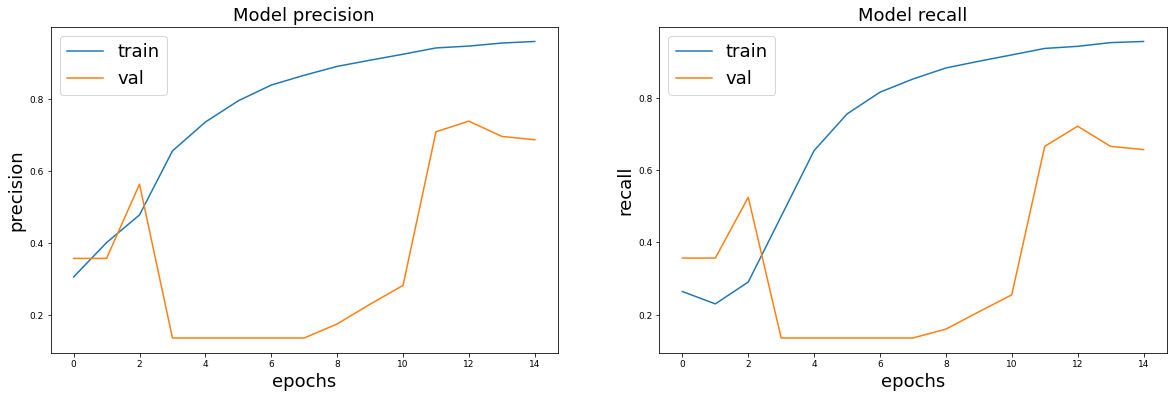

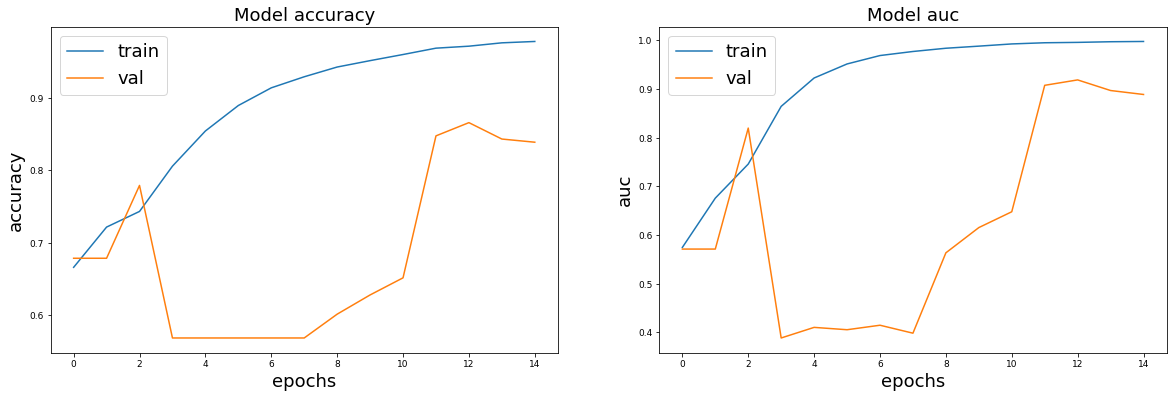

In [54]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("CLAHE images  Accuracy: {:.2f}%".format(accuracy * 100))  
print("CLAHE images  (radius 35)   Loss: {:.2f}".format(loss))  
print("CLAHE images  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 14s 1s/step - loss: 86.3216 - accuracy: 0.6751 - precision: 0.3503 - recall: 0.3503 - auc: 0.5668
Noisy images  Accuracy: 67.51%
Noisy images  (radius 35)   Loss: 86.32
Noisy images  Recall 35.03%, Area under the Curve (AUC) 56.68%
Confusion matrix, without normalization


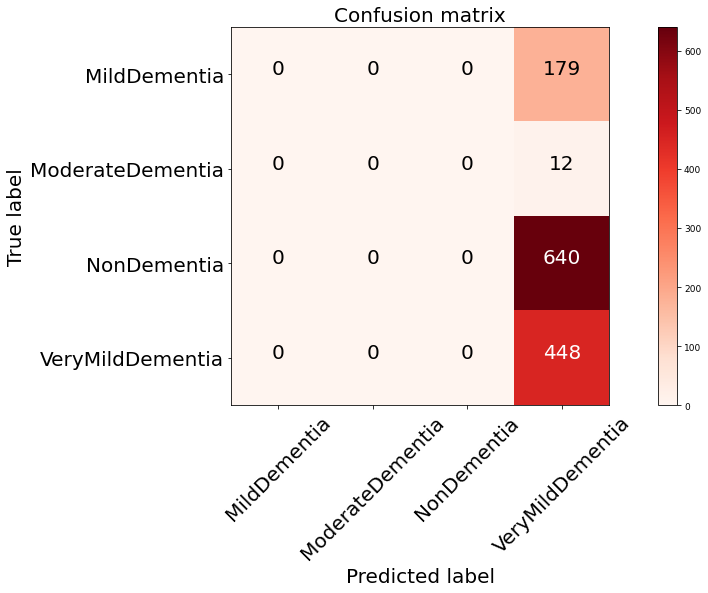

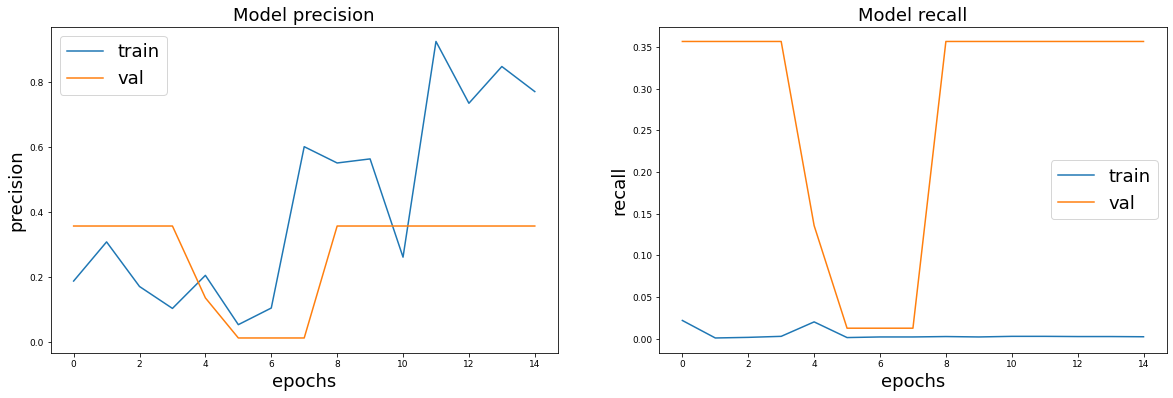

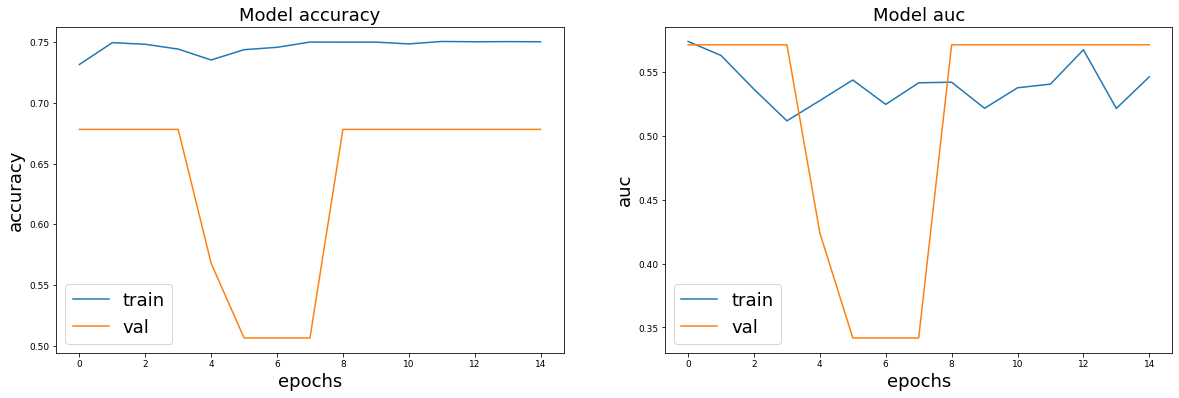

In [30]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Noisy images  Accuracy: {:.2f}%".format(accuracy * 100))  
print("Noisy images  (radius 35)   Loss: {:.2f}".format(loss))  
print("Noisy images  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 18s 1s/step - loss: 1.5488 - accuracy: 0.7297 - precision: 0.4573 - recall: 0.4355 - auc: 0.7604
Locally Equalised (radius 35)   Accuracy: 72.97%
Locally Equalised (radius 35)   Loss: 1.55
Locally Equalised (radius 35)   Recall 43.55%, Area under the Curve (AUC) 76.04%
Confusion matrix, without normalization


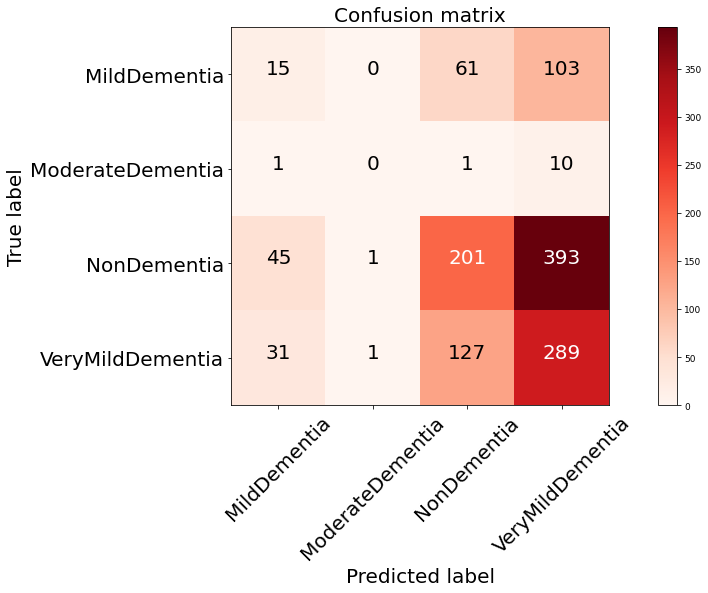

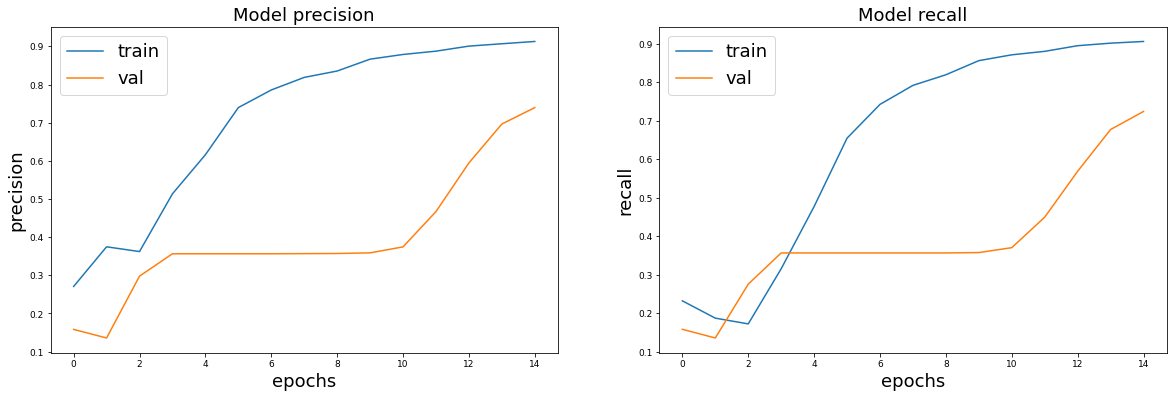

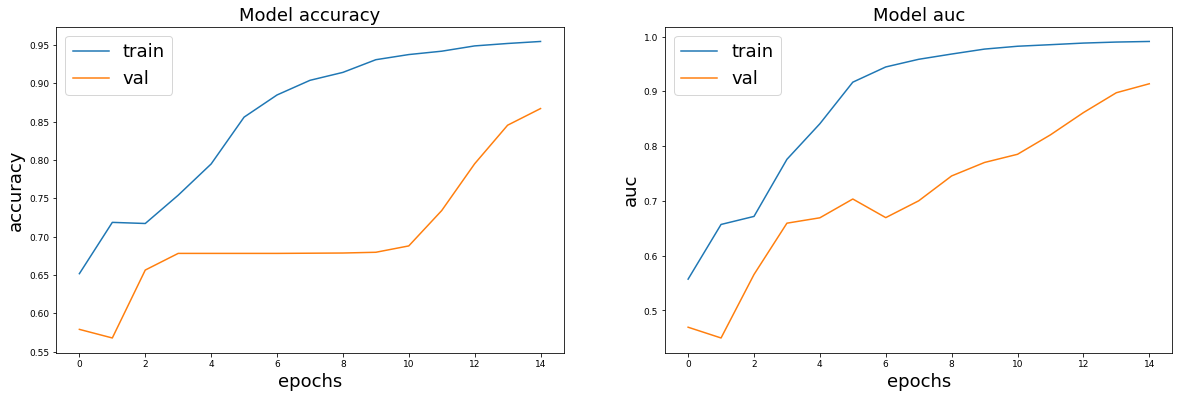

In [11]:
# Locally Equalised (radius 35) 
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Locally Equalised (radius 35)   Accuracy: {:.2f}%".format(accuracy * 100))  
print("Locally Equalised (radius 35)   Loss: {:.2f}".format(loss))  
print("Locally Equalised (radius 35)   Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

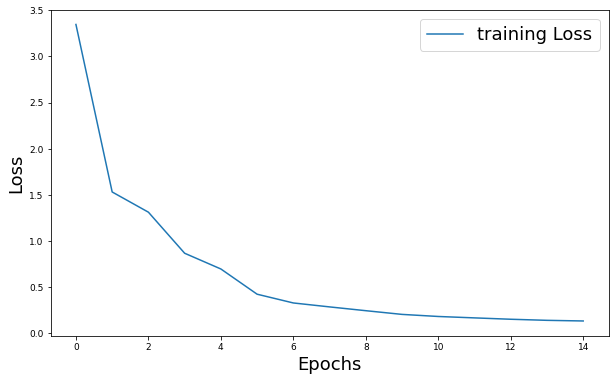

In [16]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.xlabel('Epochs',fontsize=18)
plt.ylabel( 'Loss',fontsize=18)
plt.legend(['training Loss', 'val'],fontsize=18)
plt.show()

13/13 [==============================] - 16s 1s/step - loss: 1.5430 - accuracy: 0.7723 - precision: 0.5454 - recall: 0.5356 - auc: 0.8039
Quantized Bi-Histogram Equalization (QBHE)  Accuracy: 77.23%
Quantized Bi-Histogram Equalization (QBHE)  Loss: 1.54
Quantized Bi-Histogram Equalization (QBHE)  Recall 53.56%, Area under the Curve (AUC) 80.39%
Confusion matrix, without normalization


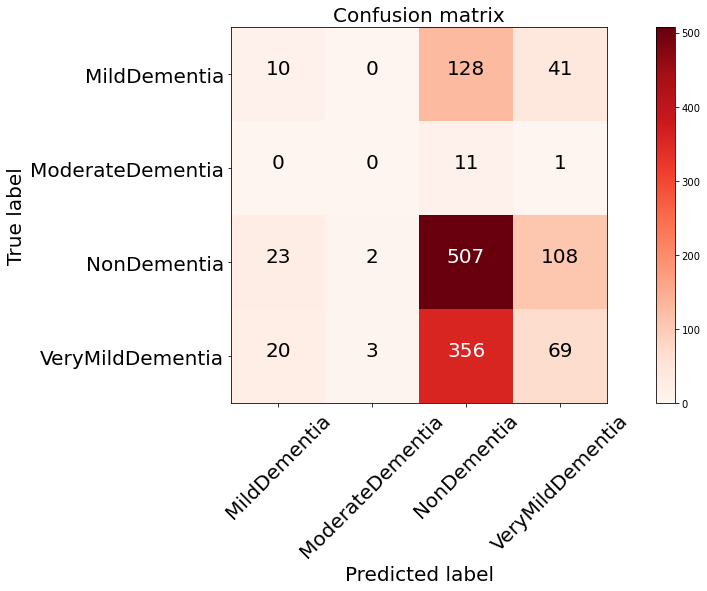

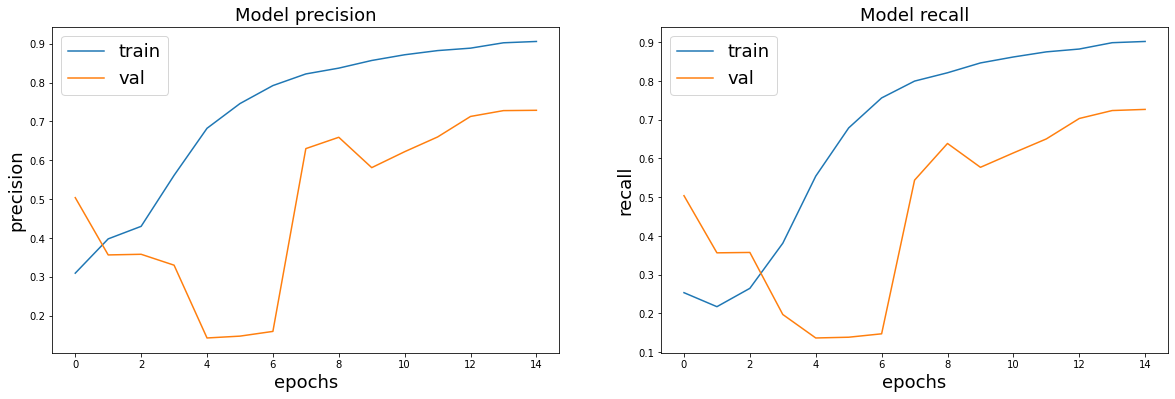

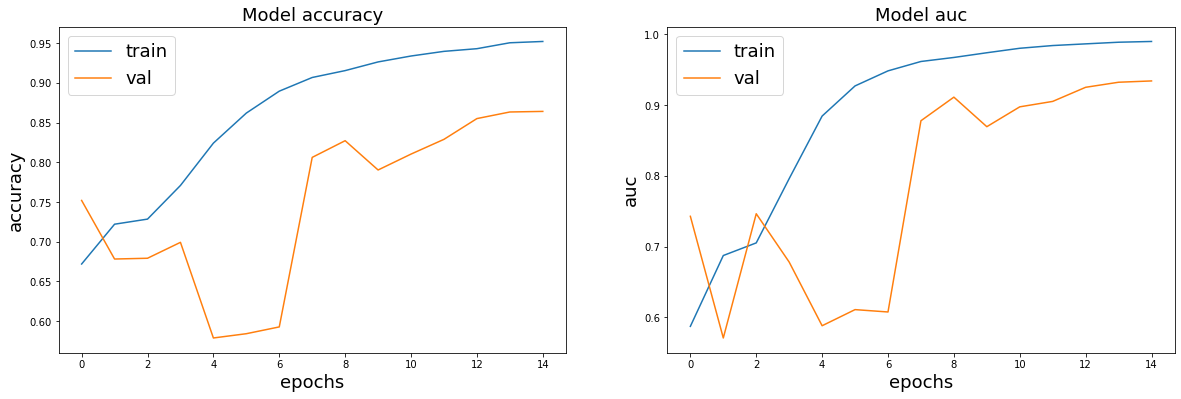

In [28]:
# Quantized Bi-Histogram Equalization (QBHE) 
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Quantized Bi-Histogram Equalization (QBHE)  Accuracy: {:.2f}%".format(accuracy * 100))  
print("Quantized Bi-Histogram Equalization (QBHE)  Loss: {:.2f}".format(loss))  
print("Quantized Bi-Histogram Equalization (QBHE)  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 17s 1s/step - loss: 2.1601 - accuracy: 0.7115 - precision: 0.4218 - recall: 0.4152 - auc: 0.7219
Recursive Sub-Image Histogram Equalization (RSIHE) Accuracy: 71.15%
Recursive Sub-Image Histogram Equalization (RSIHE) Loss: 2.16
Recursive Sub-Image Histogram Equalization (RSIHE) Recall 41.52%, Area under the Curve (AUC) 72.19%
Confusion matrix, without normalization


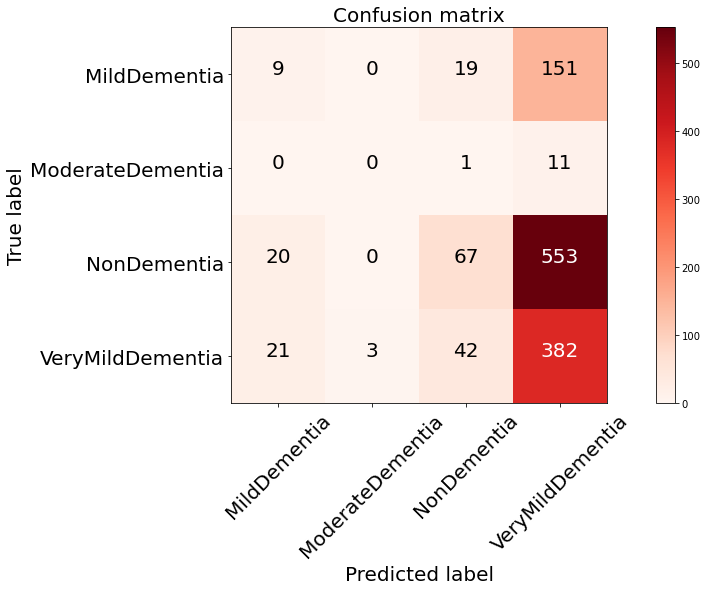

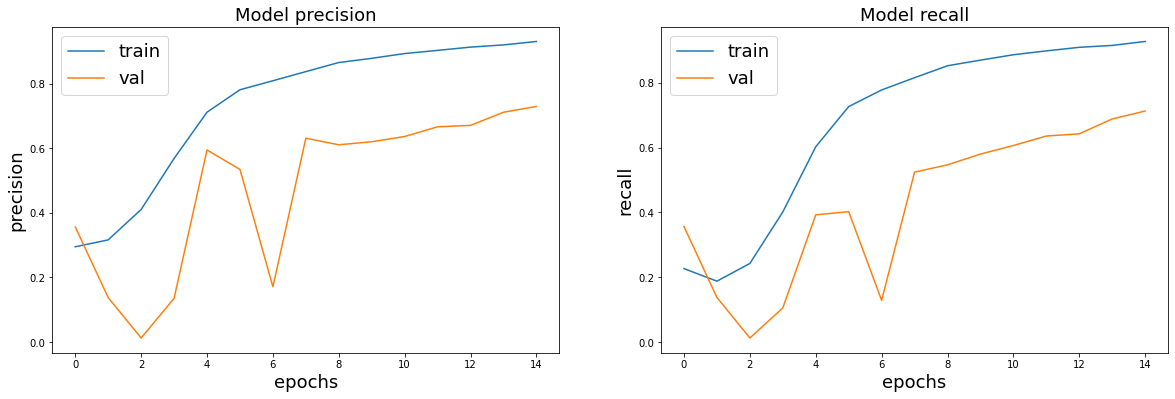

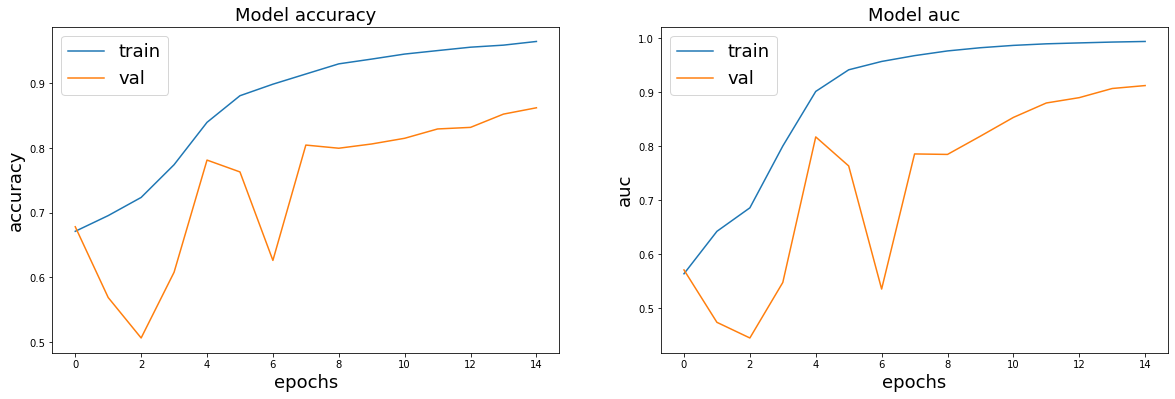

In [24]:
# Recursive Sub-Image Histogram Equalization (RSIHE)
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Recursive Sub-Image Histogram Equalization (RSIHE) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Recursive Sub-Image Histogram Equalization (RSIHE) Loss: {:.2f}".format(loss))  
print("Recursive Sub-Image Histogram Equalization (RSIHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 14s 1s/step - loss: 2.7641 - accuracy: 0.7179 - precision: 0.4358 - recall: 0.4355 - auc: 0.7370
Bi-Histogram Equalization with a Plateau Limit (BHEPL) Accuracy: 71.79%
Bi-Histogram Equalization with a Plateau Limit (BHEPL) Loss: 2.76
Bi-Histogram Equalization with a Plateau Limit (BHEPL) Recall 43.55%, Area under the Curve (AUC) 73.70%
Confusion matrix, without normalization


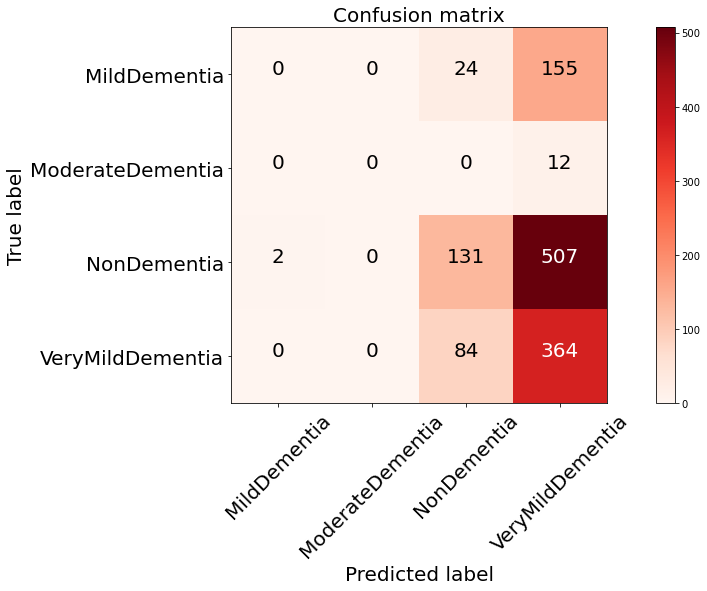

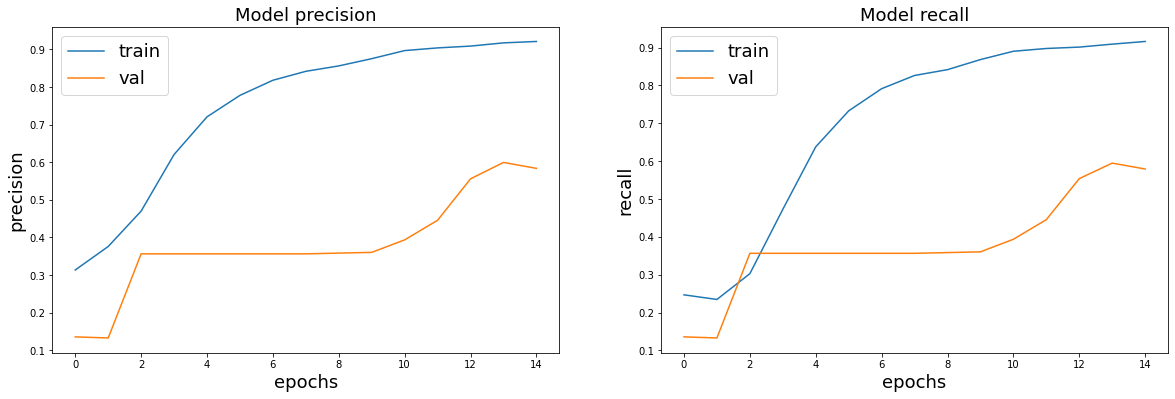

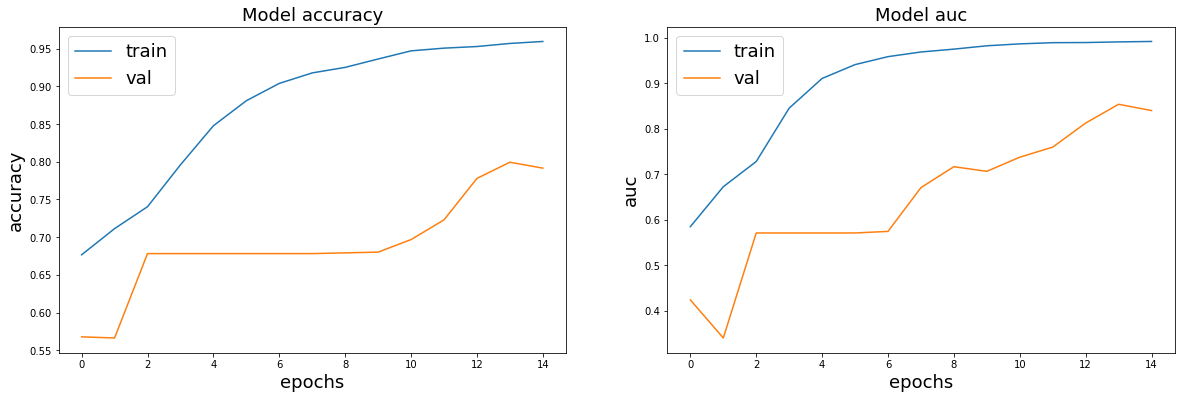

In [20]:
# Bi-Histogram Equalization with a Plateau Limit (BHEPL)
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Bi-Histogram Equalization with a Plateau Limit (BHEPL) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Bi-Histogram Equalization with a Plateau Limit (BHEPL) Loss: {:.2f}".format(loss))  
print("Bi-Histogram Equalization with a Plateau Limit (BHEPL) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 17s 1s/step - loss: 1.2005 - accuracy: 0.7725 - precision: 0.5469 - recall: 0.5246 - auc: 0.8178
Brightness-preserving 
Bi-Histogram Equalization (BBHE) Accuracy: 77.25%
Brightness-preserving 
Bi-Histogram Equalization (BBHE) Loss: 1.20
Brightness-preserving 
Bi-Histogram Equalization (BBHE) Recall 52.46%, Area under the Curve (AUC) 81.78%
Confusion matrix, without normalization


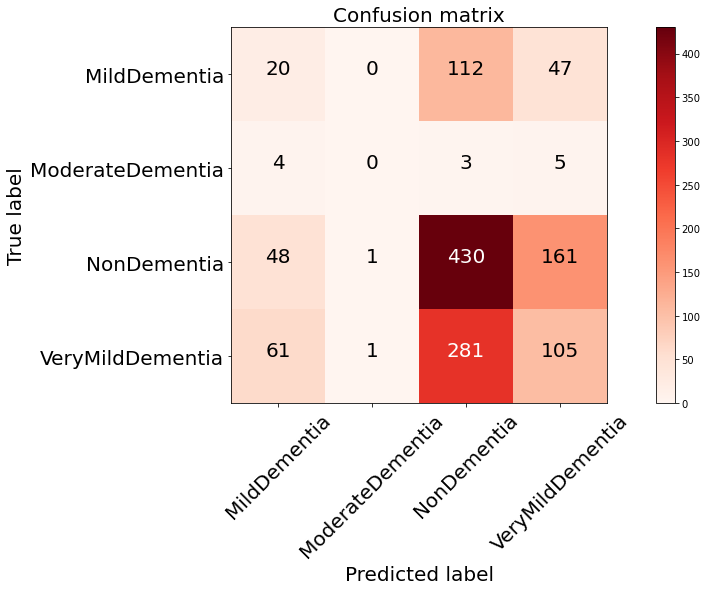

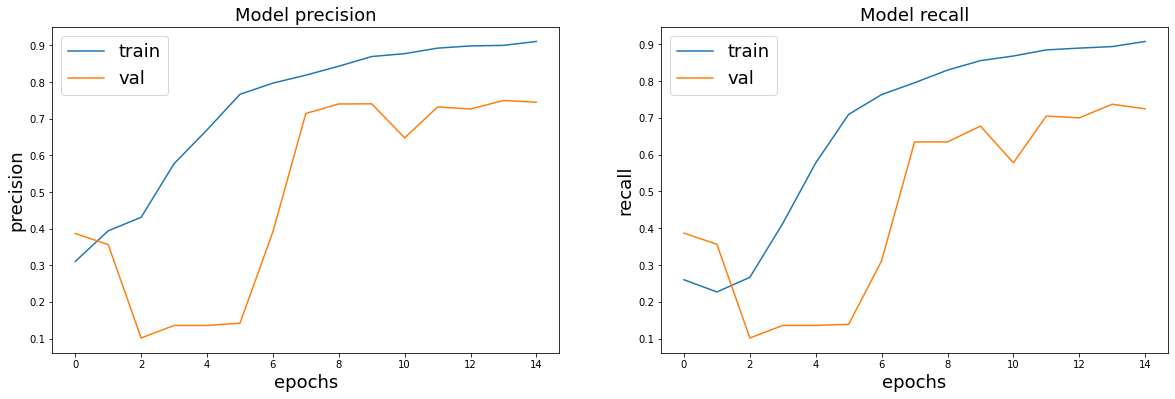

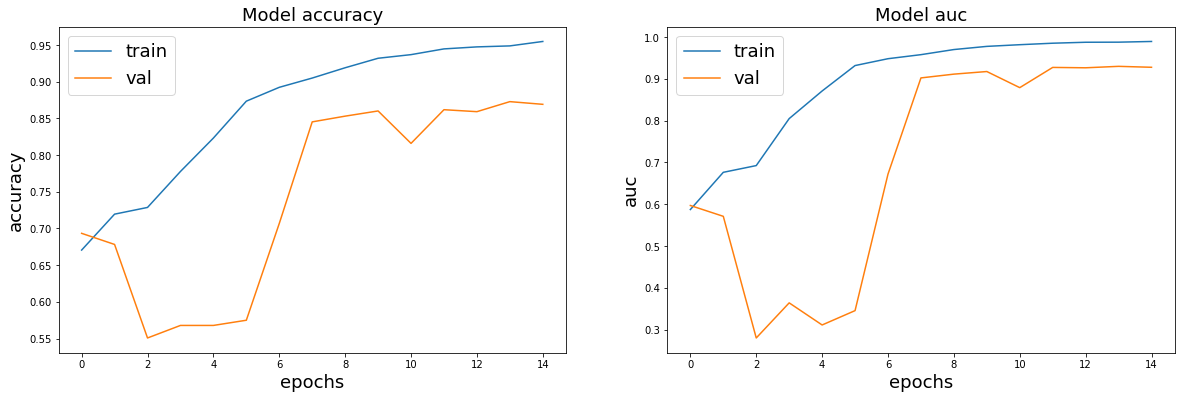

In [16]:
# Brightness-preserving \nBi-Histogram Equalization (BBHE)
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Brightness-preserving Bi-Histogram Equalization (BBHE) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Brightness-preserving Bi-Histogram Equalization (BBHE) Loss: {:.2f}".format(loss))  
print("Brightness-preserving Bi-Histogram Equalization (BBHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 15s 1s/step - loss: 1.7857 - accuracy: 0.7533 - precision: 0.5076 - recall: 0.4418 - auc: 0.7482
Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Accuracy: 75.33%
Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Loss: 1.79
Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Recall 44.18%, Area under the Curve (AUC) 74.82%
Confusion matrix, without normalization


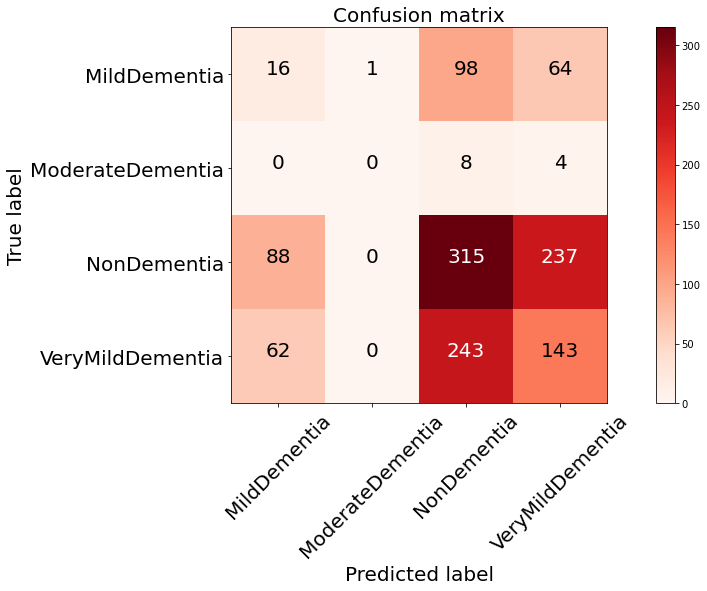

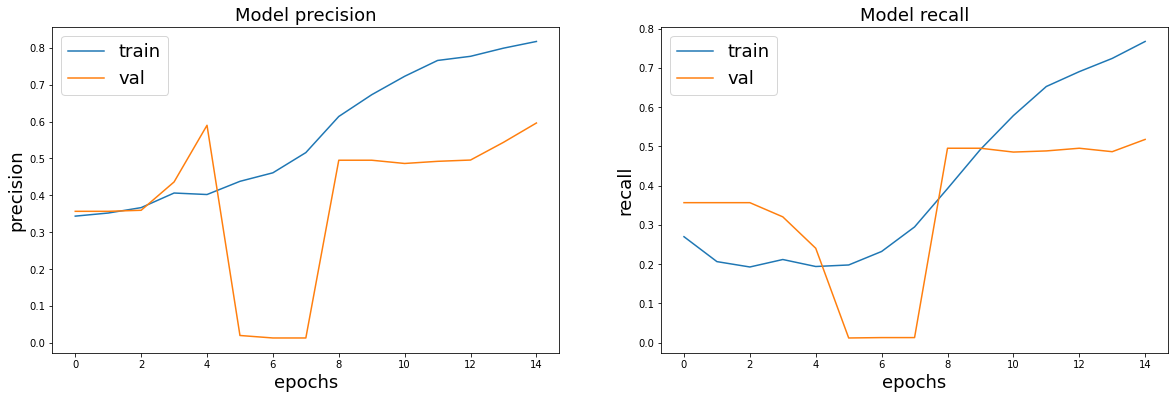

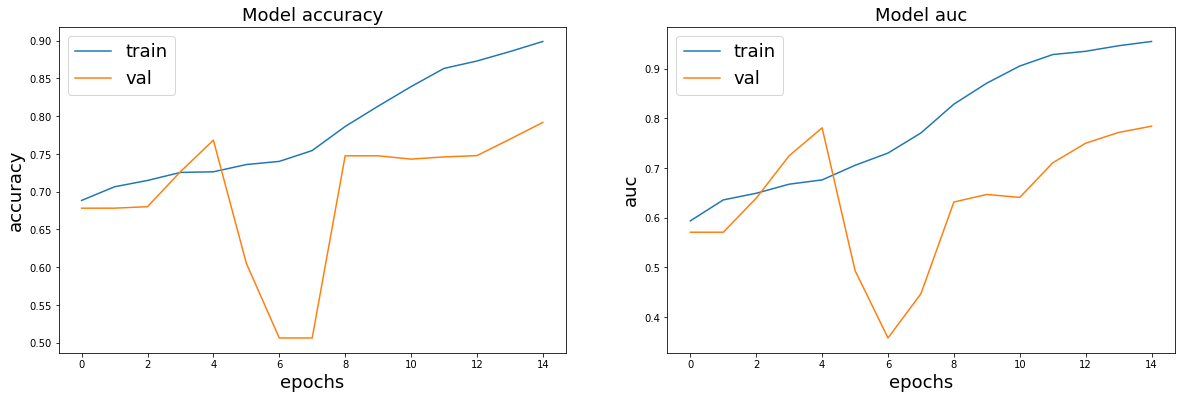

In [11]:
# Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP)

loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Loss: {:.2f}".format(loss))  
print("Flattest Histogram Specification with Accurate Brightness Preservation (FHSABP) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 15s 1s/step - loss: 1.3002 - accuracy: 0.7643 - precision: 0.5328 - recall: 0.4636 - auc: 0.7777
Weighted Thresholded Histogram Equalization (WTHE) Accuracy: 76.43%
Weighted Thresholded Histogram Equalization (WTHE) Loss: 1.30
Weighted Thresholded Histogram Equalization (WTHE) Recall 46.36%, Area under the Curve (AUC) 77.77%
Confusion matrix, without normalization


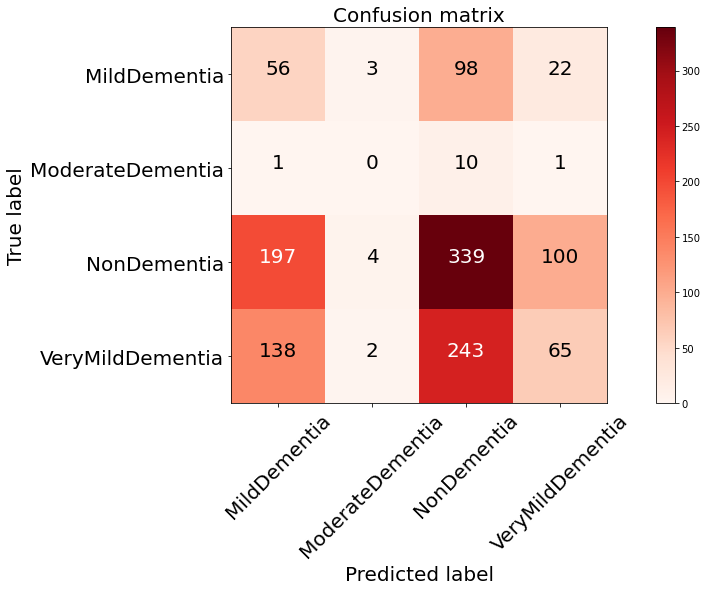

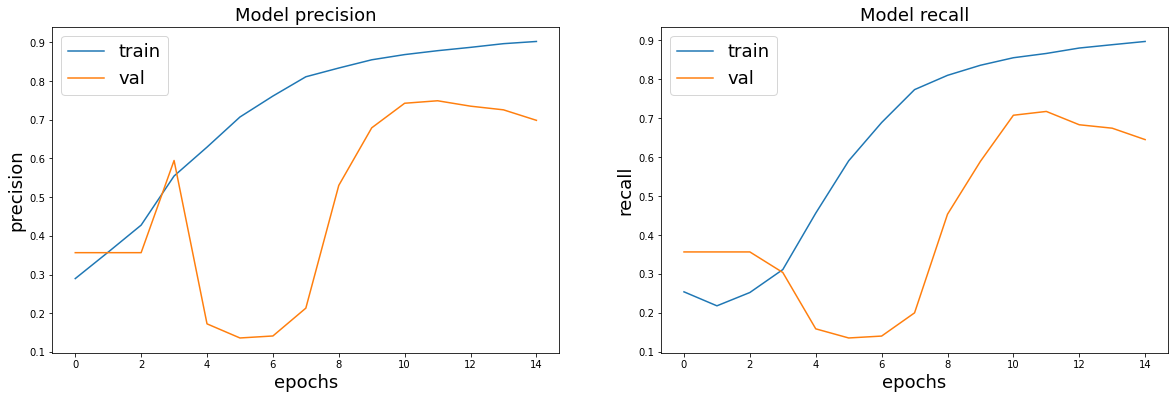

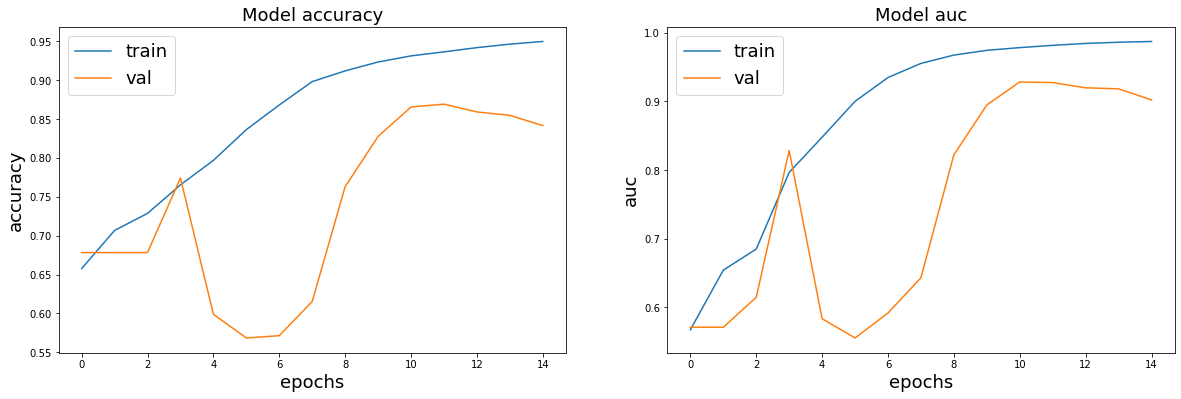

In [7]:
# Weighted Thresholded Histogram Equalization (WTHE)
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Weighted Thresholded Histogram Equalization (WTHE) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Weighted Thresholded Histogram Equalization (WTHE) Loss: {:.2f}".format(loss))  
print("Weighted Thresholded Histogram Equalization (WTHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 15s 1s/step - loss: 6.2964 - accuracy: 0.5704 - precision: 0.1402 - recall: 0.1400 - auc: 0.4622
Range Limited Bi-Histogram Equalization (RLBHE) Accuracy: 57.04%
Range Limited Bi-Histogram Equalization (RLBHE) Loss: 6.30
Range Limited Bi-Histogram Equalization (RLBHE) Recall 14.00%, Area under the Curve (AUC) 46.22%
Confusion matrix, without normalization


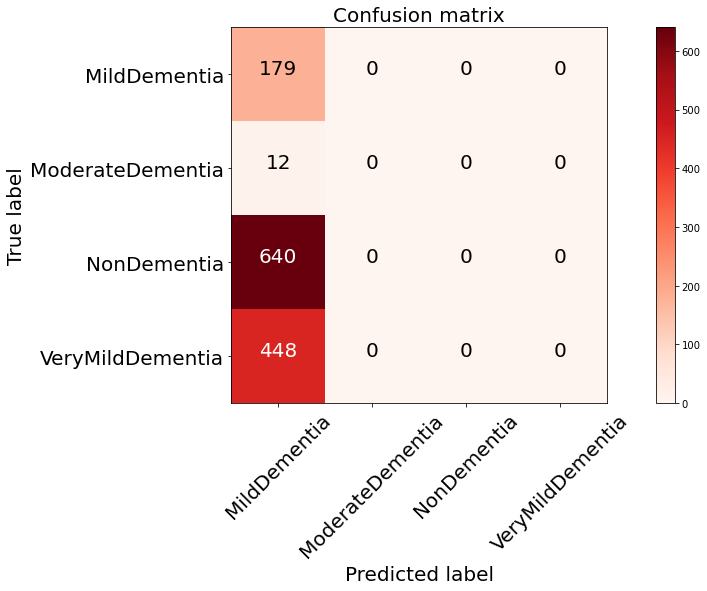

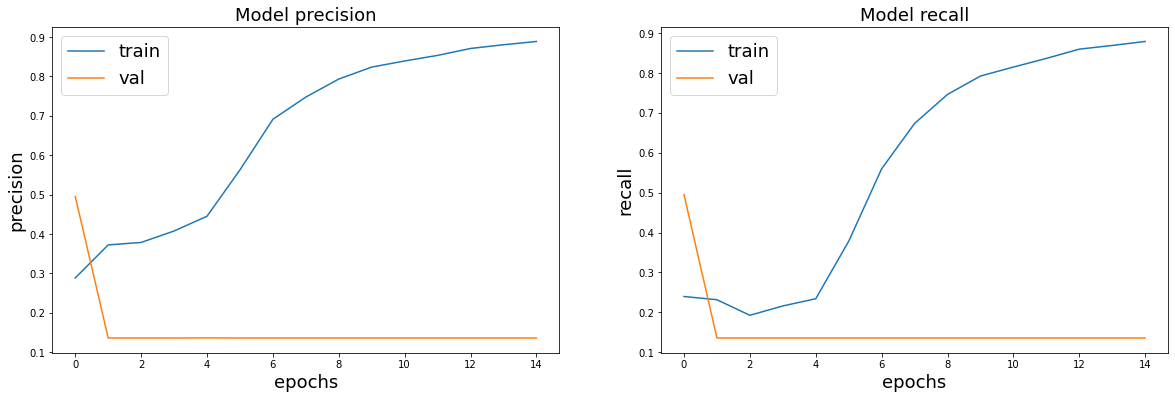

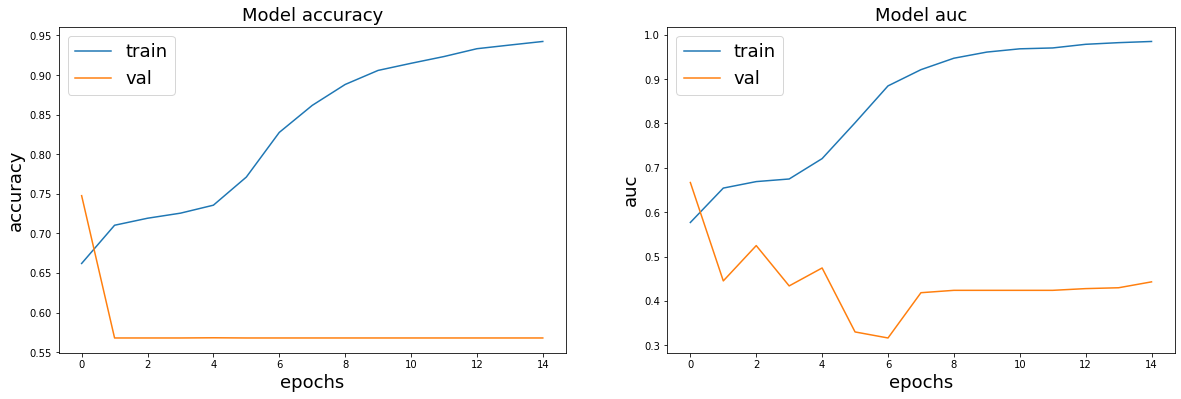

In [11]:
#Range Limited Bi-Histogram Equalization (RLBHE)
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Range Limited Bi-Histogram Equalization (RLBHE) Accuracy: {:.2f}%".format(accuracy * 100))  
print("Range Limited Bi-Histogram Equalization (RLBHE) Loss: {:.2f}".format(loss))  
print("Range Limited Bi-Histogram Equalization (RLBHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 14s 1s/step - loss: 1.2093 - accuracy: 0.7355 - precision: 0.4621 - recall: 0.3526 - auc: 0.7578
 Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME) Accuracy: 73.55%
 Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME)Loss: 1.21
Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME) Recall 35.26%, Area under the Curve (AUC) 75.78%
Confusion matrix, without normalization


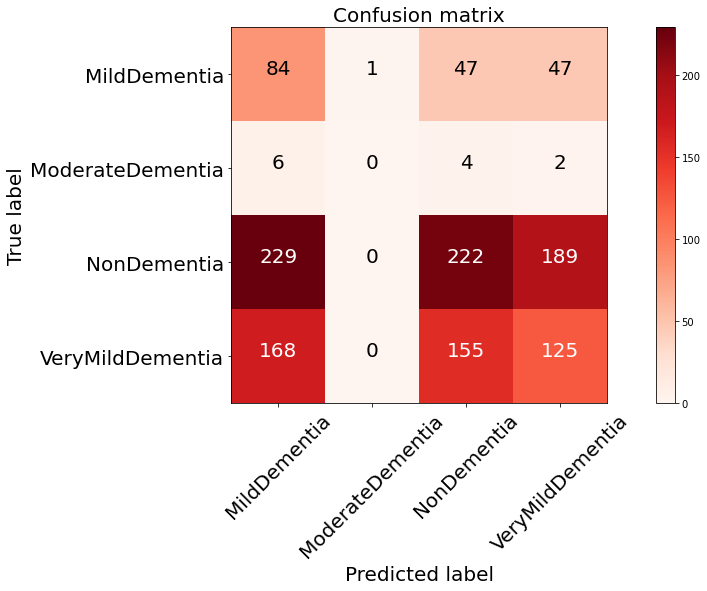

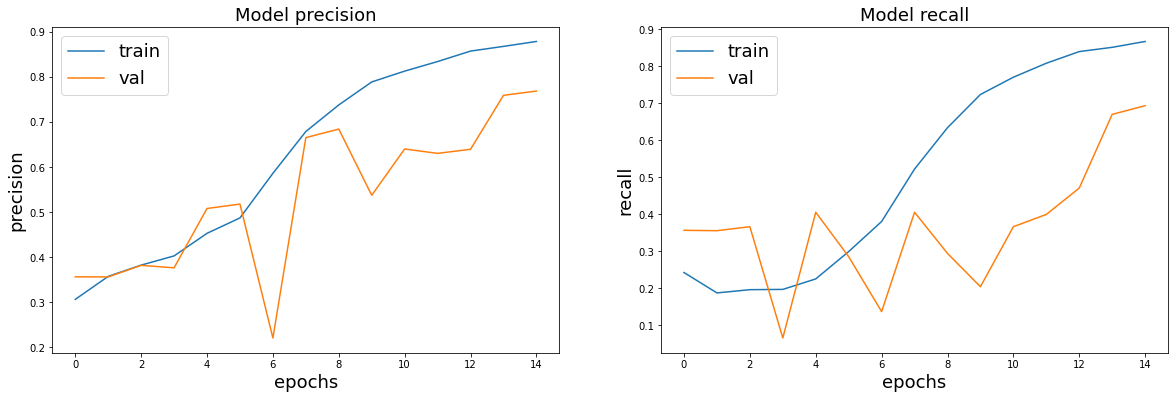

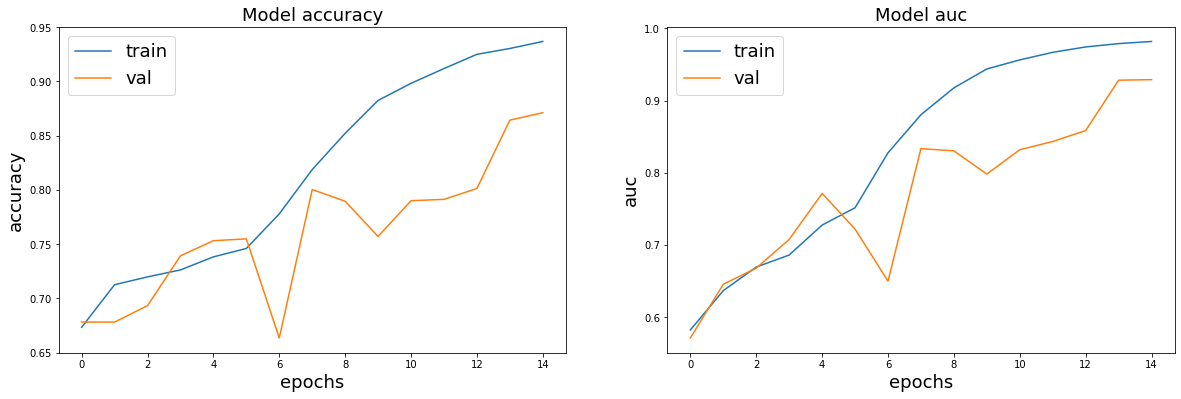

In [7]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print(" Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME) Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME)Loss: {:.2f}".format(loss))  
print("Brightness Preserving Histogram Equalization with Maximum Entropy (BPHEME) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 17s 1s/step - loss: 2882.0745 - accuracy: 0.6751 - precision: 0.3503 - recall: 0.3503 - auc: 0.5668
 Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Accuracy: 67.51%
 Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Loss: 2882.07
 Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Recall 35.03%, Area under the Curve (AUC) 56.68%
Confusion matrix, without normalization


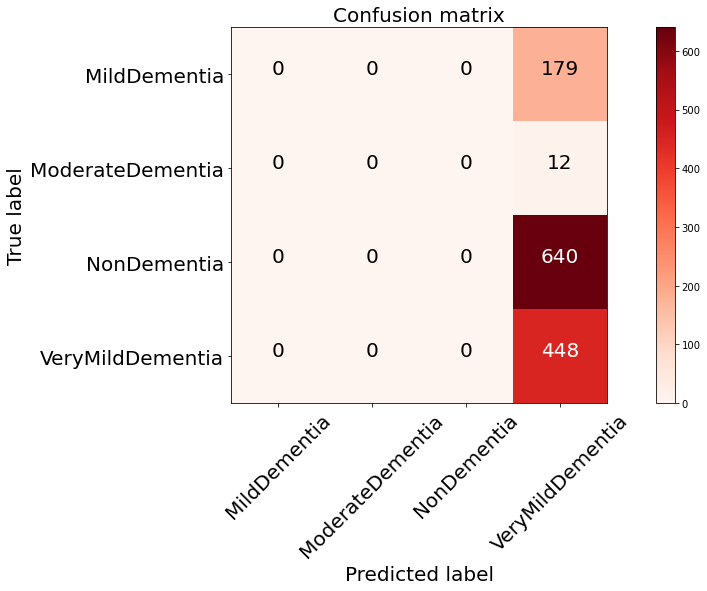

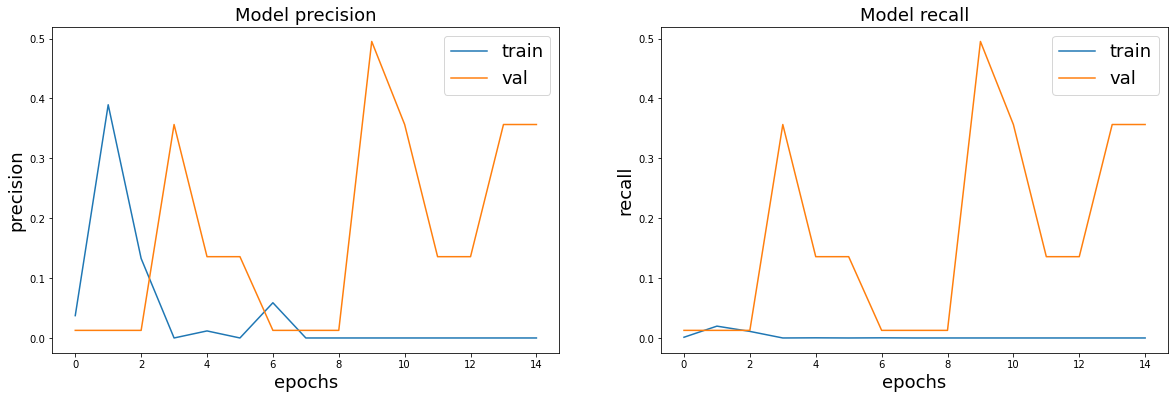

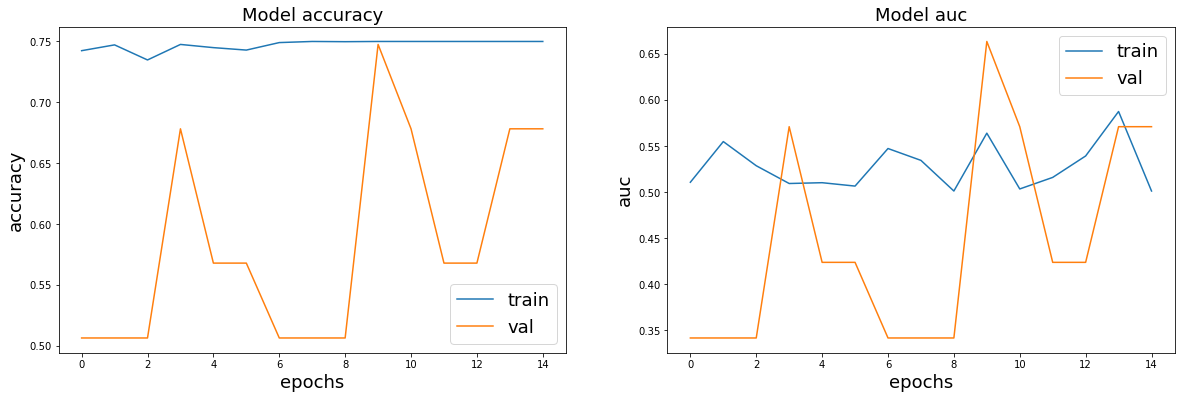

In [19]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print(" Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Loss: {:.2f}".format(loss))  
print(" Adaptive Gamma Correction Color Preserving Framework (AGCCPF) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 15s 1s/step - loss: 1.5762 - accuracy: 0.7527 - precision: 0.5056 - recall: 0.4902 - auc: 0.7851
  Dualistic Sub-Image Histogram Equalization (DSIHE) Accuracy: 75.27%
 Dualistic Sub-Image Histogram Equalization (DSIHE) Loss: 1.58
 Dualistic Sub-Image Histogram Equalization (DSIHE) Recall 49.02%, Area under the Curve (AUC) 78.51%
Confusion matrix, without normalization


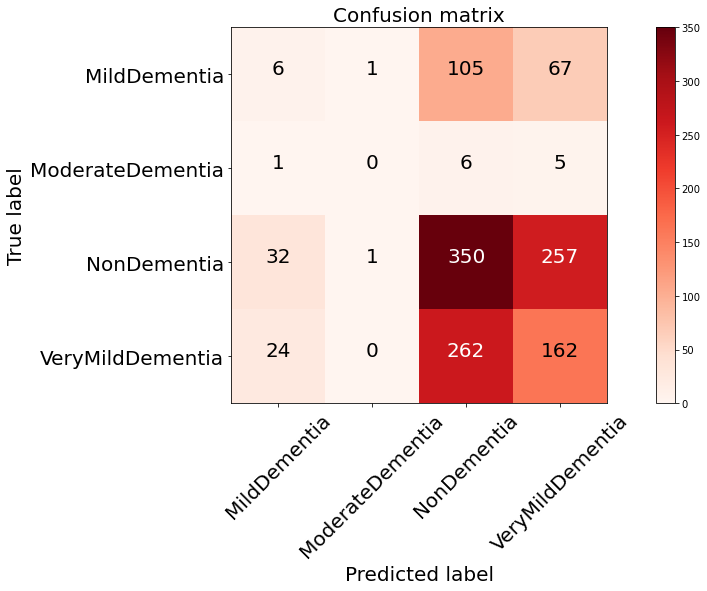

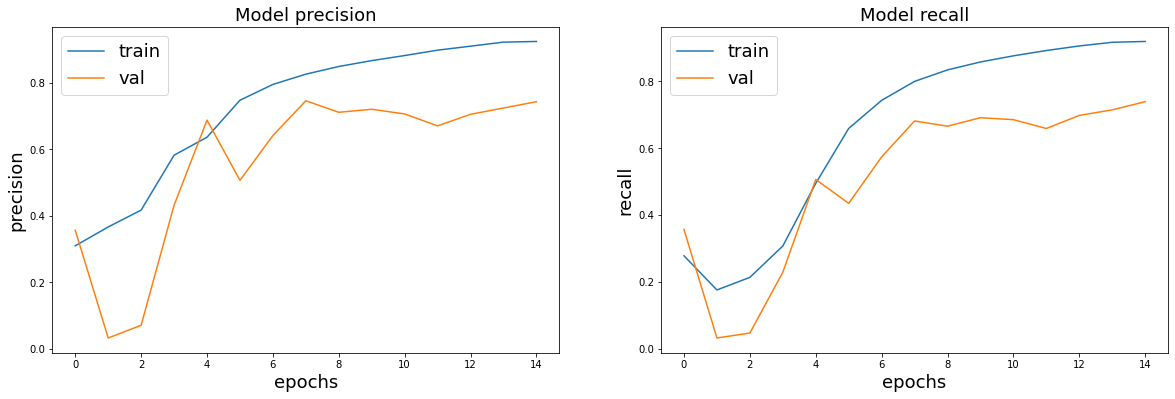

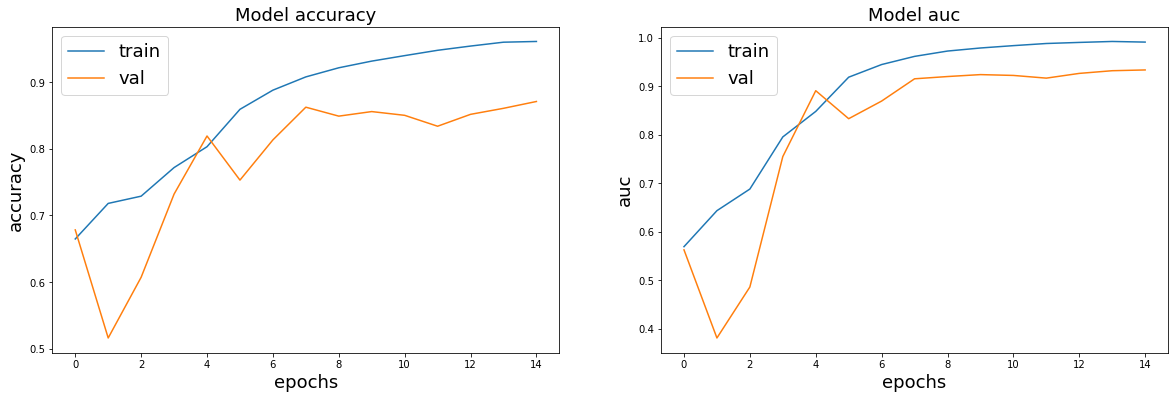

In [14]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print(" Dualistic Sub-Image Histogram Equalization (DSIHE) Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Dualistic Sub-Image Histogram Equalization (DSIHE) Loss: {:.2f}".format(loss))  
print(" Dualistic Sub-Image Histogram Equalization (DSIHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 17s 1s/step - loss: 1.9253 - accuracy: 0.7502 - precision: 0.5004 - recall: 0.5004 - auc: 0.7104
  (15%) Noisy Images Accuracy: 75.02%
 (15%) Noisy Images Loss: 1.93
 (15%) Noisy Images Recall 50.04%, Area under the Curve (AUC) 71.04%
Confusion matrix, without normalization


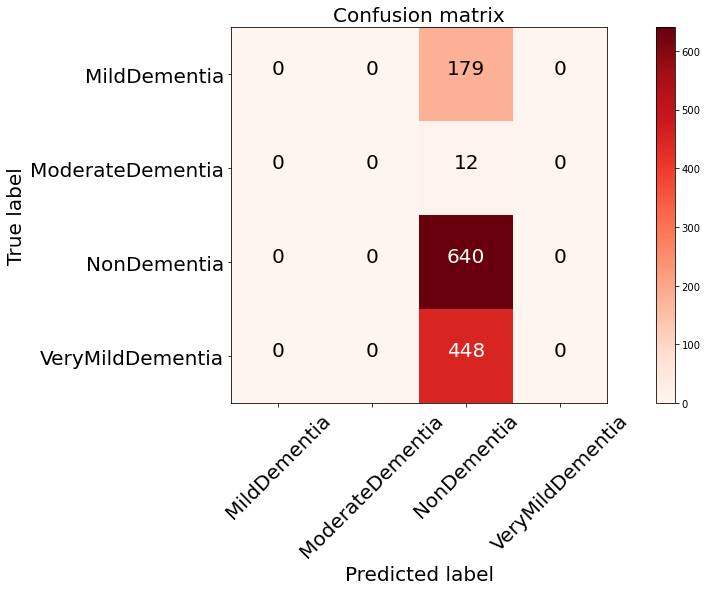

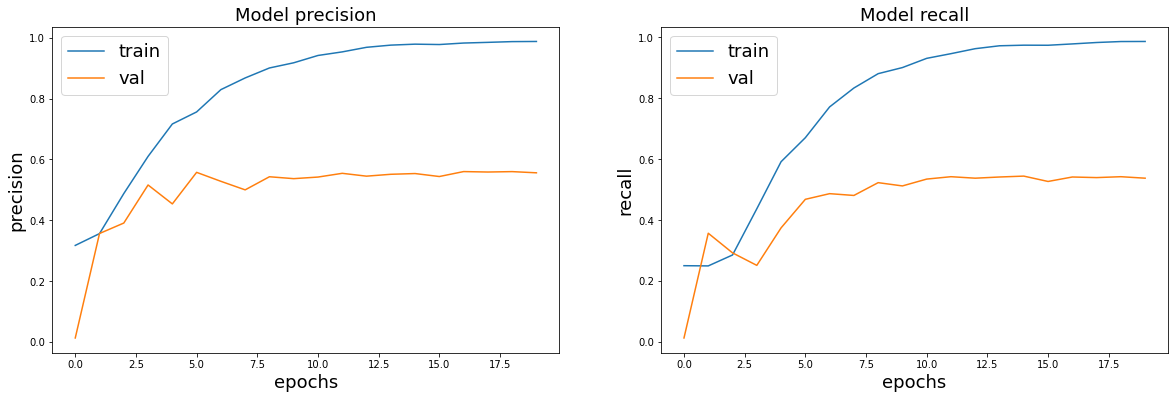

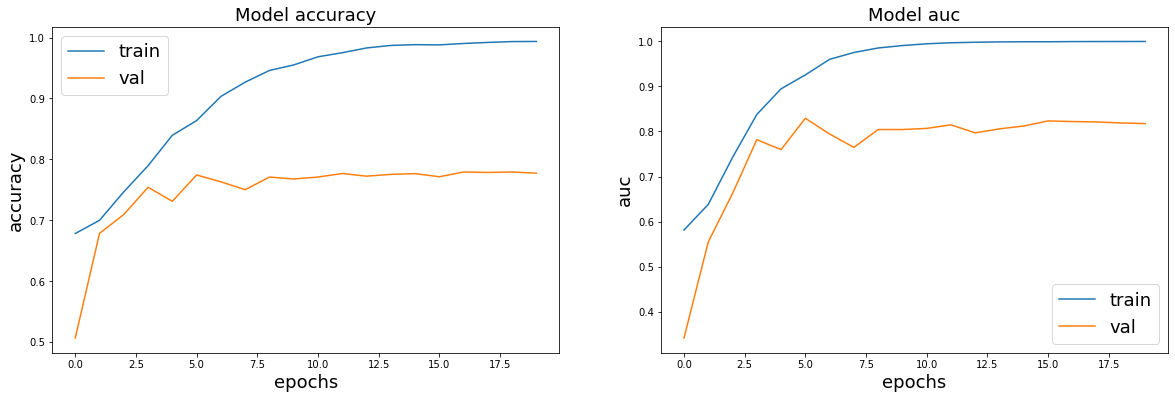

In [9]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("  (15%) Noisy Images Accuracy: {:.2f}%".format(accuracy * 100))  
print(" (15%) Noisy Images Loss: {:.2f}".format(loss))  
print(" (15%) Noisy Images Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 18s 1s/step - loss: 1.5622 - accuracy: 0.8129 - precision: 0.6278 - recall: 0.6185 - auc: 0.8436
  Logarithmic Corrected Accuracy: 81.29%
 Logarithmic Corrected Loss: 1.56
 Logarithmic Corrected Recall 61.85%, Area under the Curve (AUC) 84.36%
Confusion matrix, without normalization


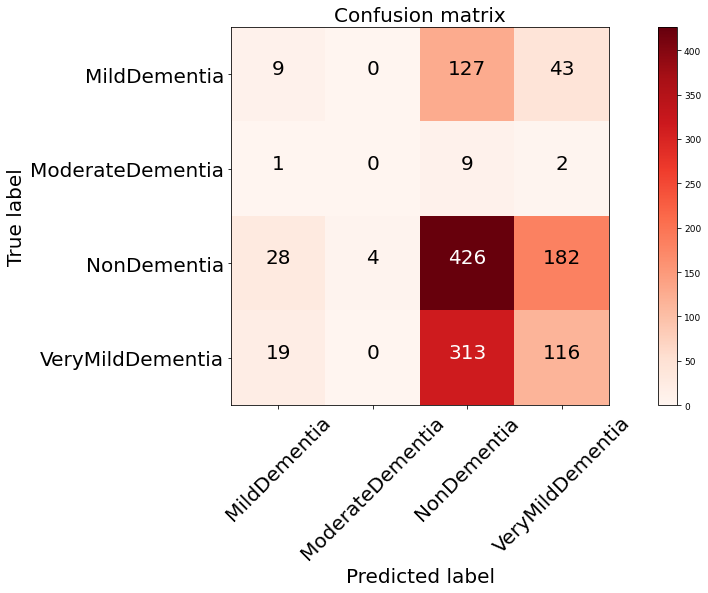

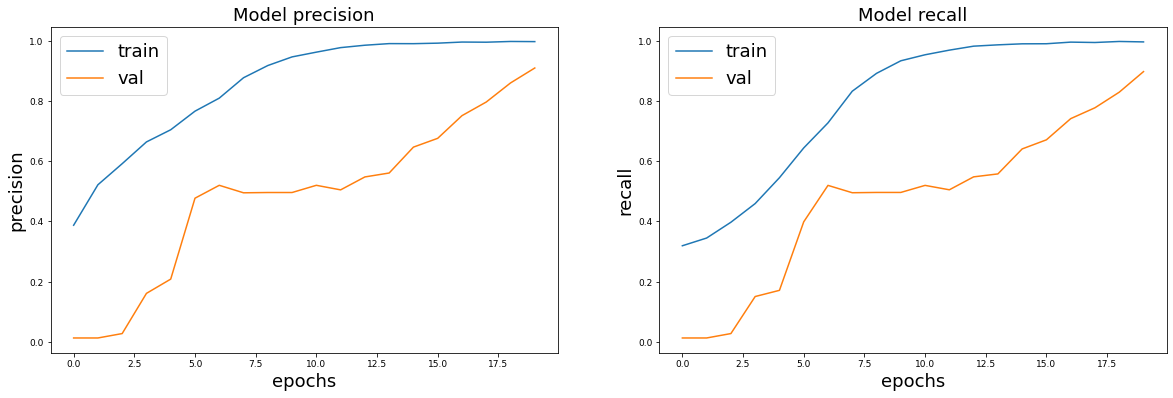

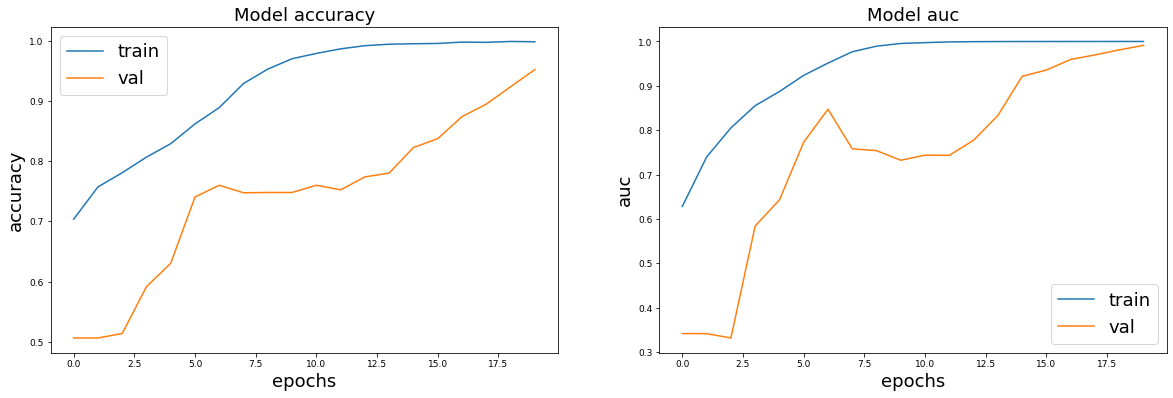

In [25]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("  Logarithmic Corrected Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Logarithmic Corrected Loss: {:.2f}".format(loss))  
print(" Logarithmic Corrected Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 20s 1s/step - loss: 1.4449 - accuracy: 0.8315 - precision: 0.6667 - recall: 0.6521 - auc: 0.8595
  Logarithmic Corrected Accuracy: 83.15%
 Logarithmic Corrected Loss: 1.44
 Logarithmic Corrected Recall 65.21%, Area under the Curve (AUC) 85.95%
Confusion matrix, without normalization


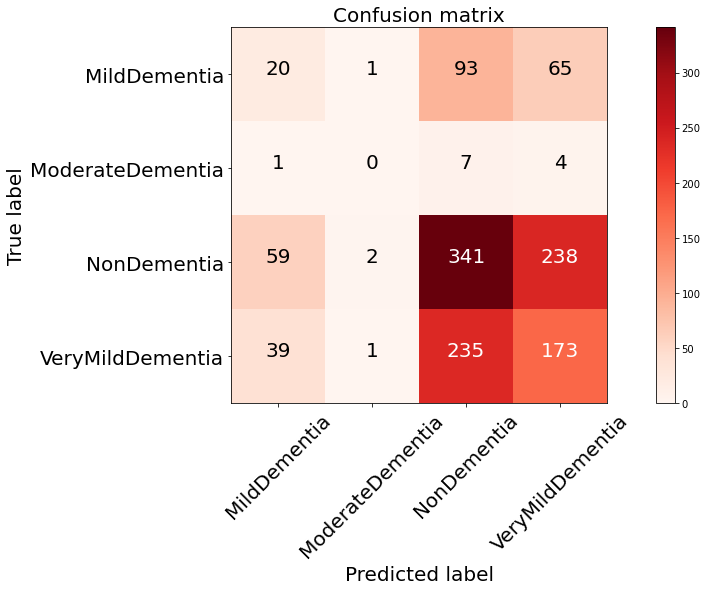

In [11]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("  Logarithmic Corrected Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Logarithmic Corrected Loss: {:.2f}".format(loss))  
print(" Logarithmic Corrected Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 18s 1s/step - loss: 1.6907 - accuracy: 0.7494 - precision: 0.4987 - recall: 0.4605 - auc: 0.7494
  Discrete Cosine Transform (DCT) Accuracy: 74.94%
 Discrete Cosine Transform (DCT)  Loss: 1.69
 Discrete Cosine Transform (DCT)  Recall 46.05%, Area under the Curve (AUC) 74.94%
Confusion matrix, without normalization


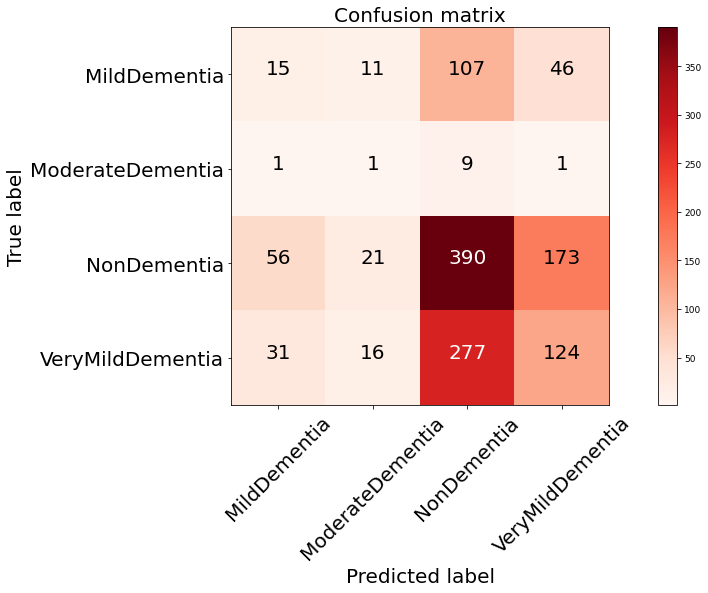

In [21]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("  Discrete Cosine Transform (DCT) Accuracy: {:.2f}%".format(accuracy * 100))  
print(" Discrete Cosine Transform (DCT)  Loss: {:.2f}".format(loss))  
print(" Discrete Cosine Transform (DCT)  Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 1.2097 - accuracy: 0.8104 - precision: 0.6259 - recall: 0.6005 - auc: 0.8514
 Accuracy: 81.04%
  Loss: 1.21
 Recall 60.05%, Area under the Curve (AUC) 85.14%
Confusion matrix, without normalization


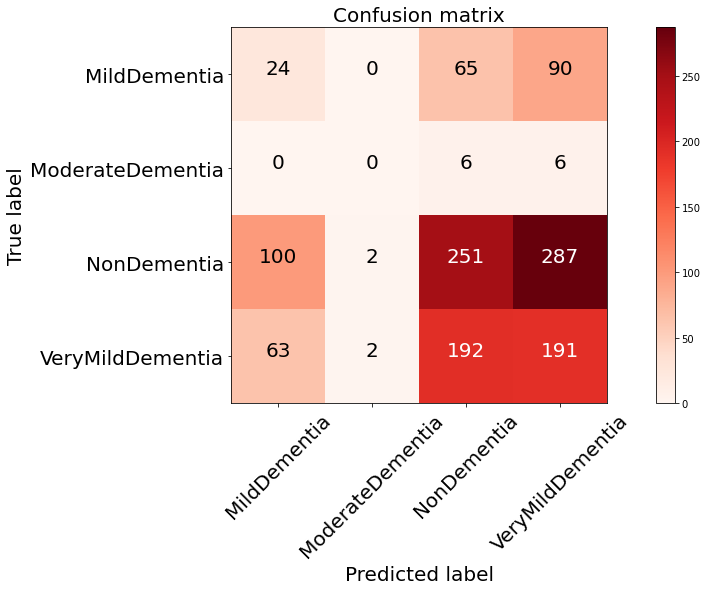

In [5]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print(" Accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print(" Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

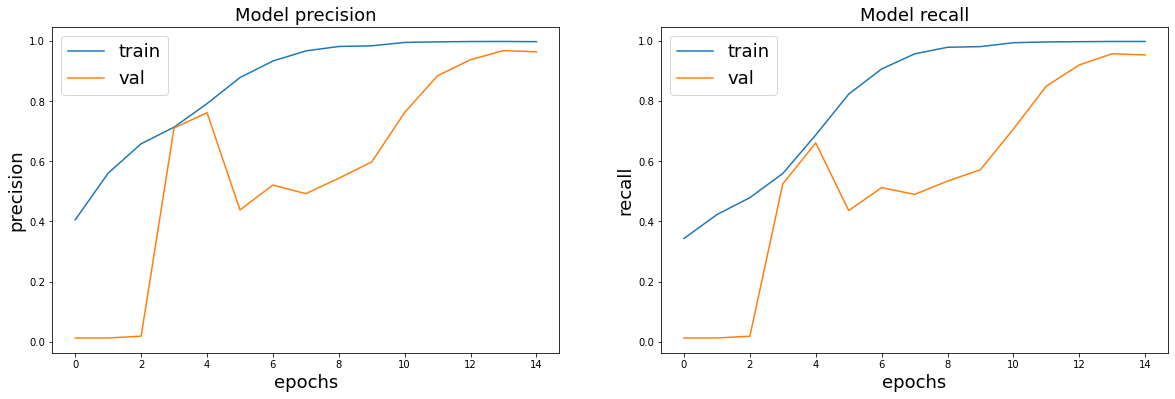

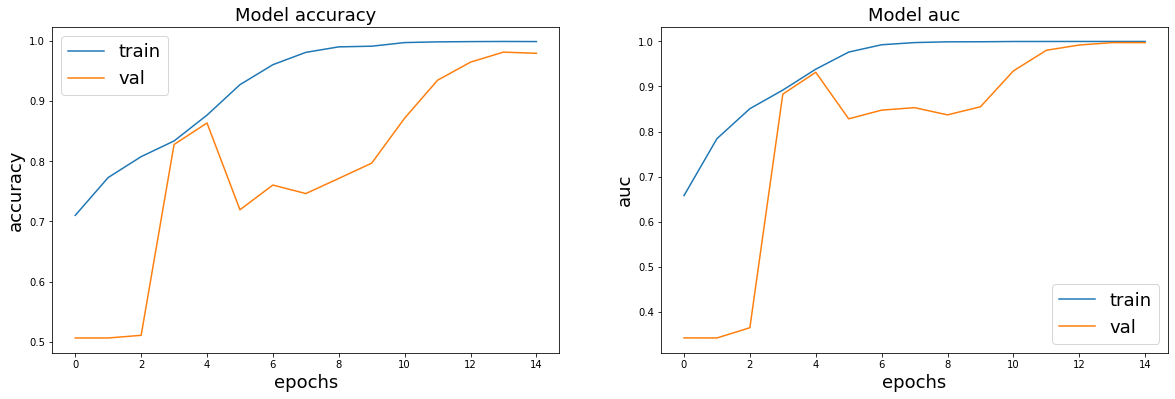

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 12s 895ms/step - loss: 2.1239 - accuracy: 0.7269 - precision: 0.4513 - recall: 0.4277 - auc: 0.7136
Log Adjusted HE with hyperparameter 2 accuracy: 72.69%
Log Adjusted HE with hyperparameter 2 Loss: 2.12
Log Adjusted HE with hyperparameter 2 Recall 42.77%, Area under the Curve (AUC) 71.36%
Confusion matrix, without normalization


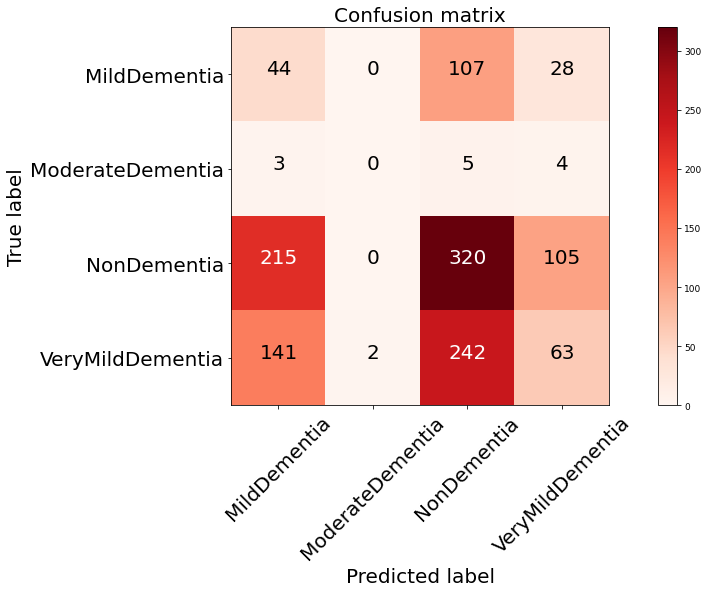

In [11]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Log Adjusted HE with hyperparameter 2 accuracy: {:.2f}%".format(accuracy * 100))  
print("Log Adjusted HE with hyperparameter 2 Loss: {:.2f}".format(loss))  
print("Log Adjusted HE with hyperparameter 2 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 1.4806 - accuracy: 0.7394 - precision: 0.4780 - recall: 0.4590 - auc: 0.7810
Log Adjusted HE with hyperparameter 2 accuracy: 73.94%
Log Adjusted HE with hyperparameter 2 Loss: 1.48
Log Adjusted HE with hyperparameter 2 Recall 45.90%, Area under the Curve (AUC) 78.10%
Confusion matrix, without normalization


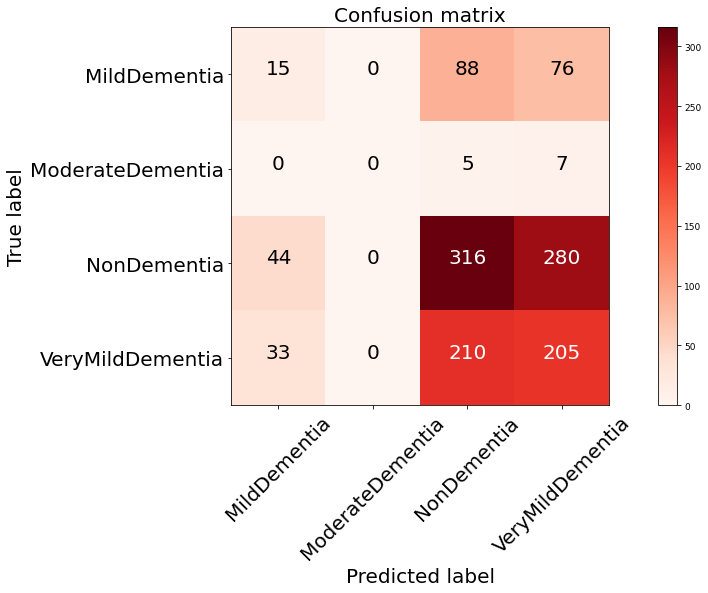

In [9]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(test_ds, batch_size= 23, verbose=1)

print("Log Adjusted HE with hyperparameter 2 accuracy: {:.2f}%".format(accuracy * 100))  
print("Log Adjusted HE with hyperparameter 2 Loss: {:.2f}".format(loss))  
print("Log Adjusted HE with hyperparameter 2 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 368.5585 - accuracy: 0.5047 - precision: 0.0094 - recall: 0.0094 - auc: 0.3396
Adaptive HE accuracy: 50.47%
Adaptive  HE Loss: 368.56
Adaptive  HE Recall 0.94%, Area under the Curve (AUC) 33.96%
Confusion matrix, without normalization


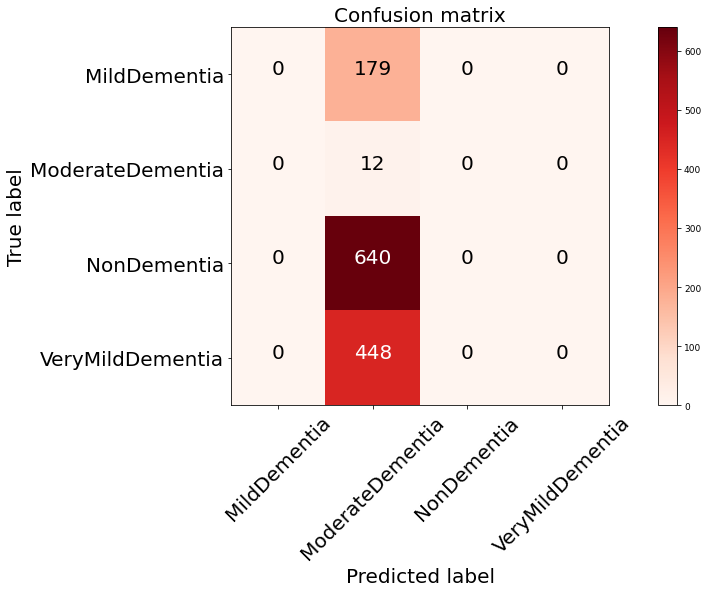

In [20]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Adaptive HE accuracy: {:.2f}%".format(accuracy * 100))  
print("Adaptive  HE Loss: {:.2f}".format(loss))  
print("Adaptive  HE Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 16s 1s/step - loss: 1.3267 - accuracy: 0.7525 - precision: 0.5059 - recall: 0.4378 - auc: 0.7714
Fuzzy Logic HE with (7,7) kernel accuracy: 75.25%
Fuzzy Logic HE Loss: 1.33
Fuzzy Logic HE Recall 43.78%, Area under the Curve (AUC) 77.14%
Confusion matrix, without normalization


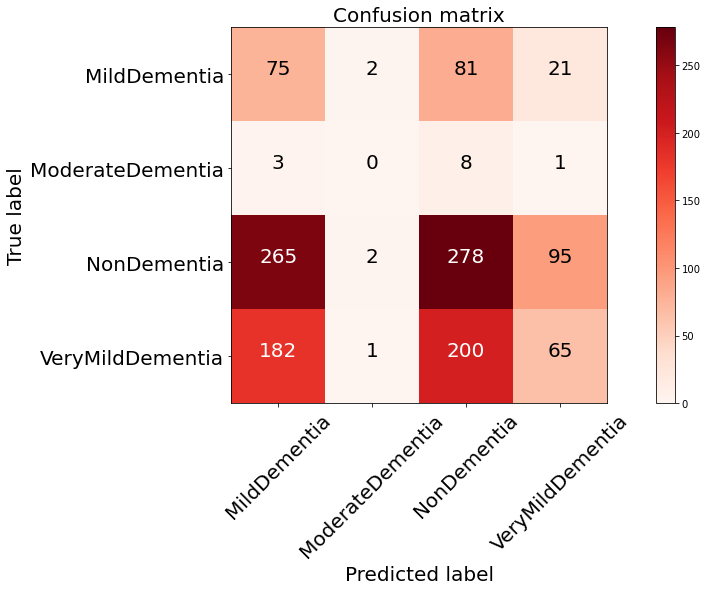

In [15]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Fuzzy Logic HE with (7,7) kernel accuracy: {:.2f}%".format(accuracy * 100))  
print("Fuzzy Logic HE Loss: {:.2f}".format(loss))  
print("Fuzzy Logic HE Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 4.4288 - accuracy: 0.5885 - precision: 0.1768 - recall: 0.1767 - auc: 0.5332
Percentile Stretched HE with (3,3) kernel accuracy: 58.85%
Percentile Stretched HE Loss: 4.43
Percentile Stretched HE Recall 17.67%, Area under the Curve (AUC) 53.32%
Confusion matrix, without normalization


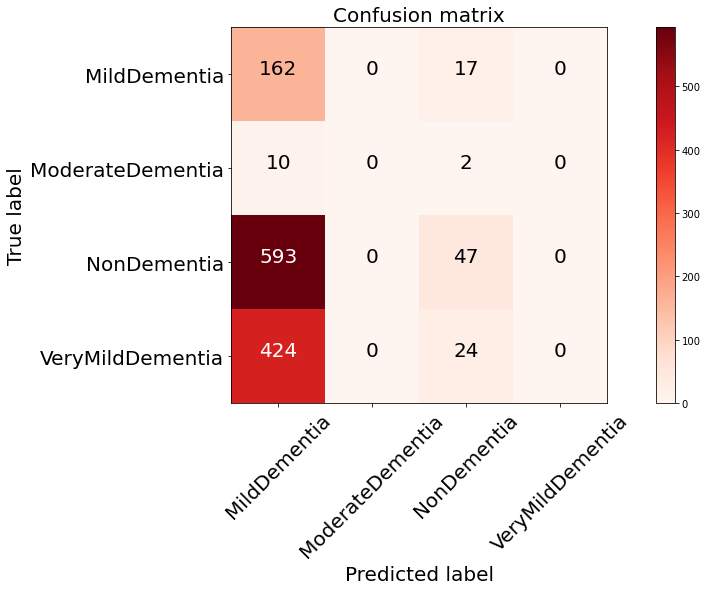

In [9]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Percentile Stretched HE with (3,3) kernel accuracy: {:.2f}%".format(accuracy * 100))  
print("Percentile Stretched HE Loss: {:.2f}".format(loss))  
print("Percentile Stretched HE Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 1.2189 - accuracy: 0.7559 - precision: 0.5136 - recall: 0.4433 - auc: 0.7826
HOG combined with Fuzzy Logic Histogram Correction accuracy: 75.59%
HOG combined with  Fuzzy Logic Histogram Correction  Loss: 1.22
HOG combined with  Fuzzy Logic Histogram Correction Recall 44.33%, Area under the Curve (AUC) 78.26%
Confusion matrix, without normalization


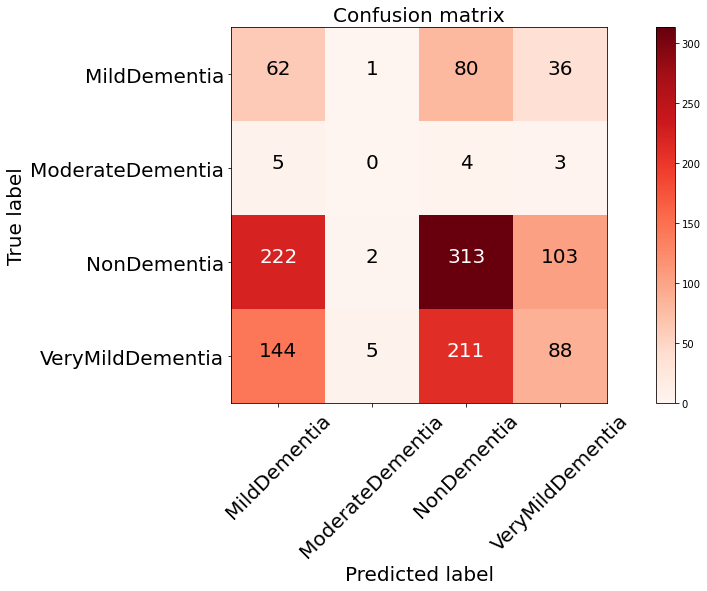

In [25]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("HOG combined with Fuzzy Logic Histogram Correction accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG combined with  Fuzzy Logic Histogram Correction  Loss: {:.2f}".format(loss))  
print("HOG combined with  Fuzzy Logic Histogram Correction Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 16s 1s/step - loss: 1.4914 - accuracy: 0.7439 - precision: 0.4860 - recall: 0.4214 - auc: 0.7435
HOG combined with Gamma Correction accuracy: 74.39%
HOG combined with Gamma Correction  Loss: 1.49
HOG combined with Gamma Correction Recall 42.14%, Area under the Curve (AUC) 74.35%
Confusion matrix, without normalization


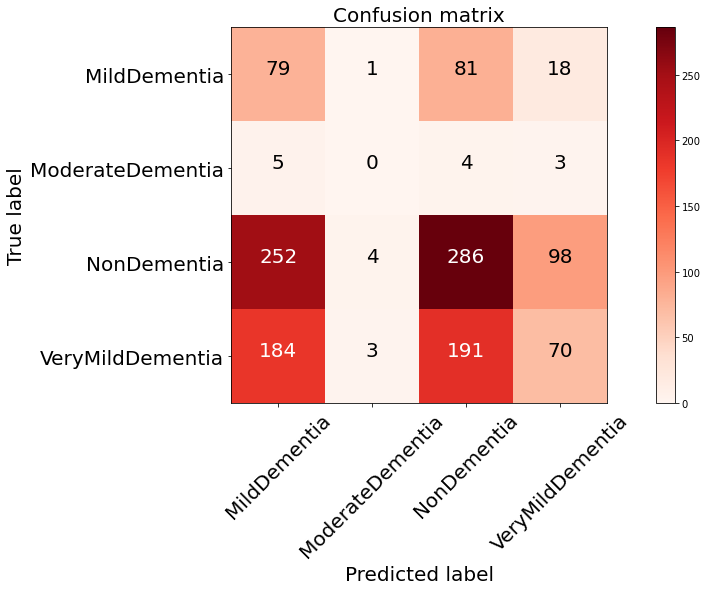

In [10]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("HOG combined with Gamma Correction accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG combined with Gamma Correction  Loss: {:.2f}".format(loss))  
print("HOG combined with Gamma Correction Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

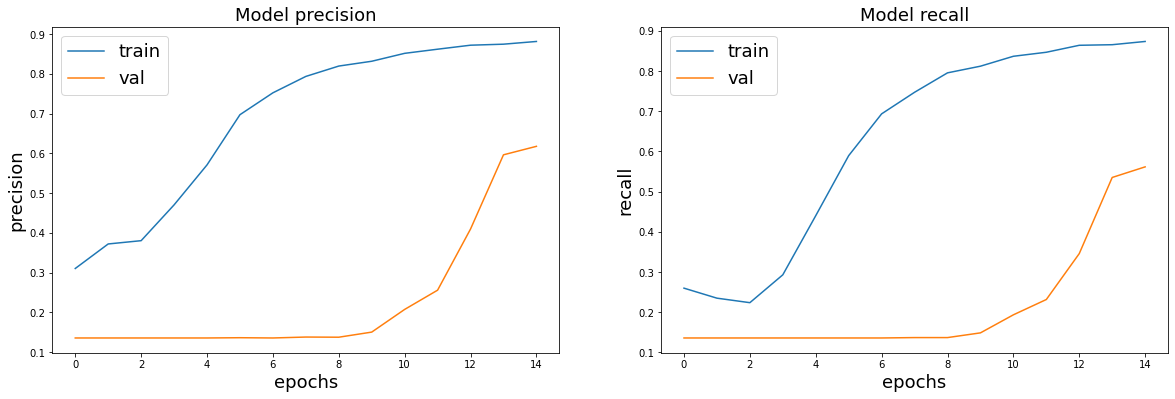

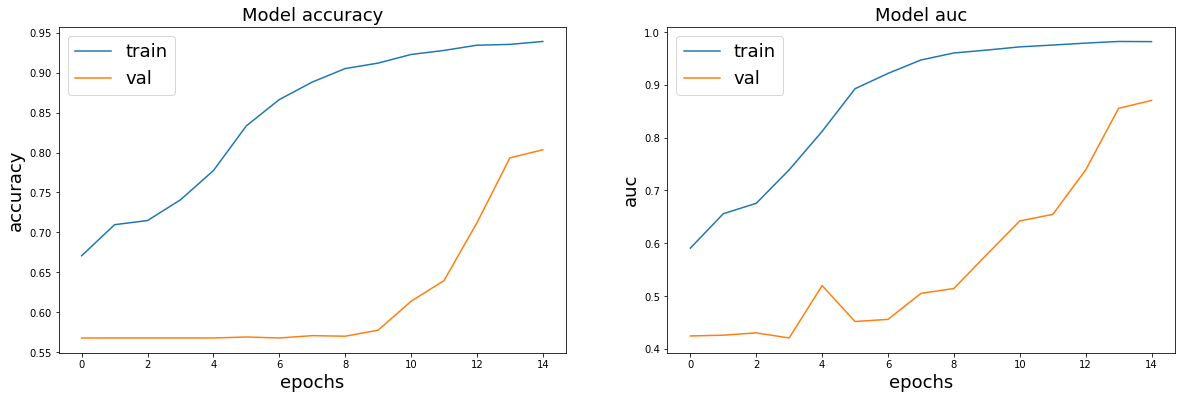

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    #ax[i].set_xticks(size=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 14s 1s/step - loss: 1.9368 - accuracy: 0.7602 - precision: 0.5205 - recall: 0.5160 - auc: 0.7751
HOG with Only one Convolutional layer and one dense layer accuracy: 76.02%
HOG Loss: 1.94
HOG Recall 51.60%, Area under the Curve (AUC) 77.51%
Confusion matrix, without normalization


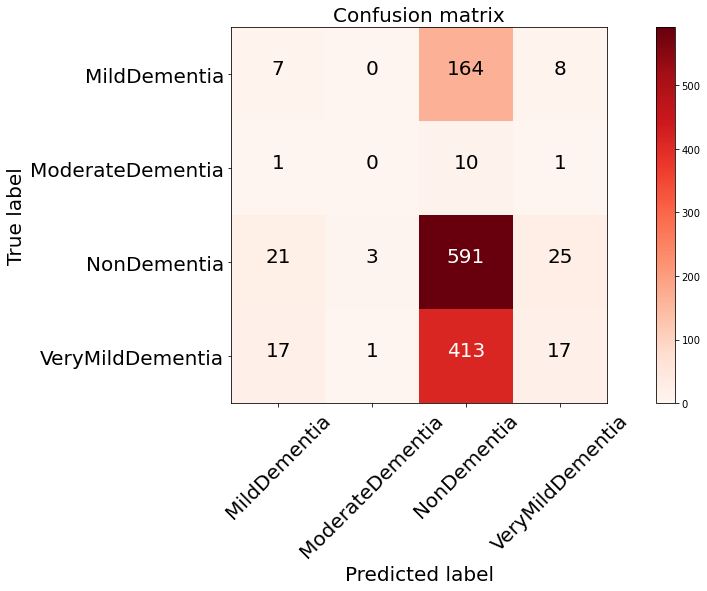

In [18]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("HOG with Only one Convolutional layer and one dense layer accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG Loss: {:.2f}".format(loss))  
print("HOG Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 10s 808ms/step - loss: 121.1488 - accuracy: 0.6701 - precision: 0.3401 - recall: 0.3401 - auc: 0.5615
Only two Convolutional layer HOG accuracy: 67.01%
HOG Loss: 121.15
HOG Recall 34.01%, Area under the Curve (AUC) 56.15%
Confusion matrix, without normalization


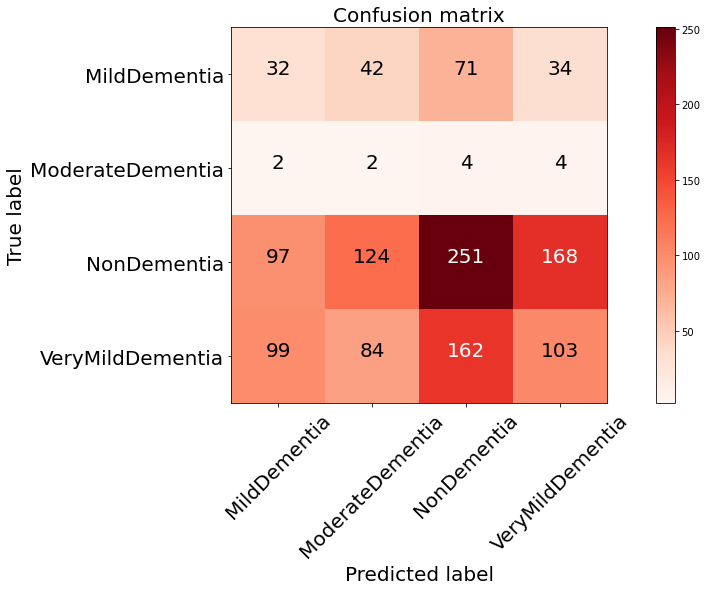

In [15]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Only two Convolutional layer HOG accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG Loss: {:.2f}".format(loss))  
print("HOG Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 1.4371 - accuracy: 0.7649 - precision: 0.5310 - recall: 0.5082 - auc: 0.7892
HOG accuracy: 76.49%
HOG Loss: 1.44
HOG Recall 50.82%, Area under the Curve (AUC) 78.92%
Confusion matrix, without normalization


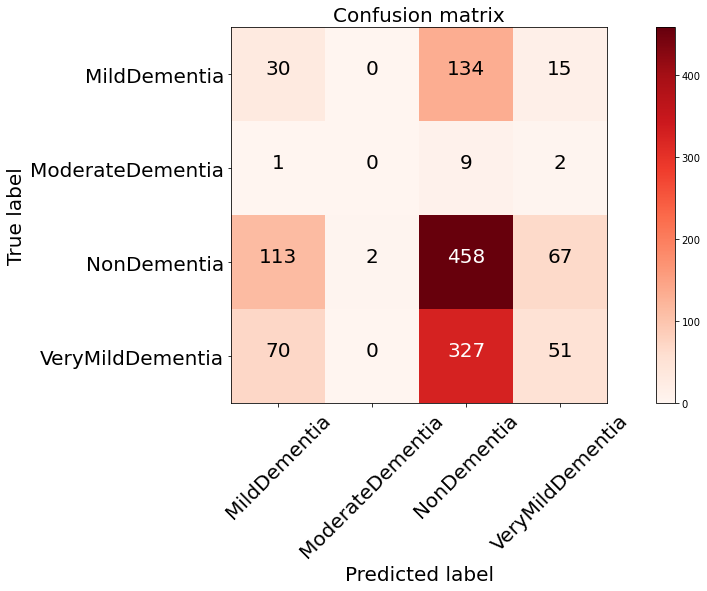

In [13]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("HOG accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG Loss: {:.2f}".format(loss))  
print("HOG Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 29508.4258 - accuracy: 0.6751 - precision: 0.3503 - recall: 0.3503 - auc: 0.5668
Adaptive HE with clip limit 0.09 accuracy: 67.51%
Loss: 29508.43
Recall 35.03%, Area under the Curve (AUC) 56.68%
Confusion matrix, without normalization


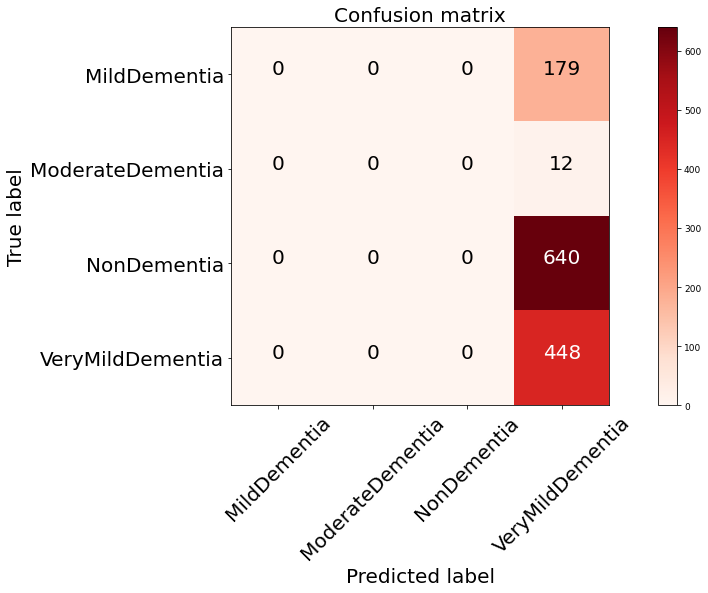

In [83]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Adaptive HE with clip limit 0.09 accuracy: {:.2f}%".format(accuracy * 100))  
print("Loss: {:.2f}".format(loss))  
print("Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 2.2820 - accuracy: 0.6955 - precision: 0.3861 - recall: 0.3698 - auc: 0.6942
Percentile Stretched Histogram without L1 and L2 denselayer accuracy: 69.55%
Percentile Stretched Histogram Loss: 2.28
Percentile Stretched Histogram Recall 36.98%, Area under the Curve (AUC) 69.42%
Confusion matrix, without normalization


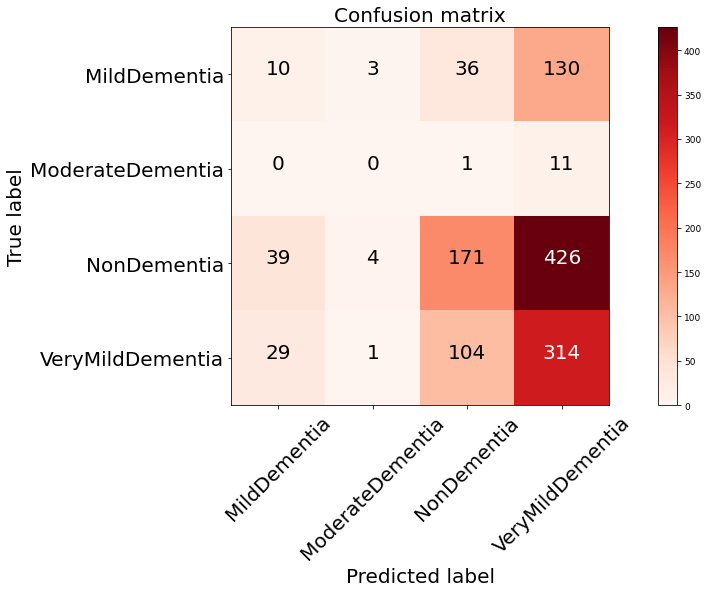

In [72]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Percentile Stretched Histogram without L1 and L2 denselayer accuracy: {:.2f}%".format(accuracy * 100))  
print("Percentile Stretched Histogram Loss: {:.2f}".format(loss))  
print("Percentile Stretched Histogram Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 18s 1s/step - loss: 64688.4570 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5992
Percentile Stretched Histogram with denselayer regularisers L1 and L2, dropout accuracy: 75.00%
Percentile Stretched Histogram Loss: 64688.46
Percentile Stretched Histogram Recall 0.00%, Area under the Curve (AUC) 59.92%
Confusion matrix, without normalization


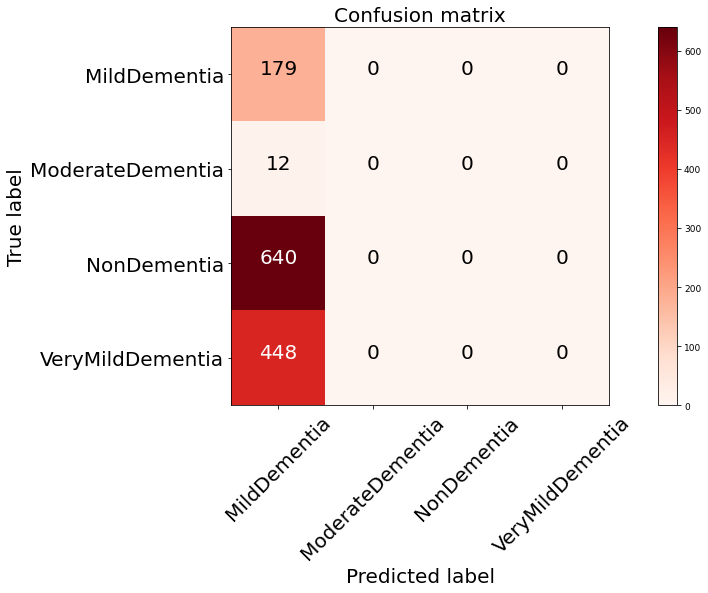

In [67]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Percentile Stretched Histogram with denselayer regularisers L1 and L2, dropout accuracy: {:.2f}%".format(accuracy * 100))  
print("Percentile Stretched Histogram Loss: {:.2f}".format(loss))  
print("Percentile Stretched Histogram Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 18s 1s/step - loss: 1.7232 - accuracy: 0.7258 - precision: 0.4490 - recall: 0.4269 - auc: 0.7330
Percentile Stretched Histogram with 20% dropout accuracy: 72.58%
Percentile Stretched Histogram Loss: 1.72
Percentile Stretched Histogram Recall 42.69%, Area under the Curve (AUC) 73.30%
Confusion matrix, without normalization


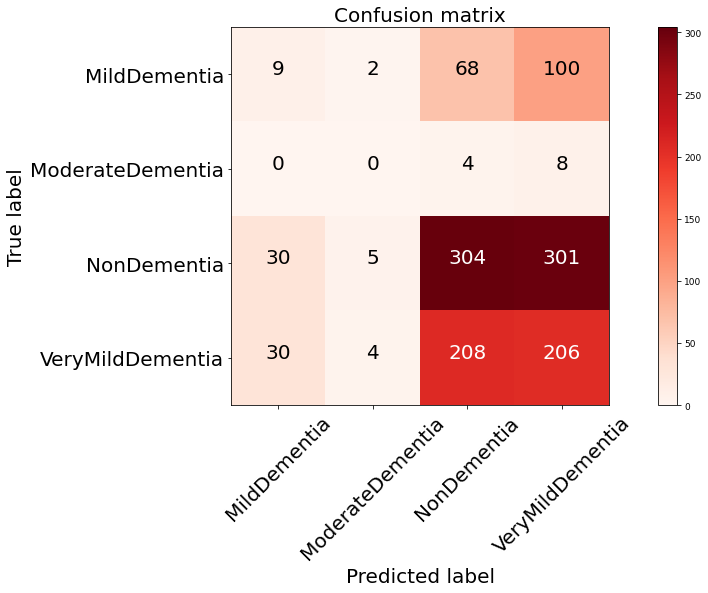

In [60]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Percentile Stretched Histogram with 20% dropout accuracy: {:.2f}%".format(accuracy * 100))  
print("Percentile Stretched Histogram Loss: {:.2f}".format(loss))  
print("Percentile Stretched Histogram Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 18s 1s/step - loss: 3.7163 - accuracy: 0.7498 - precision: 0.4996 - recall: 0.4980 - auc: 0.6658
Discrete Cosine Transform accuracy: 74.98%
Discrete Cosine Transform Loss: 3.72
Discrete Cosine Transform Recall 49.80%, Area under the Curve (AUC) 66.58%
Confusion matrix, without normalization


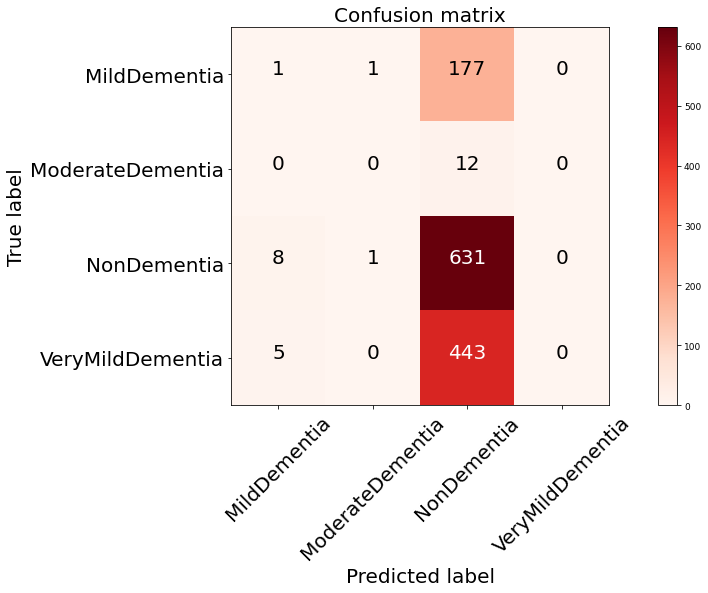

In [57]:
# DCT
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Discrete Cosine Transform accuracy: {:.2f}%".format(accuracy * 100))  
print("Discrete Cosine Transform Loss: {:.2f}".format(loss))  
print("Discrete Cosine Transform Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 2.0883 - accuracy: 0.7629 - precision: 0.5263 - recall: 0.5160 - auc: 0.7638
HOG accuracy: 76.29%
HOG Loss: 2.09
HOG Recall 51.60%, Area under the Curve (AUC) 76.38%
Confusion matrix, without normalization


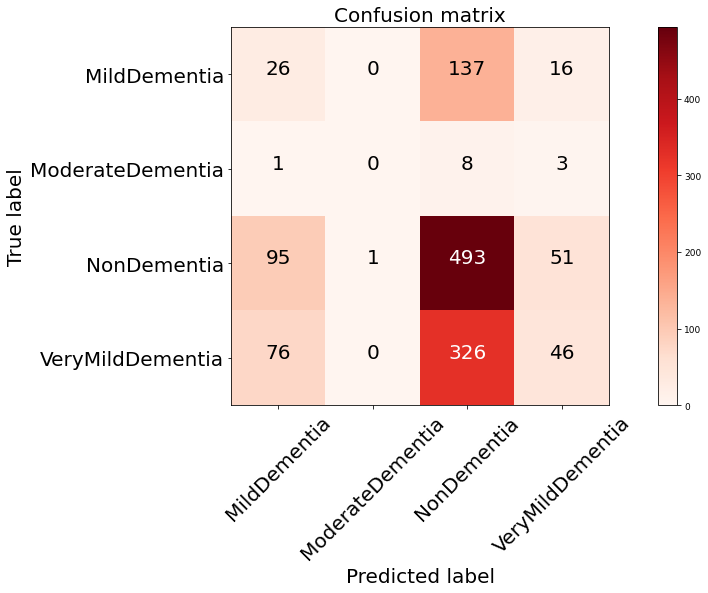

In [44]:
# HOG
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("HOG accuracy: {:.2f}%".format(accuracy * 100))  
print("HOG Loss: {:.2f}".format(loss))  
print("HOG Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 1.7148 - accuracy: 0.7262 - precision: 0.4442 - recall: 0.3800 - auc: 0.7078
Quantized Bi-Histogram Equalization (30 bins) accuracy: 72.62%
Quantized Bi-Histogram Equalization (30 bins) Loss: 1.71
Quantized Bi-Histogram Equalization (30 bins) Recall 38.00%, Area under the Curve (AUC) 70.78%
Confusion matrix, without normalization


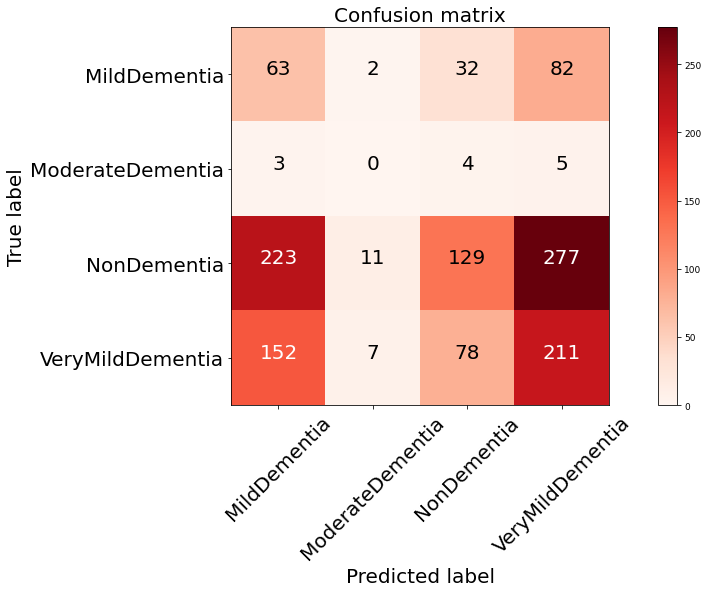

In [37]:
# Quantized Bi-Histogram Equalization
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Quantized Bi-Histogram Equalization (30 bins) accuracy: {:.2f}%".format(accuracy * 100))  
print("Quantized Bi-Histogram Equalization (30 bins) Loss: {:.2f}".format(loss))  
print("Quantized Bi-Histogram Equalization (30 bins) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

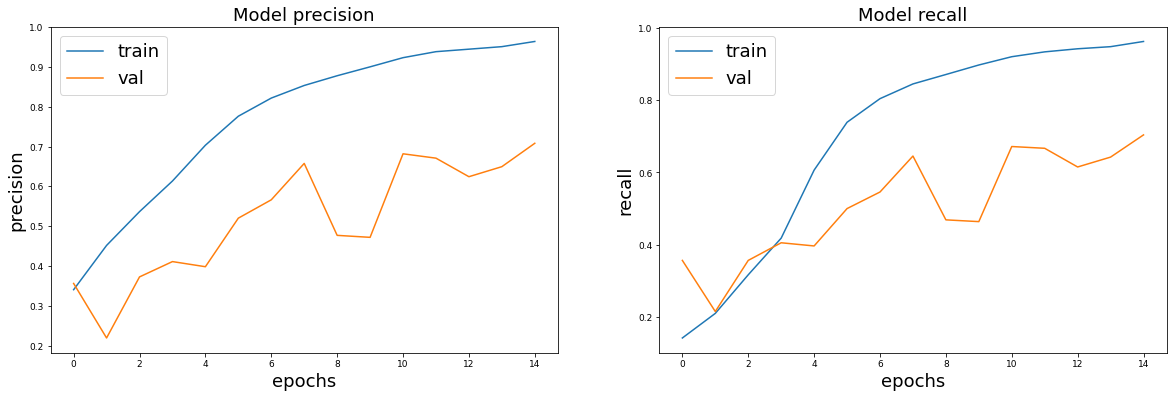

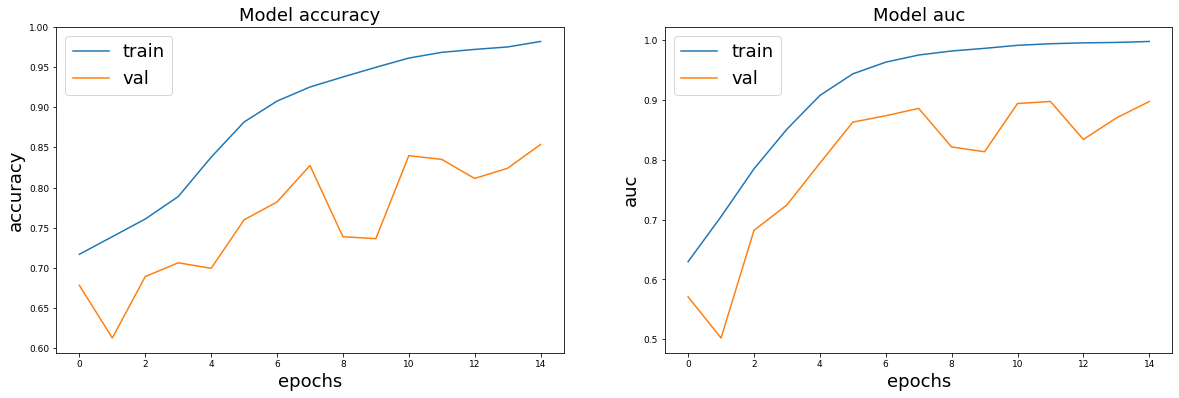

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    #ax[i].set_xticks(size=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 18s 1s/step - loss: 3.0751 - accuracy: 0.6794 - precision: 0.3286 - recall: 0.2705 - auc: 0.5650
Quantized Bi-Histogram Equalization accuracy: 67.94%
Quantized Bi-Histogram Equalization Loss: 3.08
Quantized Bi-Histogram Equalization Recall 27.05%, Area under the Curve (AUC) 56.50%
Confusion matrix, without normalization


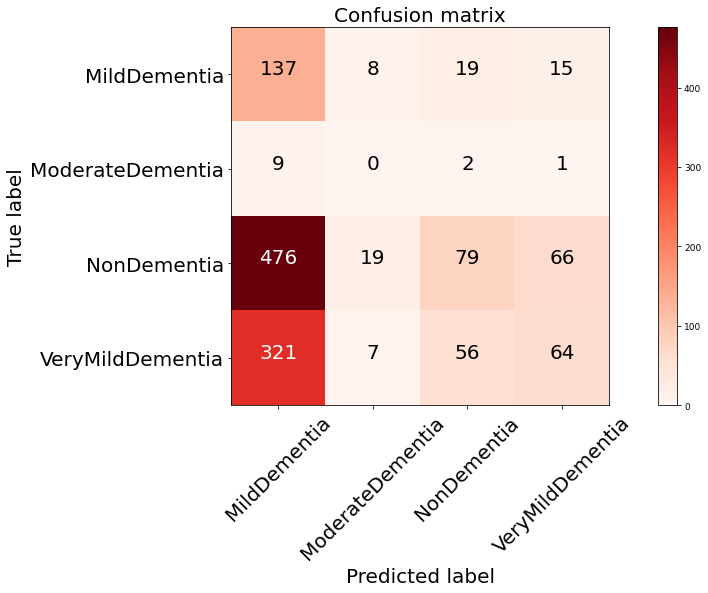

In [33]:
# Quantized Bi-Histogram Equalization
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Quantized Bi-Histogram Equalization accuracy: {:.2f}%".format(accuracy * 100))  
print("Quantized Bi-Histogram Equalization Loss: {:.2f}".format(loss))  
print("Quantized Bi-Histogram Equalization Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 3.5022 - accuracy: 0.6996 - precision: 0.3991 - recall: 0.3987 - auc: 0.6286
Contrast Stretching Histogram Equalised accuracy: 69.96%
Contrast Stretching Histogram Equalised Loss: 3.50
Contrast Stretching Histogram Equalised Recall 39.87%, Area under the Curve (AUC) 62.86%
Confusion matrix, without normalization


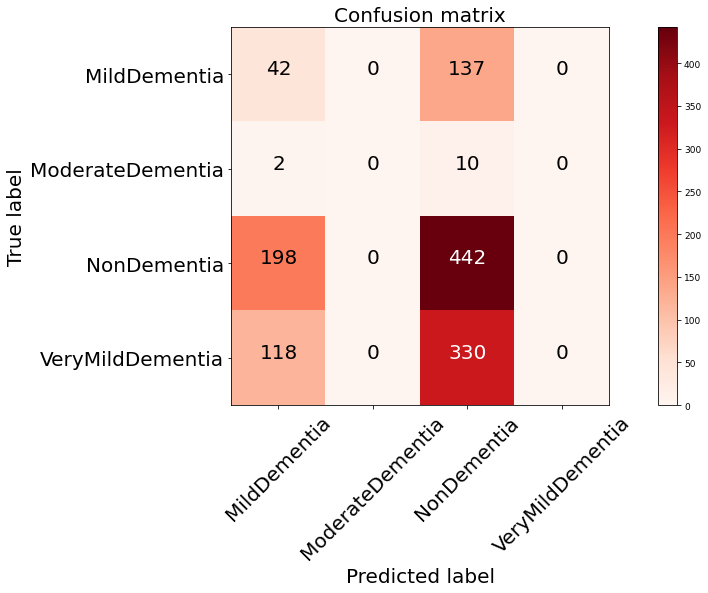

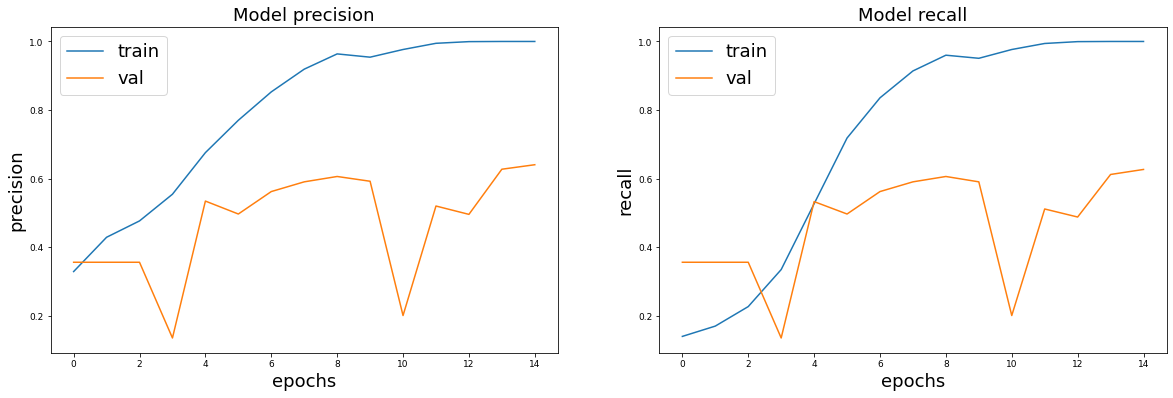

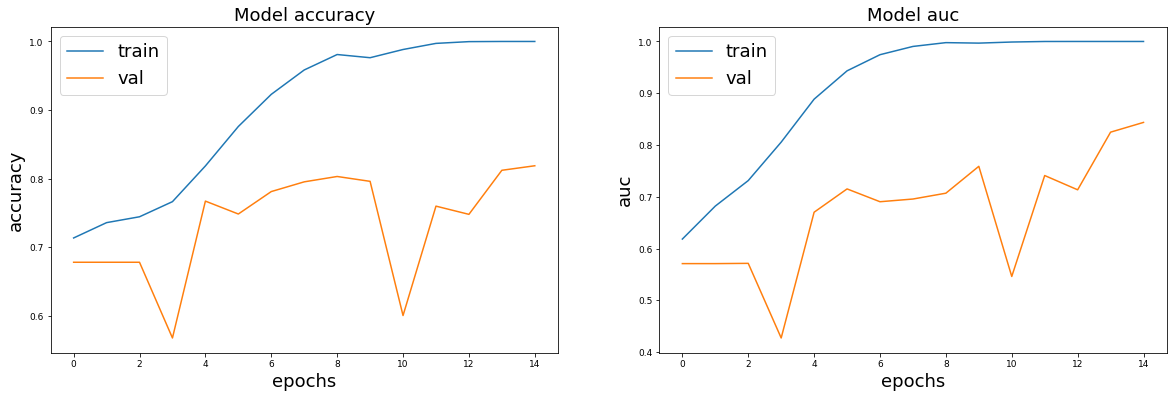

In [25]:
# Contrast Stretching
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Contrast Stretching Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print("Contrast Stretching Histogram Equalised Loss: {:.2f}".format(loss))  
print("Contrast Stretching Histogram Equalised Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 18s 1s/step - loss: 38415.0039 - accuracy: 0.7502 - precision: 0.5004 - recall: 0.5004 - auc: 0.6669
Global Histogram Equalised accuracy: 75.02%
 Global Histogram Equalised Loss: 38415.00
Global Histogram Equalised Recall 50.04%, Area under the Curve (AUC) 66.69%
Confusion matrix, without normalization


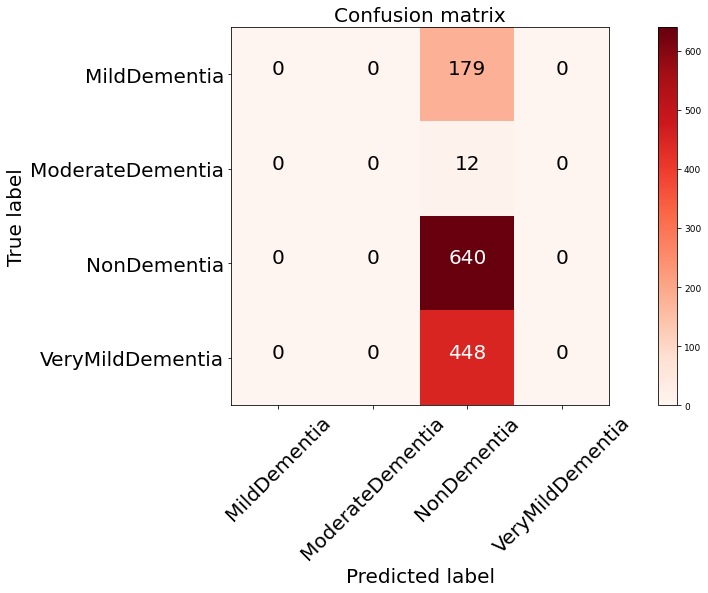

In [16]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Global Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print(" Global Histogram Equalised Loss: {:.2f}".format(loss))  
print("Global Histogram Equalised Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

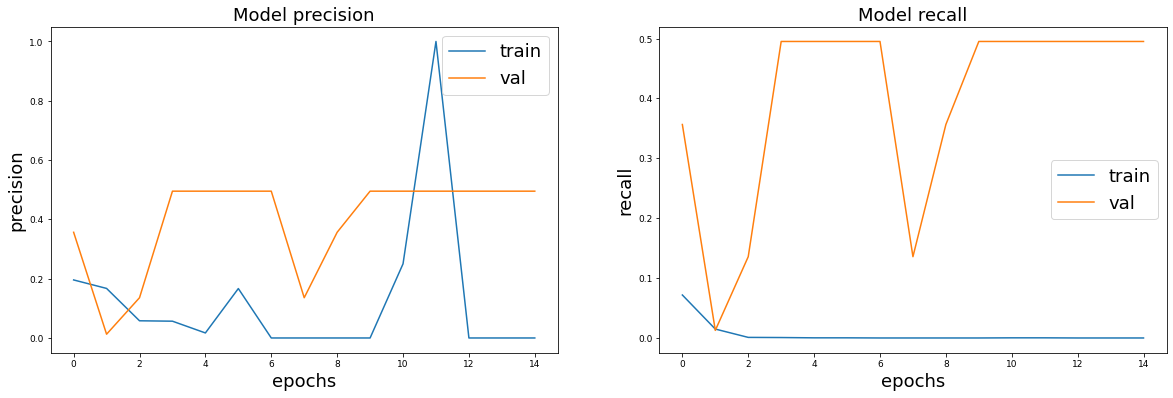

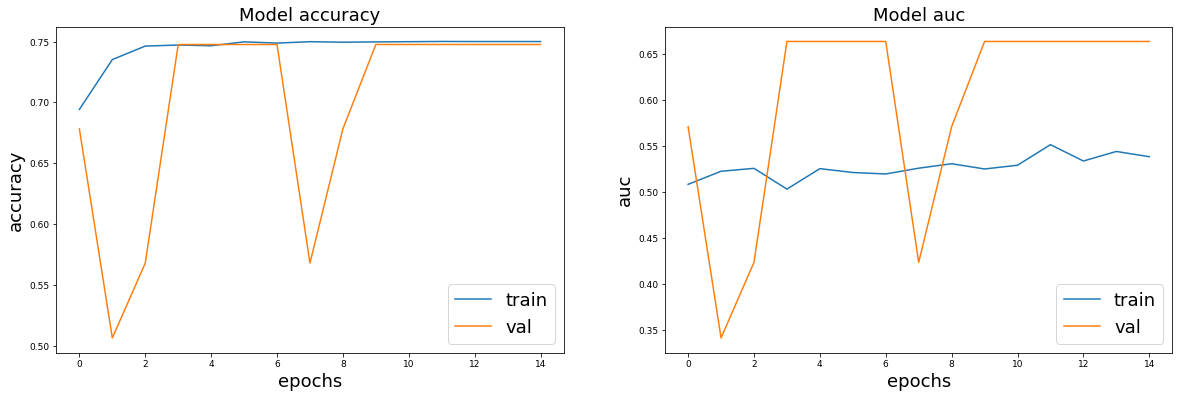

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)
    
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 18s 1s/step - loss: 1.6644 - accuracy: 0.7207 - precision: 0.4031 - recall: 0.2439 - auc: 0.6571
Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=2.9, gamma=1.5 accuracy: 72.07%
  Loss: 1.66
Dynamic Contrast Ratio Gamma Correction (DCRGC) ontrast_intensity=2.9, gamma=1.5 Recall 24.39%, Area under the Curve (AUC) 65.71%
Confusion matrix, without normalization


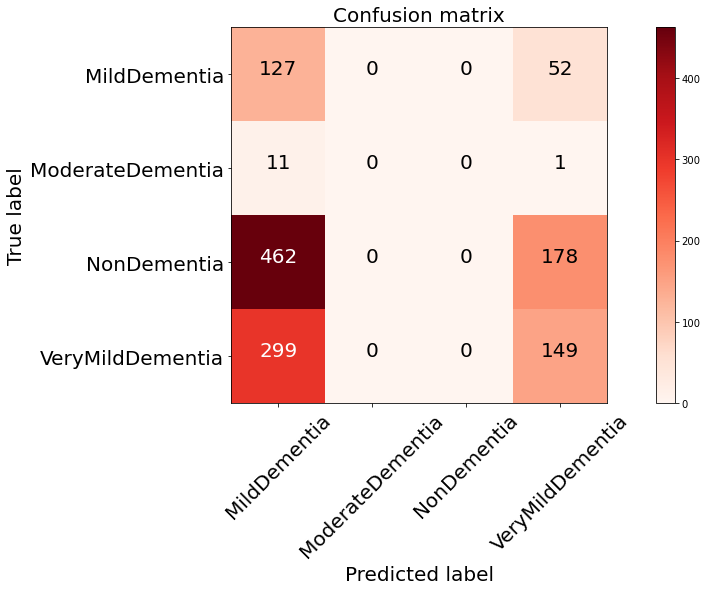

In [7]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=2.9, gamma=1.5 accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Dynamic Contrast Ratio Gamma Correction (DCRGC) ontrast_intensity=2.9, gamma=1.5 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 2.2071 - accuracy: 0.7240 - precision: 0.4476 - recall: 0.4441 - auc: 0.7450
Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=0.1, gamma=0.5 accuracy: 72.40%
  Loss: 2.21
Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=0.1, gamma=0.5 Recall 44.41%, Area under the Curve (AUC) 74.50%
Confusion matrix, without normalization


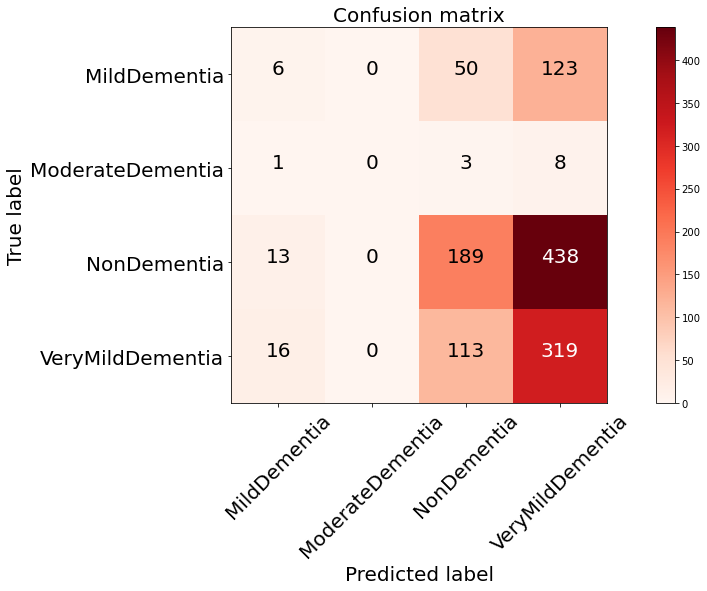

In [48]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=0.1, gamma=0.5 accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Dynamic Contrast Ratio Gamma Correction (DCRGC) contrast_intensity=0.1, gamma=0.5 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 19s 1s/step - loss: 10.1765 - accuracy: 0.6751 - precision: 0.3503 - recall: 0.3503 - auc: 0.5667
Bi-Histogram Equalization with a Plateau Limit (BHEPL) accuracy: 67.51%
  Loss: 10.18
Bi-Histogram Equalization with a Plateau Limit (BHEPL) Recall 35.03%, Area under the Curve (AUC) 56.67%
Confusion matrix, without normalization


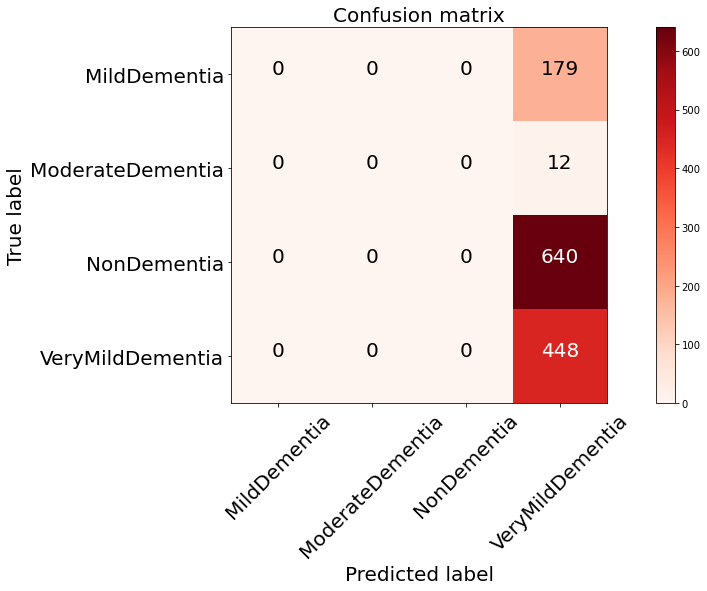

In [42]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Bi-Histogram Equalization with a Plateau Limit (BHEPL) accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Bi-Histogram Equalization with a Plateau Limit (BHEPL) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 7.4879 - accuracy: 0.7502 - precision: 0.5004 - recall: 0.5004 - auc: 0.6669
Locally Histogram Equalised with disk radius 60 accuracy: 75.02%
  Loss: 7.49
Locally Histogram Equalised with disk radius 60 Recall 50.04%, Area under the Curve (AUC) 66.69%
Confusion matrix, without normalization


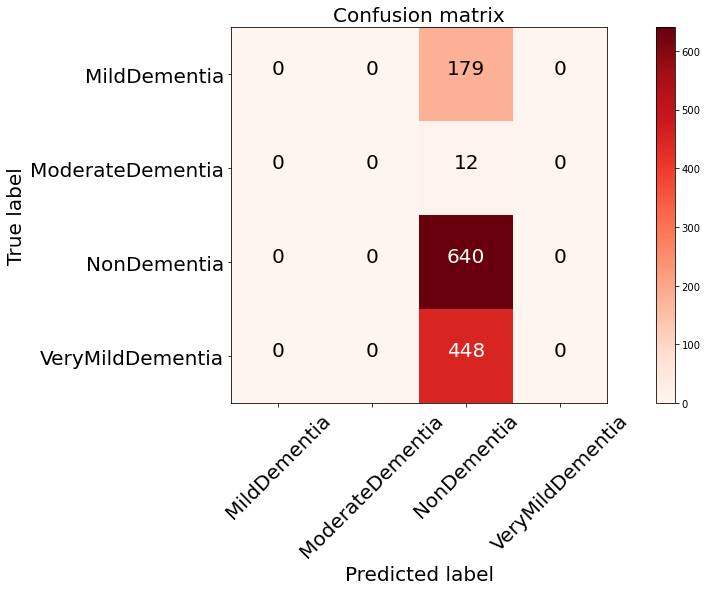

In [22]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Locally Histogram Equalised with disk radius 60 accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Locally Histogram Equalised with disk radius 60 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 19s 1s/step - loss: 3.1491 - accuracy: 0.7269 - precision: 0.4538 - recall: 0.4527 - auc: 0.7355
Bin Underflow Bin Overflow Histogram Equalised accuracy: 72.69%
  Loss: 3.15
Bin Underflow Bin Overflow Histogram Equalised Recall 45.27%, Area under the Curve (AUC) 73.55%
Confusion matrix, without normalization


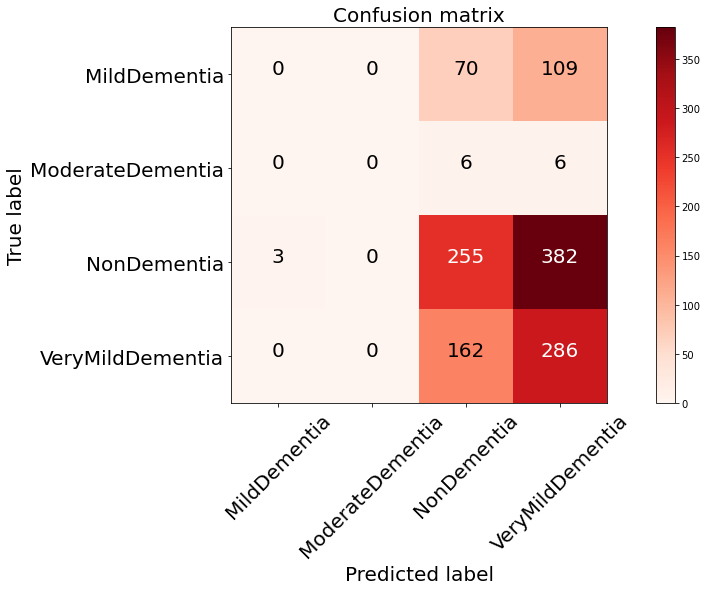

In [18]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Bin Underflow Bin Overflow Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Bin Underflow Bin Overflow Histogram Equalised Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 5.5066 - accuracy: 0.5919 - precision: 0.1772 - recall: 0.1736 - auc: 0.4350
Locally Histogram Equalised with disk radius 5 accuracy: 59.19%
  Loss: 5.51
Locally Histogram Equalised with disk radius 5 Recall 17.36%, Area under the Curve (AUC) 43.50%
Confusion matrix, without normalization


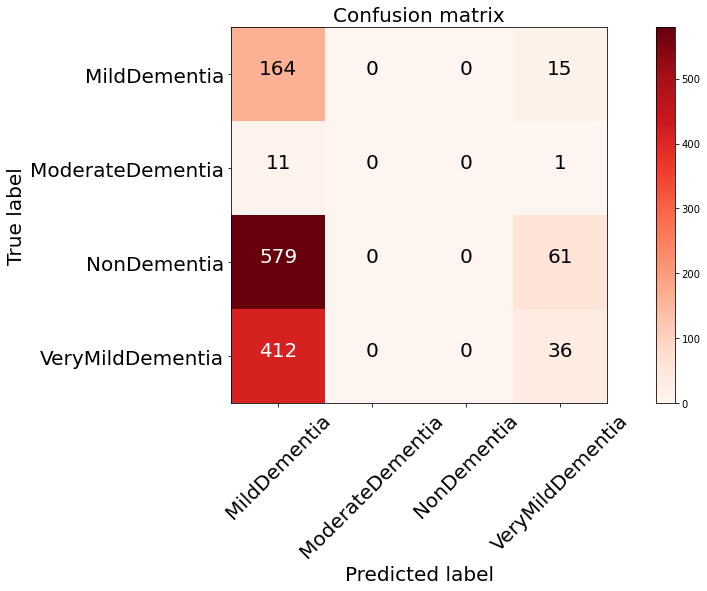

In [14]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Locally Histogram Equalised with disk radius 5 accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Locally Histogram Equalised with disk radius 5 Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 2.4263 - accuracy: 0.7568 - precision: 0.5140 - recall: 0.5020 - auc: 0.7275
Recursive Separated and Weighted Histogram Equalization (RSWHE) accuracy: 75.68%
  Loss: 2.43
Recursive Separated and Weighted Histogram Equalization (RSWHE) Recall 50.20%, Area under the Curve (AUC) 72.75%
Confusion matrix, without normalization


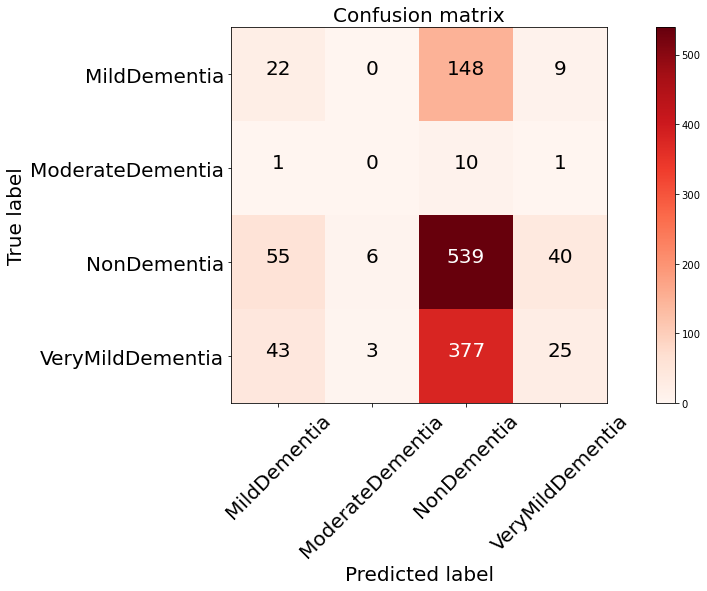

In [33]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Recursive Separated and Weighted Histogram Equalization (RSWHE) accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recursive Separated and Weighted Histogram Equalization (RSWHE) Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 19s 1s/step - loss: 1.9338 - accuracy: 0.7609 - precision: 0.5227 - recall: 0.5051 - auc: 0.7647
Recursive Mean-Separate Histogram Equalization accuracy: 76.09%
  Loss: 1.93
Recursive Mean-Separate Histogram Equalization Recall 50.51%, Area under the Curve (AUC) 76.47%
Confusion matrix, without normalization


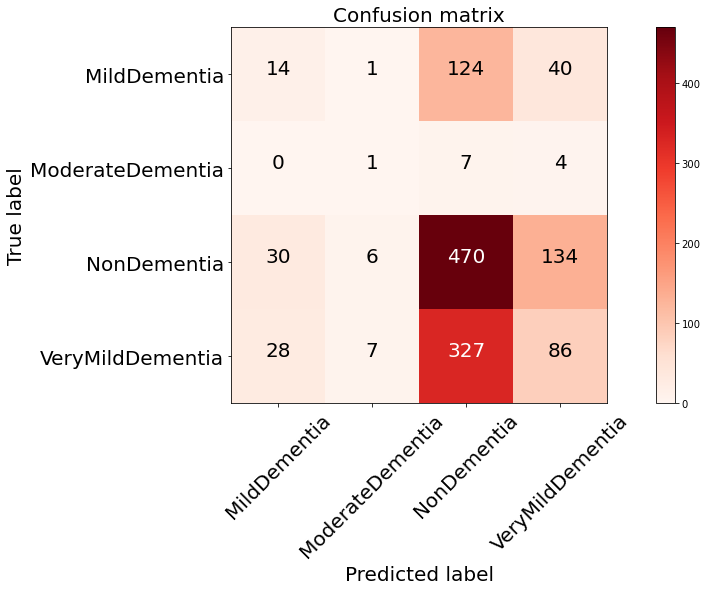

In [28]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Recursive Mean-Separate Histogram Equalization accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recursive Mean-Separate Histogram Equalization Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 1.9629 - accuracy: 0.7658 - precision: 0.5324 - recall: 0.5199 - auc: 0.7664
Fuzzy Logic Histogram Equalisation accuracy: 76.58%
  Loss: 1.96
Fuzzy Logic Histogram Equalisation Recall 51.99%, Area under the Curve (AUC) 76.64%
Confusion matrix, without normalization


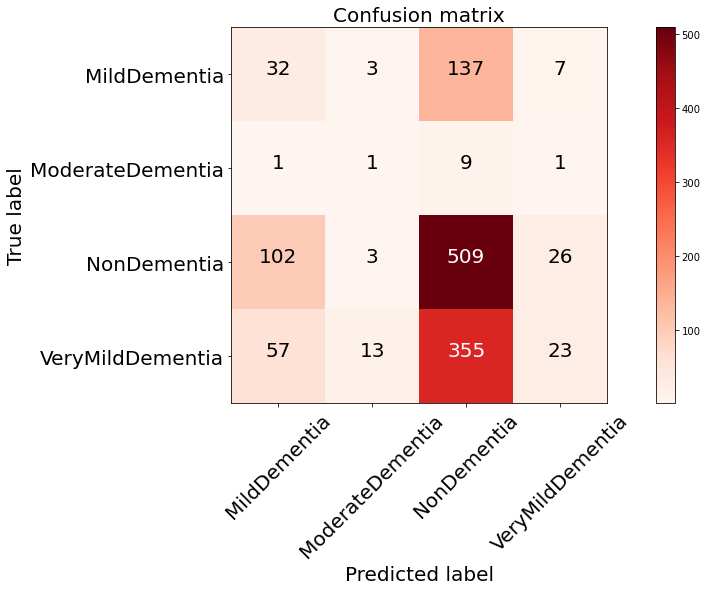

In [21]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Fuzzy Logic Histogram Equalisation accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Fuzzy Logic Histogram Equalisation Recall {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 14s 1s/step - loss: 1.9900 - accuracy: 0.7602 - precision: 0.5209 - recall: 0.5074 - auc: 0.7690
Contrast Limited Adaptive HE (CLAHE) accuracy: 76.02%
  Loss: 1.99
Contrast Limited Adaptive HE (CLAHE) Recal 50.74%, Area under the Curve (AUC) 76.90%
Confusion matrix, without normalization


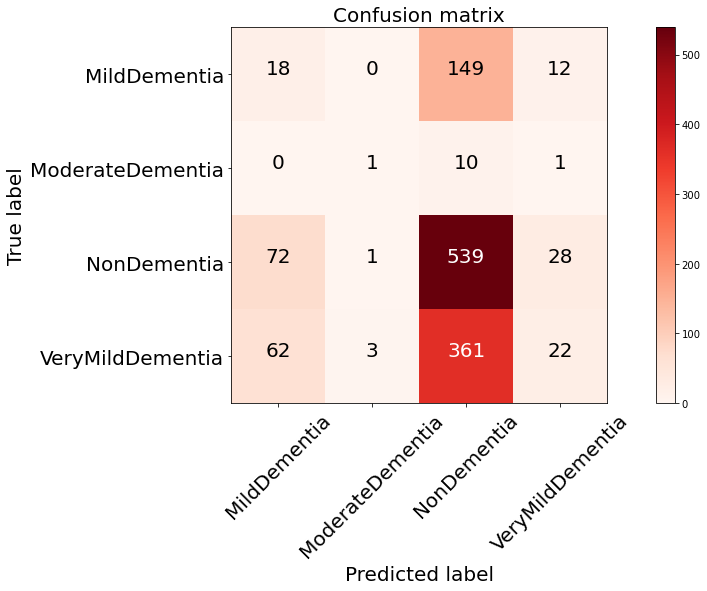

In [9]:
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Contrast Limited Adaptive HE (CLAHE) accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Contrast Limited Adaptive HE (CLAHE) Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 17s 1s/step - loss: 2.4226 - accuracy: 0.7258 - precision: 0.4460 - recall: 0.4003 - auc: 0.6624
localy corrected with larger disk of 20 Histogram Equalised accuracy: 72.58%
  Loss: 2.42
localy corrected with larger disk of 20 Histogram Equalised Recal 40.03%, Area under the Curve (AUC) 66.24%
Confusion matrix, without normalization


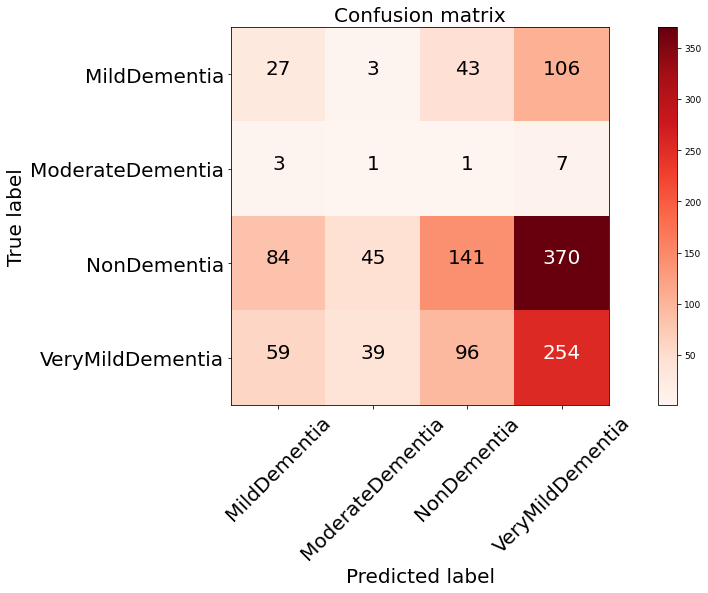

In [38]:
#model6.save_weights('15th_try.h5')
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("localy corrected with larger disk of 20 Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("localy corrected with larger disk of 20 Histogram Equalised Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 16s 1s/step - loss: 1.9618 - accuracy: 0.7541 - precision: 0.5085 - recall: 0.4918 - auc: 0.7448
Gamma Corrected Histogram Equalised accuracy: 75.41%
  Loss: 1.96
Gamma Corrected Histogram Equalised Recal 49.18%, Area under the Curve (AUC) 74.48%
Confusion matrix, without normalization


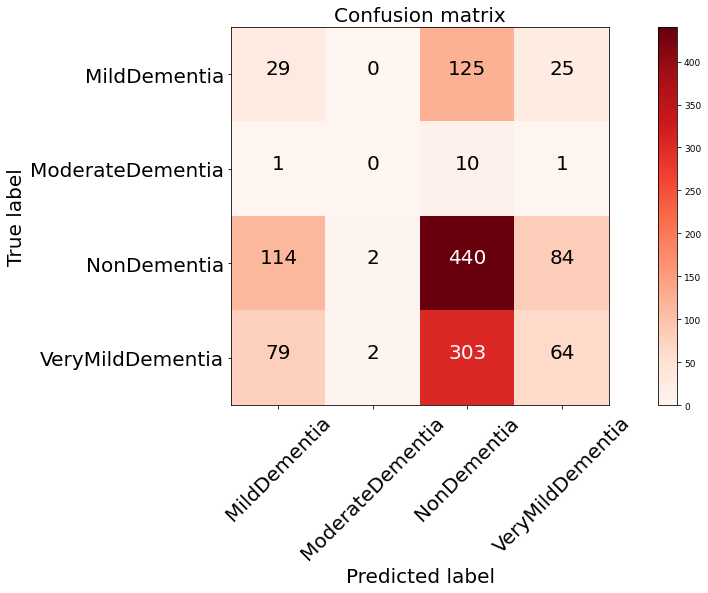

In [31]:
#model6.save_weights('15th_try.h5')
loss, accuracy, precision, recall, AUC  = model6.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("Gamma Corrected Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Gamma Corrected Histogram Equalised Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model6.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation=keras.layers.LeakyReLU(alpha=0.3), padding='same'),
#         tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1 )    ]   )
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=keras.layers.LeakyReLU(alpha=0.3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)])
    return block

depth_pool = keras.layers.Lambda( lambda X : tf.nn.max_pool(X,ksize = (1,1,1,3), 
                                                            strides=(1,1,1,3), 
                                                            padding='valid' ))

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.Conv2D(124, 3, activation=keras.layers.LeakyReLU(alpha=0.3), padding='same'),
       # tf.keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(alpha=0.3), padding='same'),

        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      #  conv_block(512),
        conv_block(256),
       # depth_pool(),
        
        tf.keras.layers.Flatten(),
      #  dense_block(512, 0.01),
        dense_block(128, 0.01),
        dense_block(64, 0.01),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    ])
    
    return model
  

with strategy.scope():
    model = build_model()
    METRICS = [ keras.metrics.BinaryAccuracy(name='accuracy'),
              keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    model.compile(
        optimizer= tf.keras.optimizers.Adam(lr= 0.001, beta_1=0.9, beta_2=0.9999)   ,
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS     )

model.summary()
#model.load_weights('third_try.h5')
#model.load_weights('12th_try.h5')

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

history = model.fit(   train_ds,
    validation_data=val_ds,
    callbacks=[ early_stopping_cb, lr_scheduler],   #checkpoint_cb,
    epochs= 15 , shuffle=True )
#model.save_weights('7th_try.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 208, 176, 124)     3472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 104, 88, 124)      0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 103, 87, 256)      34140     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2294016)           0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 128)               293634688 
_________________________________________________________________
sequential_6 (Sequential)    (None, 64)                8512      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

13/13 [==============================] - 18s 1s/step - loss: 1504734.7500 - accuracy: 0.5700 - precision: 0.1400 - recall: 0.1400 - auc: 0.4266
 Adaptive Histogram Equalised accuracy: 57.00%
  Loss: 1504734.75
Recal 14.00%, Area under the Curve (AUC) 42.66%
Confusion matrix, without normalization


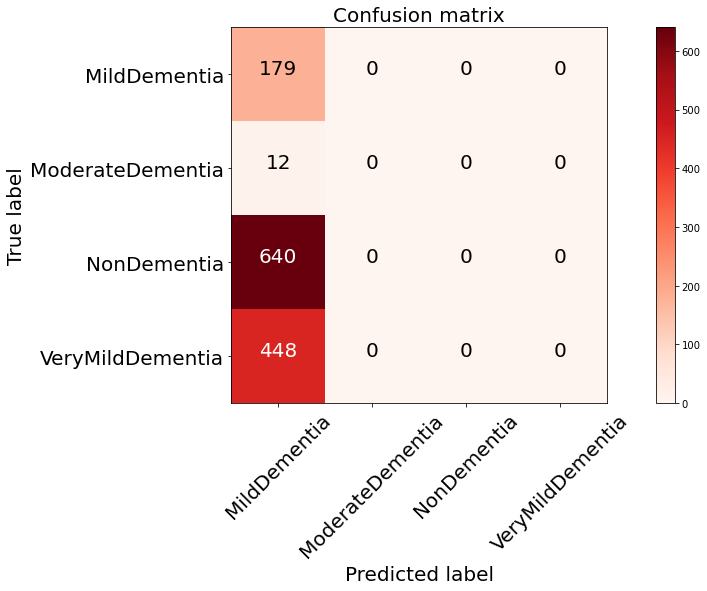

In [20]:
model.save_weights('14th_try.h5')
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print(" Adaptive Histogram Equalised accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 16s 1s/step - loss: 3.7898 - accuracy: 0.7361 - precision: 0.4720 - recall: 0.4683 - auc: 0.6526
  accuracy: 73.61%
  Loss: 3.79
Recal 46.83%, Area under the Curve (AUC) 65.26%
Confusion matrix, without normalization


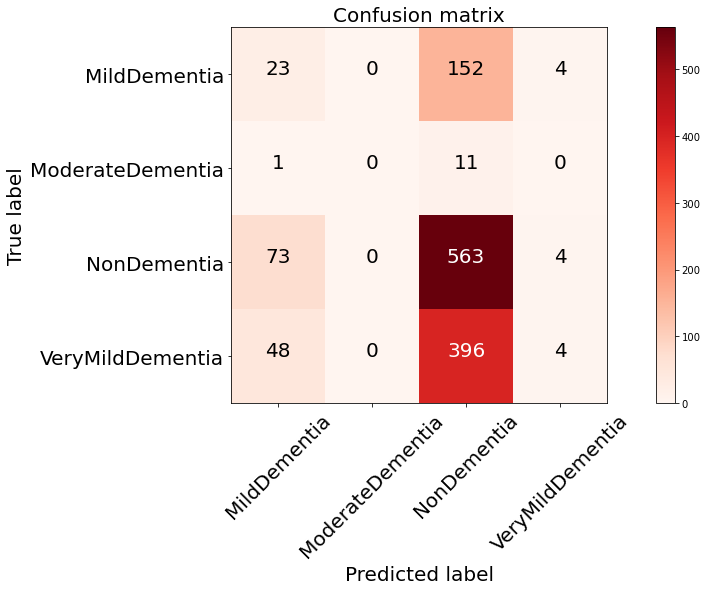

In [6]:
model.save_weights('14th_try.h5')
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 23s 2s/step - loss: 2.4966 - accuracy: 0.7543 - precision: 0.5087 - recall: 0.5027 - auc: 0.7282
  accuracy: 75.43%
  Loss: 2.50
Recal 50.27%, Area under the Curve (AUC) 72.82%
Confusion matrix, without normalization


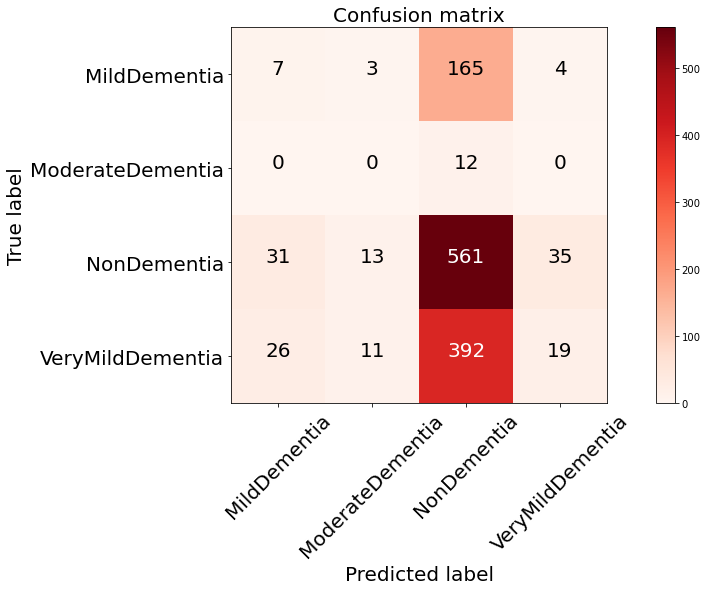

In [18]:
model.save_weights('13th_try.h5')
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 24s 2s/step - loss: 1.8183 - accuracy: 0.7535 - precision: 0.5074 - recall: 0.4808 - auc: 0.7193
  accuracy: 75.35%
  Loss: 1.82
Recal 48.08%, Area under the Curve (AUC) 71.93%
Confusion matrix, without normalization


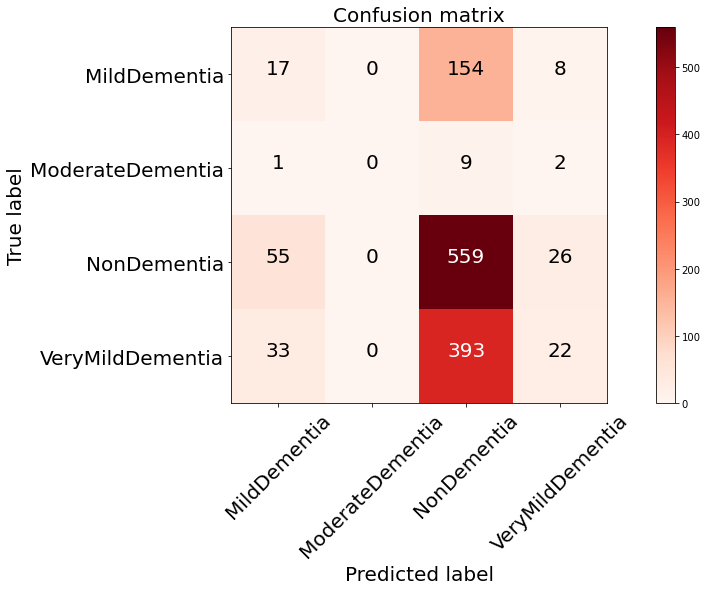

In [7]:
#model.save_weights('12th_try.h5')
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 26s 2s/step - loss: 1.8183 - accuracy: 0.7535 - precision: 0.5074 - recall: 0.4808 - auc: 0.7193
  accuracy: 75.35%
  Loss: 1.82
Recal 48.08%, Area under the Curve (AUC) 71.93%
                  precision    recall  f1-score   support

    MildDementia       0.16      0.09      0.12       179
ModerateDementia       0.00      0.00      0.00        12
     NonDementia       0.50      0.87      0.64       640
VeryMildDementia       0.38      0.05      0.09       448

        accuracy                           0.47      1279
       macro avg       0.26      0.25      0.21      1279
    weighted avg       0.41      0.47      0.37      1279



/home/behr/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


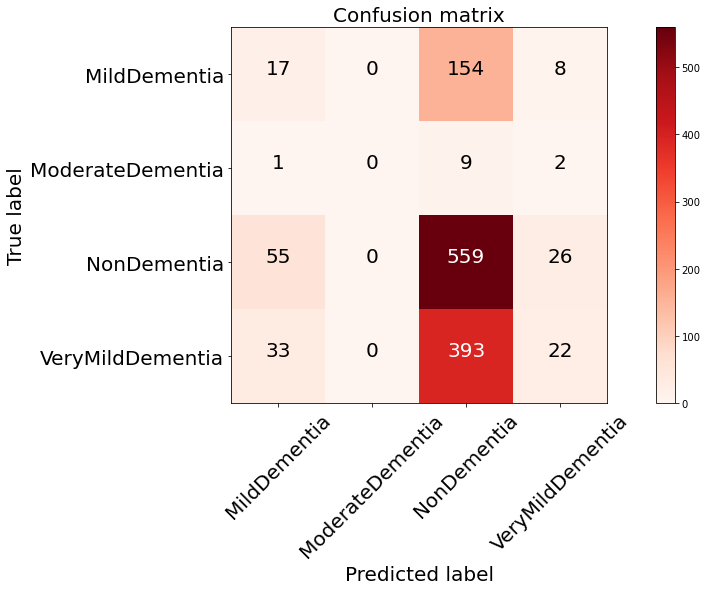

In [8]:
#model.save_weights('12th_try.h5')
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))
classes =  ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
#print(preds)
classification_metrics = metrics.classification_report(_test_labels, _preds, target_names=classes )
print(classification_metrics)

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

In [21]:
classes =  ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
#print(preds)
classification_metrics = metrics.classification_report(_test_labels, _preds, target_names=classes )
print(classification_metrics)

                  precision    recall  f1-score   support

    MildDementia       0.12      0.27      0.17       179
ModerateDementia       0.00      0.00      0.00        12
     NonDementia       0.50      0.68      0.57       640
VeryMildDementia       0.00      0.00      0.00       448

        accuracy                           0.38      1279
       macro avg       0.15      0.24      0.19      1279
    weighted avg       0.27      0.38      0.31      1279



/home/behr/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13/13 [==============================] - 14s 1s/step - loss: 3.7537 - accuracy: 0.7316 - precision: 0.4624 - recall: 0.4519 - auc: 0.6555
  accuracy: 73.16%
  Loss: 3.75
Recal 45.19%, Area under the Curve (AUC) 65.55%
Confusion matrix, without normalization


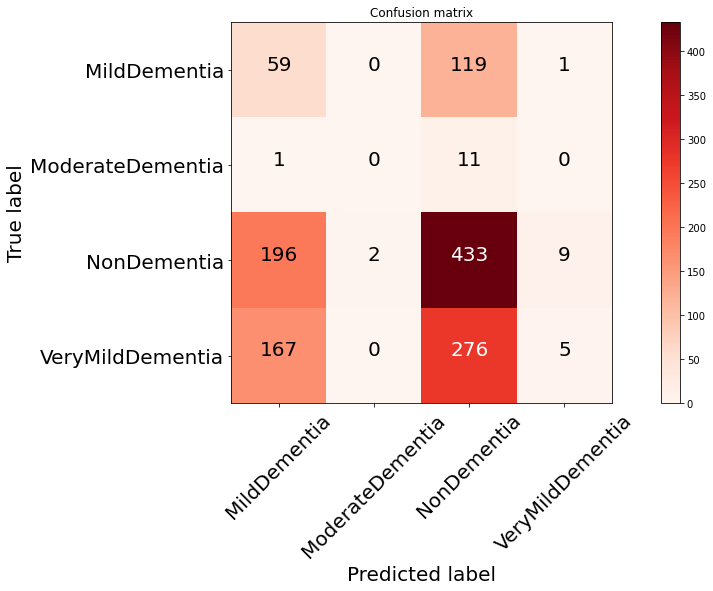

In [13]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 23s 2s/step - loss: 1.9859 - accuracy: 0.7746 - precision: 0.5521 - recall: 0.5223 - auc: 0.7695
  accuracy: 77.46%
  Loss: 1.99
Recal 52.23%, Area under the Curve (AUC) 76.95%
Confusion matrix, without normalization


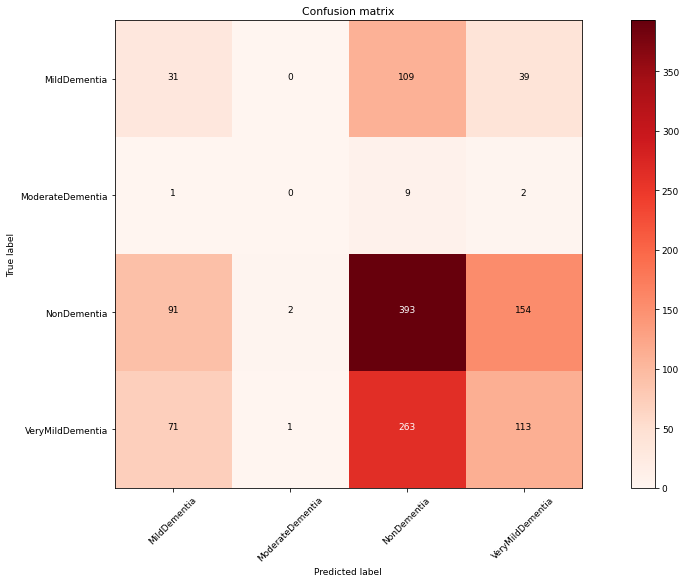

In [80]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 14s 1s/step - loss: 2.3066 - accuracy: 0.7664 - precision: 0.5332 - recall: 0.5270 - auc: 0.7557
  accuracy: 76.64%
  Loss: 2.31
Recal 52.70%, Area under the Curve (AUC) 75.57%
Confusion matrix, without normalization


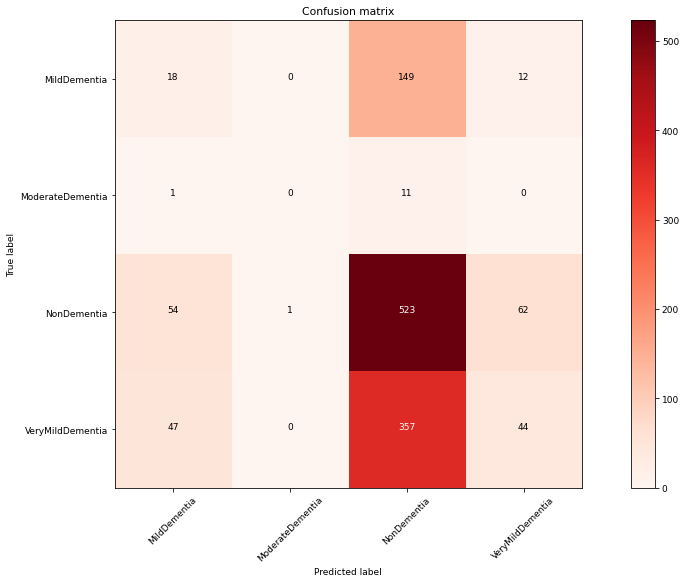

In [72]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

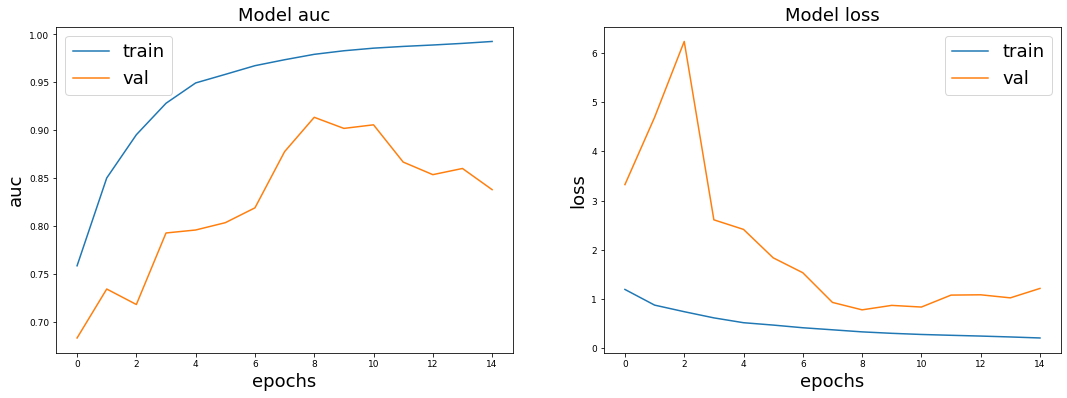

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    
    ax[i].legend(['train', 'val'],fontsize=18)

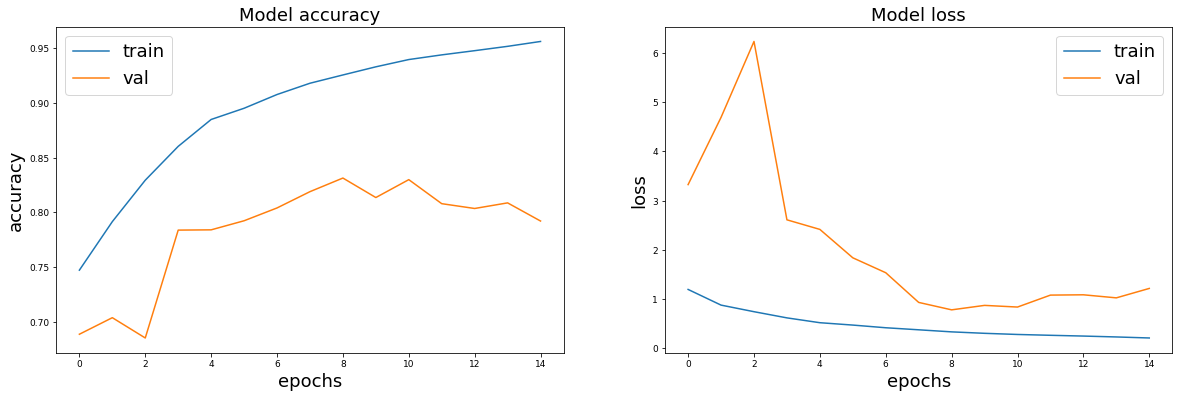

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()
#plt.ylim([0.0, 2.0])
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

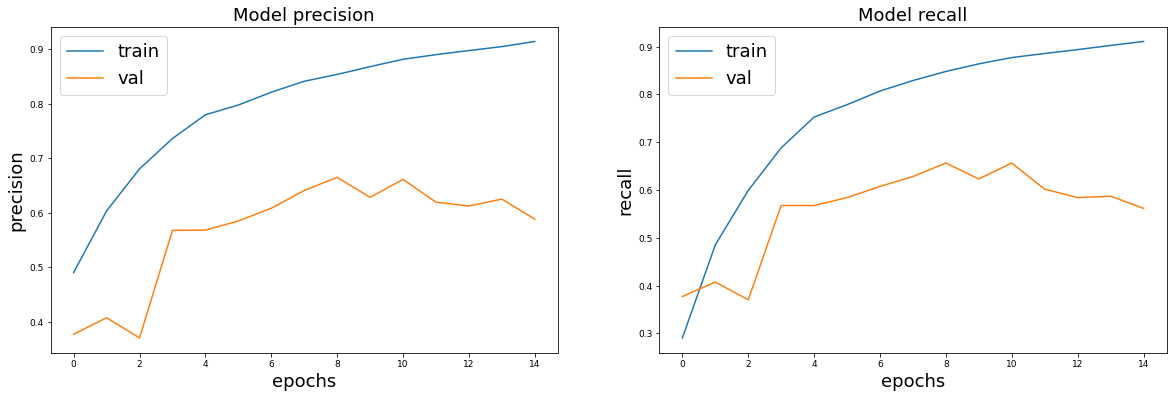

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 13s 1s/step - loss: 2.1915 - accuracy: 0.7654 - precision: 0.5315 - recall: 0.5215 - auc: 0.7680
  accuracy: 76.54%
  Loss: 2.19
Recal 52.15%, Area under the Curve (AUC) 76.80%
Confusion matrix, without normalization


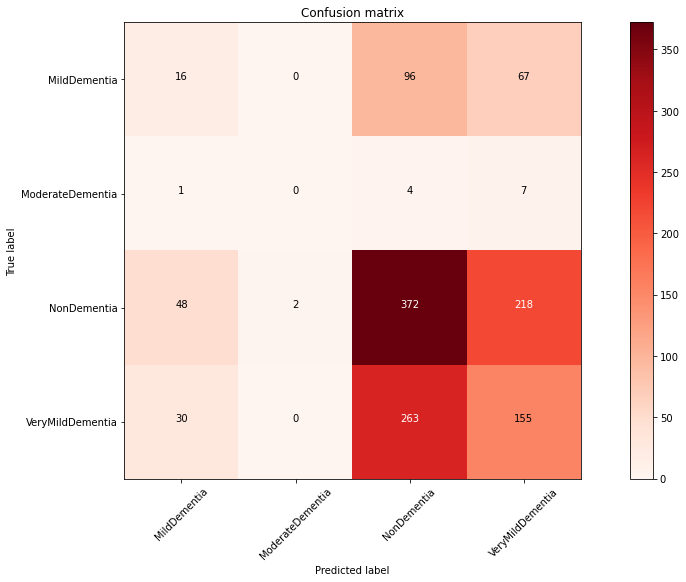

In [10]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 15s 1s/step - loss: 2.5708 - accuracy: 0.7494 - precision: 0.4988 - recall: 0.4910 - auc: 0.7342
  accuracy: 74.94%
  Loss: 2.57
Recal 49.10%, Area under the Curve (AUC) 73.42%
Confusion matrix, without normalization


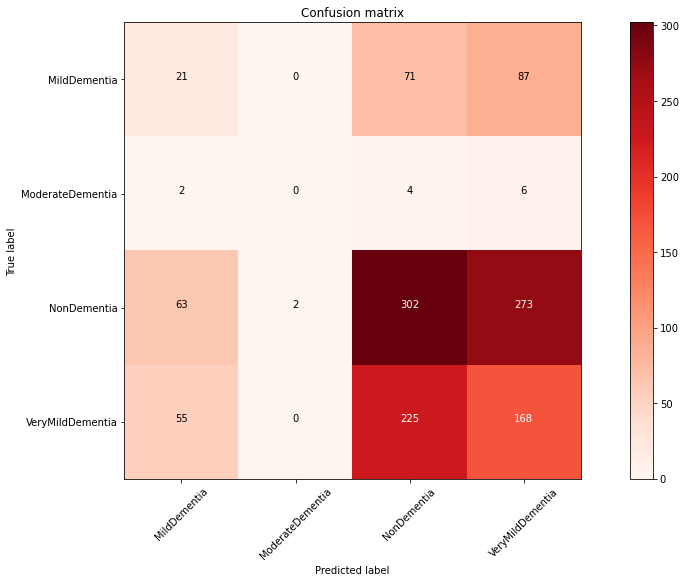

In [59]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size=batch_size, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 6s 410ms/step - loss: 2.8640 - accuracy: 0.7525 - precision: 0.5051 - recall: 0.5035 - auc: 0.7447
  accuracy: 75.25%
  Loss: 2.86
Recal 50.35%, Area under the Curve (AUC) 74.47%
Confusion matrix, without normalization


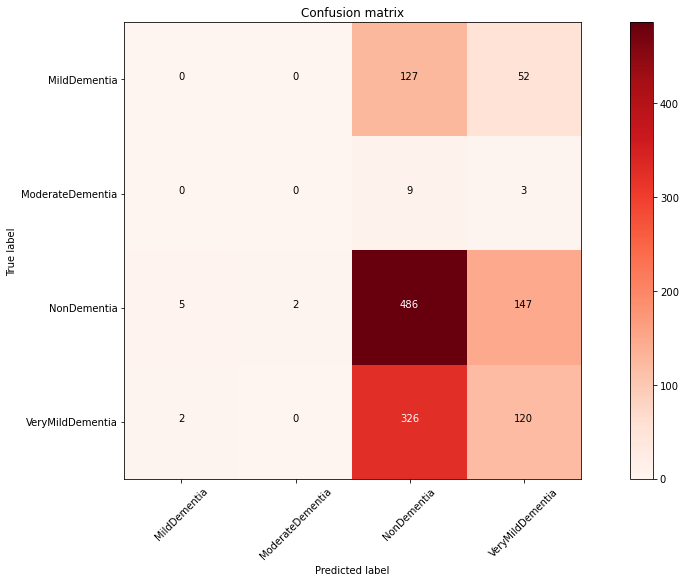

In [38]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size=batch_size, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

13/13 [==============================] - 4s 350ms/step - loss: 2.9958 - accuracy: 0.7535 - precision: 0.5072 - recall: 0.4980 - auc: 0.7204
  accuracy: 75.35%
  Loss: 3.00
Recal 49.80%, Area under the Curve (AUC) 72.04%
Confusion matrix, without normalization


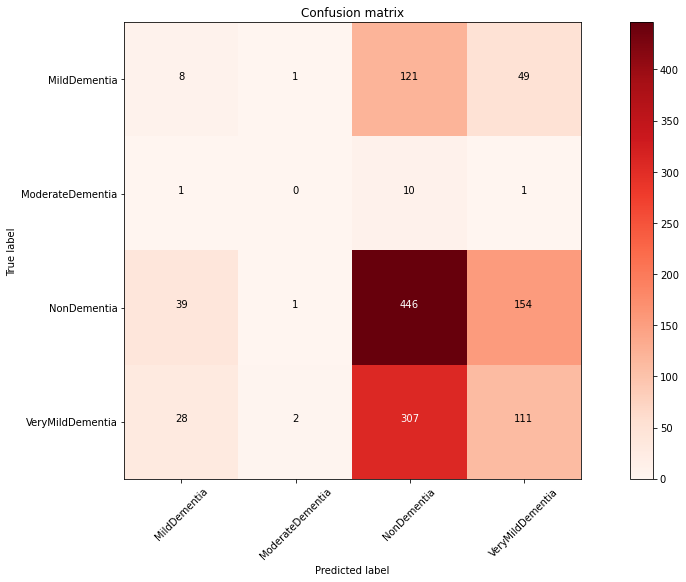

In [27]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size=batch_size, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

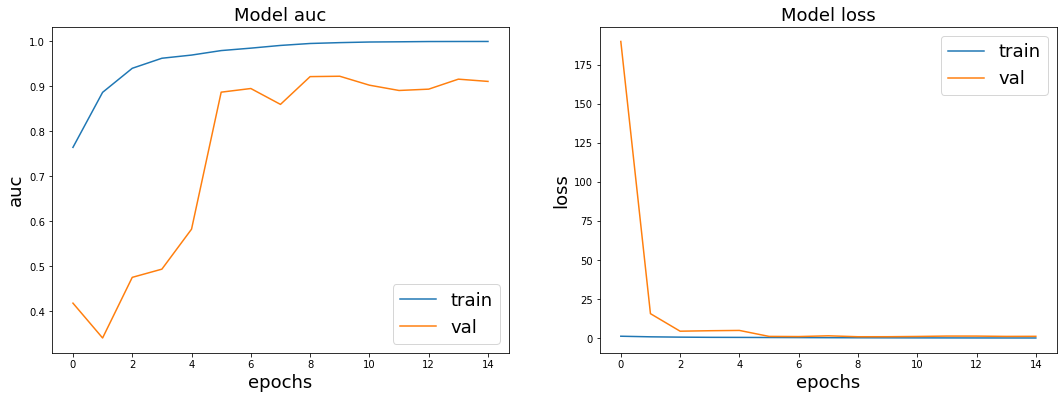

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    
    ax[i].legend(['train', 'val'],fontsize=18)

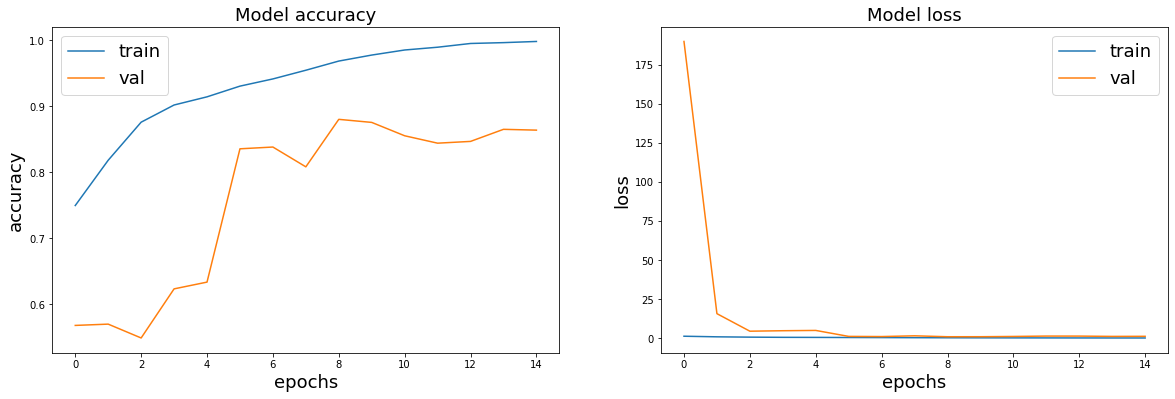

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()
#plt.ylim([0.0, 2.0])
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

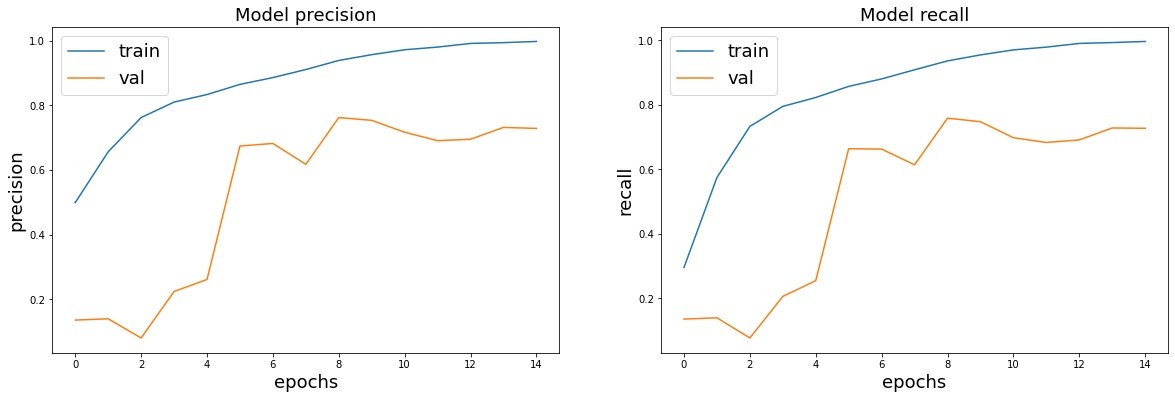

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

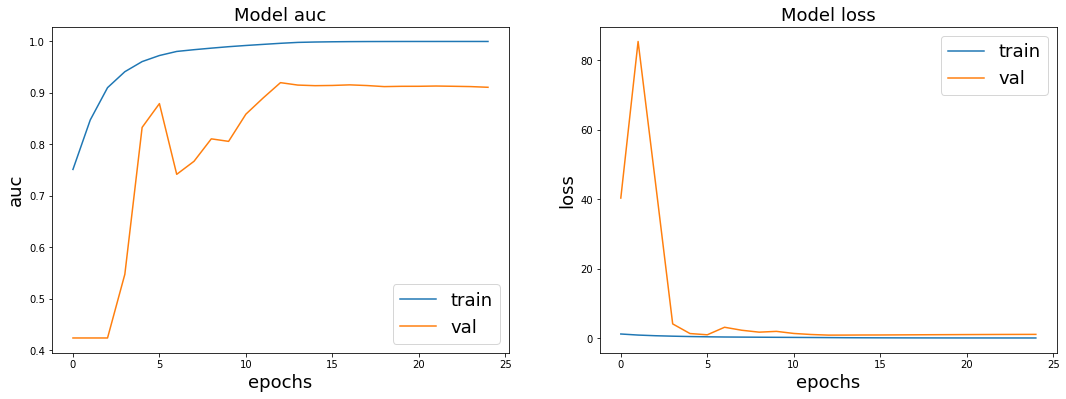

In [60]:
from keras.models import load_model
#model.save('first_try.h5')  # creates a HDF5 file 'my_model.h5'

import pickle

# to save:
with open('history4.pikl', 'wb') as f:
    pickle.dump(history.history, f)
f.close()
#to retrieve:    
# with open('histor.pikl', 'rb') as f:
#     history = pickle.load(f)
# f.close()


fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    
    ax[i].legend(['train', 'val'],fontsize=18)

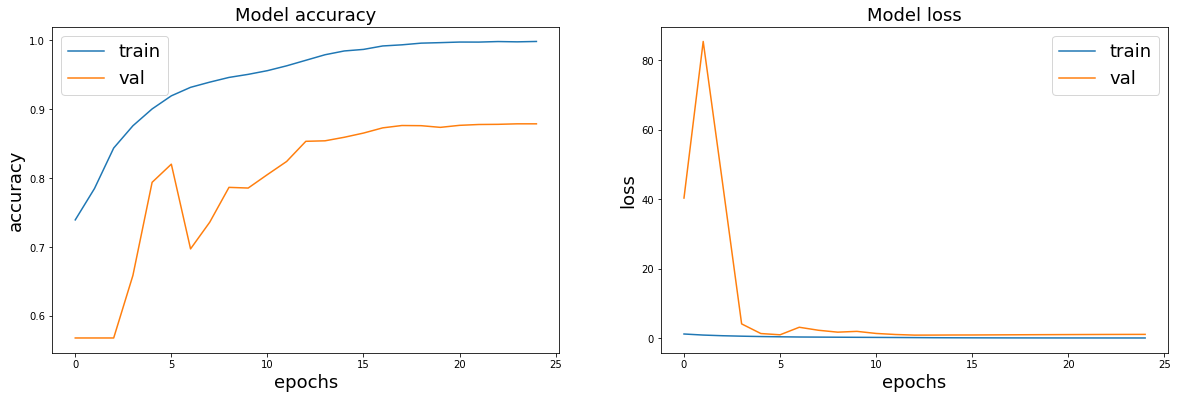

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()
#plt.ylim([0.0, 2.0])
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

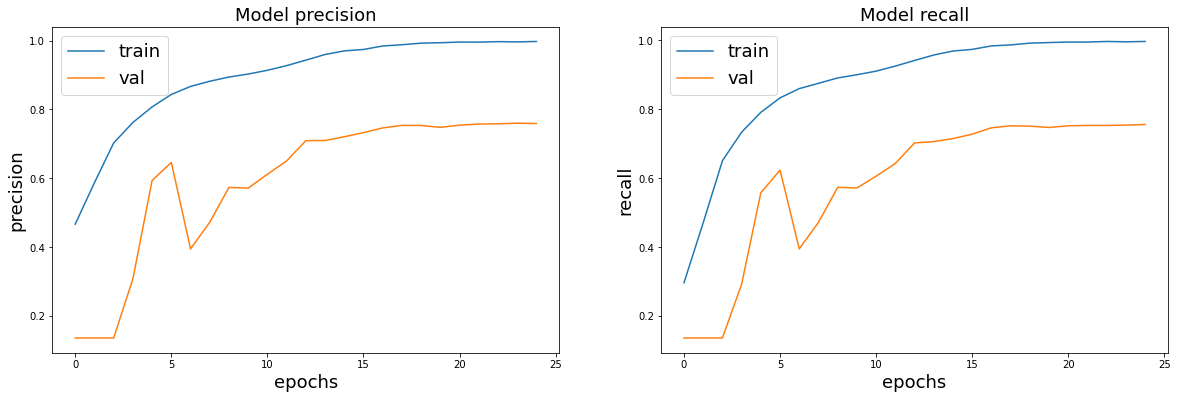

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met),fontsize=18)
    ax[i].set_xlabel('epochs',fontsize=18)
    ax[i].set_ylabel(met,fontsize=18)
    ax[i].legend(['train', 'val'],fontsize=18)

13/13 [==============================] - 23s 2s/step - loss: 5.4044 - accuracy: 0.6339 - precision: 0.2462 - recall: 0.2252 - auc: 0.4223
  accuracy: 63.39%
  Loss: 5.40
Recal 22.52%, Area under the Curve (AUC) 42.23%
Confusion matrix, without normalization


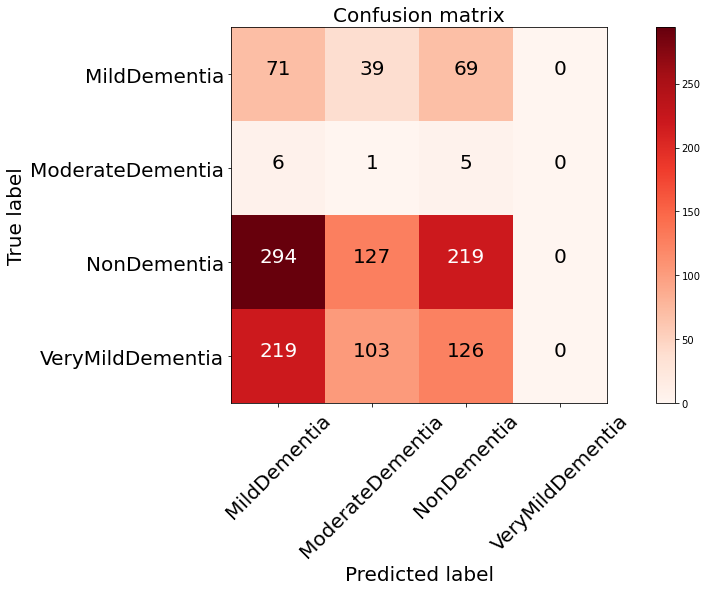

In [23]:
loss, accuracy, precision, recall, AUC  = model.evaluate(  test_ds, 
                                            batch_size= 23, 
                                            verbose=1)

print("  accuracy: {:.2f}%".format(accuracy * 100))  
print("  Loss: {:.2f}".format(loss))  
print("Recal {:.2f}%, Area under the Curve (AUC) {:.2f}%".format(recall*100, AUC*100))

preds = np.round(model.predict(test_ds),0) 
_test_labels = pd.DataFrame(test_labels)#.idxmax(axis=1)
_preds = pd.DataFrame(preds).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

In [13]:
res = pd.read_excel("results.csv")
res.head()

Method of Image Enhancement  Accuracy  Precision  \
0  Bi-Histogram Equalization with a Plateau Limit...      67.5       35.0   
1      Quantized Bi-Histogram Equalization (15 bins)      67.9       39.9   
2             Base-line model without any adjustment      68.8       42.3   
3  Dynamic Contrast Ratio Gamma Correction (DCRGC...      72.1       40.0   
4  Dynamic Contrast Ratio Gamma Correction (DCRGC...      72.4       44.8   

   Recall   AUC  PSNR (dB)  
0    35.0  56.7        3.0  
1    39.9  62.9       14.0  
2    37.0  68.5        0.0  
3    24.4  65.7        8.0  
4    44.4  74.5        8.0

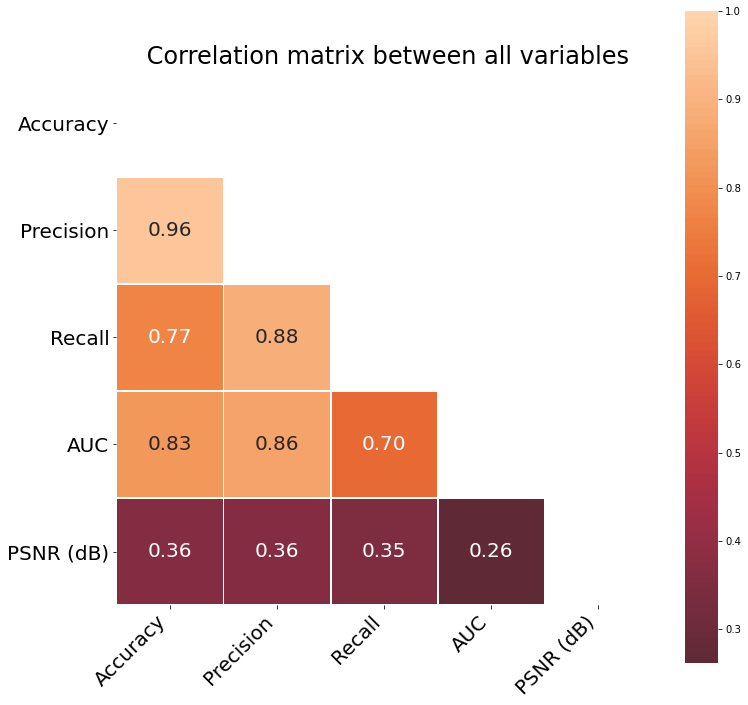

In [18]:
import seaborn as sns
corr = res.corr()
#sns.set(font_scale=2.0)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt='0.2f', vmax=1, center=0,
            square=True, linewidths=.9, annot_kws={"size":20}, cmap="icefire" )   #'viridis'
ax.set_title(' Correlation matrix between all variables',  fontsize=24 )
ax.set_yticklabels(  ax.get_yticklabels(),rotation=0,   fontsize=20)
ax.set_xticklabels(  ax.get_xticklabels(),     rotation=45,     horizontalalignment='right' , fontsize=20);

plt.show()

In [18]:
print(x_test.shape, y_test.shape)
x_train = x_train.reshape(5121, 208* 176* 3)
x_test = x_test.reshape(1279, 208* 176* 3)
print(x_train.shape)

(1279, 208, 176, 3) (1279,)
(5121, 109824)


# Predicting with Support Vector Machines

In [34]:
from sklearn.svm import SVC
svclf = SVC(gamma='auto', kernel= 'rbf' )
svclf.fit(x_train, y_train)
y_pred= svclf.predict(x_test)

# Took over 30 minutes and did not produce any results

KeyboardInterrupt: 

In [ ]:

rmse = RMSE(y_pred, y_test)
print(f'Root Mean Square Error of SVC  is {round(rmse,3)} ')
r_2 = r_squared(y_test, y_pred)
adj = adj_r_squared(y_test, y_pred, x_test)
print(f'R Squared of SVC is {round(r_2 ,3)} ')
print(f'Adjusted R Squared of SVC is {round(adj,3)} ')
print(f'SVC Model accuracy: {round(100*(y_pred == y_test).mean(),1)}%' )
  

prediction_train = svclf.predict(x_train)
accuracy_train = metrics.accuracy_score(prediction_train, y_train)
accuracy_test = metrics.accuracy_score(y_pred, y_test)
print('Train Set Accuracy = {:04.1f}%'.format(accuracy_train*100))
print('Test Set Accuracy = {:04.1f}%'.format(accuracy_test *100))

#  Predicting with Random Forest

Root Mean Square Error of Random Forest  is 1.057 
R Squared of Random Forest  is -0.221 
Adjusted R Squared of Random Forest  is 1.014 
Random Forest  Model accuracy: 52.6%
Train Set Accuracy = 63.8%
Test Set Accuracy = 52.6%
Confusion matrix, without normalization


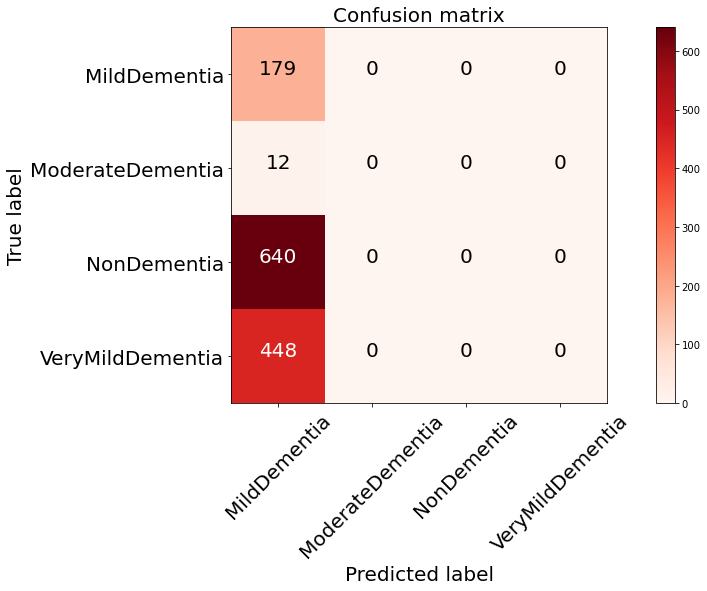

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(max_depth=12,  max_leaf_nodes=10, min_samples_split=5 )

rfclf.fit(x_train, y_train)
y_pred = rfclf.predict(x_test)

rmse = RMSE(y_pred, y_test)
print(f'Root Mean Square Error of Random Forest  is {round(rmse,3)} ')
r_2 = r_squared(y_test, y_pred)
adj = adj_r_squared(y_test, y_pred, x_test)
print(f'R Squared of Random Forest  is {round(r_2 ,3)} ')
print(f'Adjusted R Squared of Random Forest  is {round(adj,3)} ')
print(f'Random Forest  Model accuracy: {round(100*(y_pred == y_test).mean(),1)}%' )
prediction_train = rfclf.predict(x_train)
accuracy_train = metrics.accuracy_score(prediction_train, y_train)
accuracy_test = metrics.accuracy_score(y_pred, y_test)
print('Train Set Accuracy = {:04.1f}%'.format(accuracy_train*100))
print('Test Set Accuracy = {:04.1f}%'.format(accuracy_test *100))

_test_labels = pd.DataFrame(test_labels) 
_preds = pd.DataFrame(y_pred).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)

# Predicting Classes with Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rmse = RMSE(y_pred, y_test)
print(f'Root Mean Square Error of logistic regression is {round(rmse,3)} ')
r_2 = r_squared(y_test, y_pred)
adj = adj_r_squared(y_test, y_pred, x_test)
print(f'R Squared of logistic regression is {round(r_2 ,3)} ')
print(f'Adjusted R Squared of logistic regression is {round(adj,3)} ')
#print(f'Logistic Model accuracy: {round(100*(y_pred == y_test).mean(),1)}%' )
#model.coef_#.tolist()
prediction_train = model.predict(x_train)
accuracy_train = metrics.accuracy_score(prediction_train, y_train)
y_pred = model.predict(x_test)
accuracy_test = metrics.accuracy_score(y_pred, y_test)
print('Train Set Accuracy = {:04.1f}%'.format(accuracy_train*100))
print('Test Set Accuracy = {:04.1f}%'.format(accuracy_test *100))

/home/behr/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Root Mean Square Error of logistic regression is 1.036 
R Squared of logistic regression is -0.172 
Adjusted R Squared of logistic regression is 1.014 
Train Set Accuracy = 98.8%
Test Set Accuracy = 57.4%


Confusion matrix, without normalization


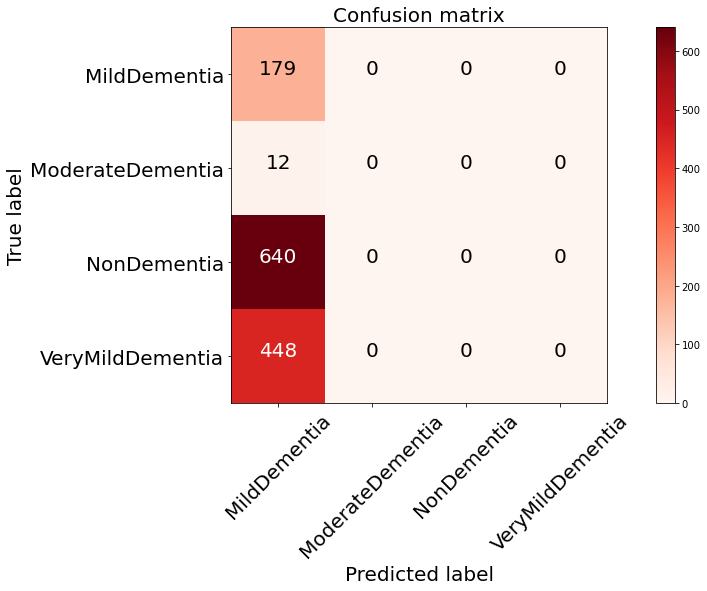

In [21]:
_test_labels = pd.DataFrame(test_labels) 
_preds = pd.DataFrame(y_pred).idxmax(axis=1)
plot_confusion_matrix(_test_labels , _preds , normalize = False)